## Function Definitions

In [1]:
import geopandas as gpd
import numpy as np
import os
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import shapely

import analysis.analysis_funcs as af
import analysis.plotting_funcs as pf


## Global service disruption stats

### Flood and TC destruction & disrution patterns

Dictionnaries

In [2]:
disr_rate_TC = af.load_disr_rate_allregs('TC')
destr_rate_TC = af.load_dest_rate_allregs('TC')
disr_rate_FL = af.load_disr_rate_allregs('FL')
destr_rate_FL = af.load_dest_rate_allregs('FL')

In [3]:
destr_rate_TC

{'ATG': {'1995241N11333': {'power_line': 85.3,
   'health': 100.0,
   'education': 100.0,
   'celltower': 100.0,
   'road': 66.8,
   'people': 100.0},
  '1999291N10309': {'power_line': 13.7,
   'health': 0.0,
   'education': 0.0,
   'celltower': 0.0,
   'road': 0.4,
   'people': 100.0},
  '2017242N16333': {'power_line': 59.8,
   'health': 0.0,
   'education': 96.5,
   'celltower': 100.0,
   'road': 55.3,
   'people': 100.0},
  '1989254N13340': {'power_line': 80.4,
   'health': 0.0,
   'education': 98.8,
   'celltower': 92.0,
   'road': 66.0,
   'people': 99.4},
  '1996187N10326': {'power_line': 0.0,
   'health': 0.0,
   'education': 0.0,
   'celltower': 0.0,
   'road': 0.0,
   'people': 0.6},
  '1998259N10335': {'power_line': 77.5,
   'health': 0.0,
   'education': 100.0,
   'celltower': 100.0,
   'road': 66.8,
   'people': 100.0},
  '2010236N12341': {'power_line': 2.0,
   'health': 0.0,
   'education': 0.0,
   'celltower': 4.0,
   'road': 0.4,
   'people': 1.1}},
 'BGD': {'1998133N040

In [6]:
stats_fl_tc = af.load_dict('/cluster/work/climate/evelynm/nw_outputs/USA/Florida/service_stats_TC_USA_Florida.pkl')

In [9]:
stats_fl_fl = af.load_dict('/cluster/work/climate/evelynm/nw_outputs/USA/Florida/service_stats_FL_USA_Florida.pkl')

In [37]:
destr_rate_FL = af.load_dest_rate_allregs('FL')

In [39]:
counter_all_fl = 0
counter_no_pop = 0
for cntry, cntry_dict in  destr_rate_FL.items():
    counter_all_fl+=len(cntry_dict)
    for event, event_dict in cntry_dict.items():
        if event_dict['people']<0.1:
            counter_no_pop+=1

In [44]:
counter_all_tc = 0
counter_no_pop = 0
for cntry, cntry_dict in  destr_rate_TC.items():
    counter_all_tc+=len(cntry_dict)
    for event, event_dict in cntry_dict.items():
        if event_dict['people']<0.1:
            counter_no_pop+=1

In [42]:
counter_no_pop/counter_all_fl

0.3640776699029126

In [45]:
counter_no_pop/counter_all_tc

0.0

Dataframes

In [12]:
def long_tidy_table_from_nested_dict(raw_data_dict, value_name):
    df_stacked = pd.DataFrame.from_dict(raw_data_dict).reset_index().rename({'index':'service'}, axis=1)
    df_long = df_stacked.melt(id_vars='service', var_name='event_id', 
                              value_name=value_name, ignore_index=True)
    df_long['event_severity']= df_long.apply(lambda row: df_stacked.iloc[5][row.event_id], axis=1)
    return df_long

In [13]:
list_df_long = []
for reg, reg_dict in destr_rate_TC.items():
    df_cleaned = long_tidy_table_from_nested_dict(reg_dict, 'destruction_rate')
    df_cleaned['iso3'] = reg
    list_df_long.append(df_cleaned)
df_destr_rate_TC = pd.concat(list_df_long)

list_df_long = []
for reg, reg_dict in destr_rate_FL.items():
    df_cleaned = long_tidy_table_from_nested_dict(reg_dict, 'destruction_rate')
    df_cleaned['iso3'] = reg
    list_df_long.append(df_cleaned)
df_destr_rate_FL = pd.concat(list_df_long)

In [14]:
list_df_long = []
for reg, reg_dict in disr_rate_TC.items():
    df_cleaned = long_tidy_table_from_nested_dict(reg_dict, 'disruption_rate')
    df_cleaned['iso3'] = reg
    list_df_long.append(df_cleaned)
df_disr_rate_TC = pd.concat(list_df_long)

list_df_long = []
for reg, reg_dict in disr_rate_FL.items():
    df_cleaned = long_tidy_table_from_nested_dict(reg_dict, 'disruption_rate')
    df_cleaned['iso3'] = reg
    list_df_long.append(df_cleaned)
df_disr_rate_FL = pd.concat(list_df_long)

In [15]:
df_destr_rate_FL['haz_type'] = 'FL'
df_destr_rate_TC['haz_type'] = 'TC'
df_destr_rates = pd.concat([df_destr_rate_FL, df_destr_rate_TC])

rename_dict = {'celltower' : 'cell towers',
               'road' : 'roads',
               'people' : 'people',
                'health':'health \n facilities',
                'power_line':'power \n lines',
               'power' : 'power lines',
                'education':'educ. \n facilities',}

df_destr_rates['service'] = df_destr_rates.apply(lambda row: rename_dict[row.service], axis=1)


In [16]:
df_disr_rate_FL['haz_type'] = 'FL'
df_disr_rate_TC['haz_type'] = 'TC'
df_disr_rates = pd.concat([df_disr_rate_FL, df_disr_rate_TC])
df_disr_rates['disruption_rate']*=100

rename_dict = {'telecom' : 'telecom',
               'mobility' : 'mobility',
               'people' : 'people',
            'healthcare':'healthcare',
             'power' : 'power',
             'power_line':'power',
              'celltower':'telecom',
              'road':'mobility',
              'education':'education',
              'health':'healthcare'}
df_disr_rates['service'] = df_disr_rates.apply(lambda row: rename_dict[row.service], axis=1)

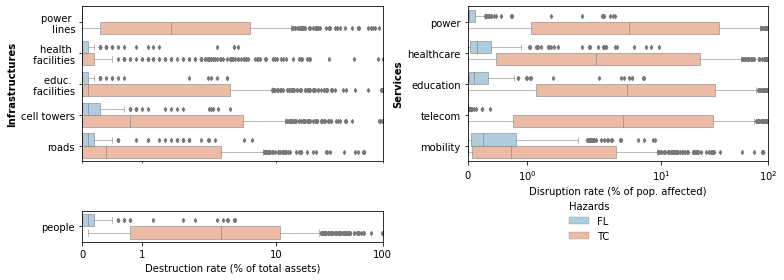

In [35]:
f, axes = plt.subplots(2, 2, gridspec_kw={'height_ratios': [5, 1]}, figsize=(11, 4), sharex=False)

axes = axes.flatten()
# Infrastructures
g = sns.boxplot(data = df_destr_rates[df_destr_rates.service!='people'], x="destruction_rate", y="service", hue="haz_type", palette='RdBu_r',
               fliersize=3, ax=axes[0], linewidth=0.5)
g.axes.set_xscale('symlog')
g.axes.set_ylabel('Infrastructures', weight='bold')
g.axes.set_xlim([0.0, 100])
g.axes.set_xlabel('')
plt.sca(axes[0])
plt.xticks([], [])
g.axes.get_legend().remove()

# Population
g = sns.boxplot(data = df_destr_rates[df_destr_rates.service=='people'], x="destruction_rate", y="service", hue="haz_type", palette='RdBu_r',
               fliersize=3, ax=axes[2], linewidth=0.5)
g.axes.set_xscale('symlog')
g.axes.set_xlabel('Destruction rate (% of total assets)')
g.axes.set_ylabel('')
g.axes.set_xlim([0, 100])
plt.sca(axes[1])
plt.xticks([0, 1, 10, 100], [0, 1, 10, 100])
g.axes.get_legend().remove()

# Services
g = sns.boxplot(data = df_disr_rates[df_disr_rates.service!='people'], x="disruption_rate", y="service", hue="haz_type", palette='RdBu_r',
               fliersize=3, ax=axes[1], linewidth=0.5)
g.axes.set_xscale('symlog')
g.axes.set_ylabel('Services', weight='bold')
g.axes.set_xlabel('Disruption rate (% of pop. affected)')
g.axes.set_xlim([0, 100])
plt.sca(axes[2])
plt.xticks([0, 1, 10, 100], [0, 1, 10, 100])

f.tight_layout()

leg = g.axes.get_legend()
leg.draw_frame(False)
leg.set_title('Hazards')
leg.set_bbox_to_anchor((0.5,-0.2))
leg.set_ncols(2)

f.delaxes(axes[-1])

""" 
plt.savefig(f'/cluster/work/climate/evelynm/nw_outputs/comp_results/destruction_patterns_TCFL.png', 
                    format='png', dpi=300,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)"""
plt.show()

### Average annual service impacts per region

In [2]:
annual_service_imps = {}

haz_type='TC'
nyears = 41
# countries
for iso3 in ['ATG', 'BGD', 'CUB', 'GTM', 'HTI', 'KHM', 'LKA', 'MDG', 'MEX', 'MOZ', 'PHL', 'VNM', 'PRI']:
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    annual_service_imps[iso3] = af.load_dict(path_cntry_folder+f'total_service_disruptions_{iso3}_{haz_type}.pkl')
    base_stat_dict = af.load_dict(path_cntry_folder+f'base_stats_{iso3}.pkl')
    gdf_nodes = gpd.read_feather(path_cntry_folder+'cis_nw_nodes')
    access_num_dict = af.access_rate_conversion(base_stat_dict, gdf_nodes, abs_num=True)
    
    for key in access_num_dict.keys():
        annual_service_imps[iso3][key] = annual_service_imps[iso3][key]/access_num_dict[key]/41
# states
for iso3, state in zip(['USA', 'USA', 'USA', 'CHN', 'CHN'], ['Florida', 'Louisiana', 'Texas', 'Fujian', 'Hainan']) :
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/{state}/'
    annual_service_imps[f'{iso3} {state}'] = af.load_dict(path_cntry_folder+f'total_service_disruptions_{iso3}_{state}_{haz_type}.pkl')
    base_stat_dict = af.load_dict(path_cntry_folder+f'base_stats_{iso3}_{state}.pkl')
    gdf_nodes = gpd.read_feather(path_cntry_folder+'cis_nw_nodes')
    access_num_dict = af.access_rate_conversion(base_stat_dict, gdf_nodes, abs_num=True)
    for key in access_num_dict.keys():
        annual_service_imps[f'{iso3} {state}'][key] = annual_service_imps[f'{iso3} {state}'][key]/access_num_dict[key]/41

In [3]:
annual_service_imps = pd.DataFrame.from_dict(annual_service_imps)
annual_service_imps = annual_service_imps.iloc[:-1,:]
annual_service_imps = annual_service_imps.T.reset_index().rename({'index':'iso3'}, axis=1)

In [4]:
annual_service_imps['geometry'] = annual_service_imps.apply(lambda row: af.iso_to_cntryshape(row.iso3), axis=1)
annual_service_imps = gpd.GeoDataFrame(annual_service_imps) 
annual_service_imps.iloc[:,1:-1]*=100 # frac to perc

/cluster/apps/nss/gcc-8.2.0/python/3.9.9/x86_64/lib64/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/cluster/apps/nss/gcc-8.2.0/python/3.9.9/x86_64/lib64/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/cluster/apps/nss/gcc-8.2.0/python/3.9.9/x86_64/lib64/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to ge

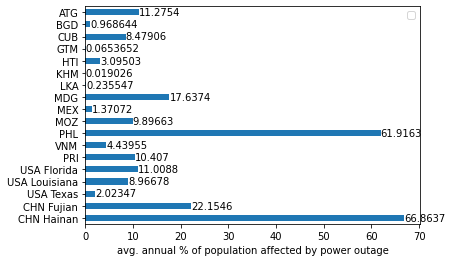

In [25]:
ax = annual_service_imps.plot.barh(x='iso3', y='power')
ax.invert_yaxis()
ax.legend('')
plt.xlabel('avg. annual % of population affected by power outage')
plt.ylabel('')
ax.bar_label(ax.containers[0])
#for i in range(len(x)):
#    plt.text(i,y[i],y[i])
plt.show()

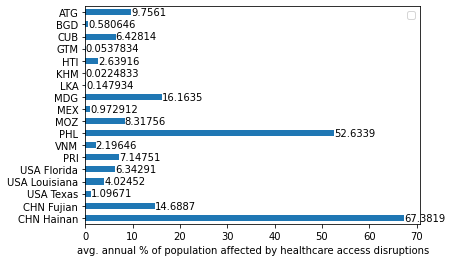

In [28]:
ax = annual_service_imps.plot.barh(x='iso3', y='healthcare')
ax.invert_yaxis()
ax.legend('')
plt.xlabel('avg. annual % of population affected by healthcare access disruptions')
plt.ylabel('')
ax.bar_label(ax.containers[0])
#for i in range(len(x)):
#    plt.text(i,y[i],y[i])
plt.show()

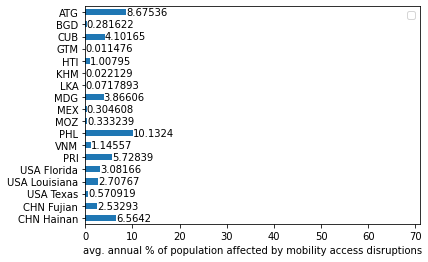

In [33]:
ax = annual_service_imps.plot.barh(x='iso3', y='mobility')
ax.invert_yaxis()
ax.legend('')
plt.xlabel('avg. annual % of population affected by mobility access disruptions')
plt.ylabel('')
plt.xlim(0,71)
ax.bar_label(ax.containers[0])
#for i in range(len(x)):
#    plt.text(i,y[i],y[i])
plt.show()

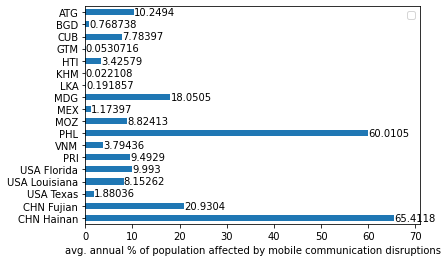

In [34]:
ax = annual_service_imps.plot.barh(x='iso3', y='telecom')
ax.invert_yaxis()
ax.legend('')
plt.xlabel('avg. annual % of population affected by mobile communication disruptions')
plt.ylabel('')
plt.xlim(0,71)
ax.bar_label(ax.containers[0])
#for i in range(len(x)):
#    plt.text(i,y[i],y[i])
plt.show()

### Annual average service impacts per point

In [5]:
annual_service_imps_perpoint = {}

haz_type='TC'
nyears = 41
# countries
for iso3 in ['ATG', 'BGD', 'CUB', 'GTM', 'HTI', 'KHM', 'LKA', 'MDG', 'MEX', 'MOZ', 'PHL', 'VNM', 'PRI']:
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    df = gpd.read_feather(path_cntry_folder+f'summed_pop_impacts_{haz_type}_{iso3}')
    df_data = df.iloc[:,:-5].values
    no_imps = np.where(df_data  > 0 )
    df_data[no_imps[0], no_imps[1]] = np.nan
    df.iloc[:,:-5]  = df_data/nyears*-1
    df['iso3'] = iso3
    annual_service_imps_perpoint[iso3] = df
    
# states
for iso3, state in zip(['USA', 'USA', 'USA', 'CHN', 'CHN'], ['Florida', 'Louisiana', 'Texas', 'Fujian', 'Hainan']) :
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/{state}/'
    df = gpd.read_feather(path_cntry_folder+f'summed_pop_impacts_{haz_type}_{iso3}_{state}')
    df_data = df.iloc[:,:-5].values
    no_imps = np.where(df_data  > 0 )
    df_data[no_imps[0], no_imps[1]] = np.nan
    df.iloc[:,:-5]  = df_data/nyears*-1
    df['iso3'] = f'{iso3} {state}'
    annual_service_imps_perpoint[f'{iso3} {state}'] = df
annual_service_imps_perpoint = pd.concat([df for df in annual_service_imps_perpoint.values()])

### Plotting avg countries

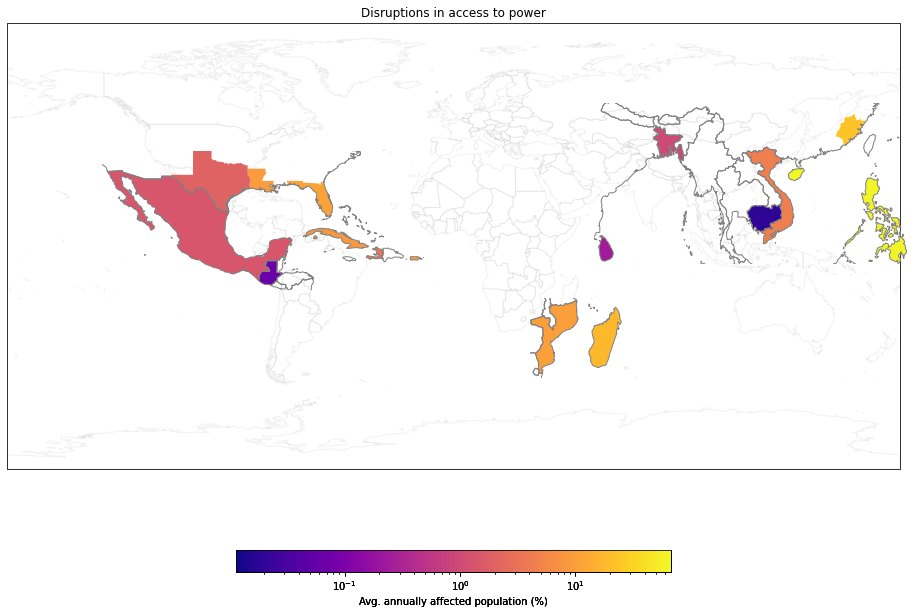

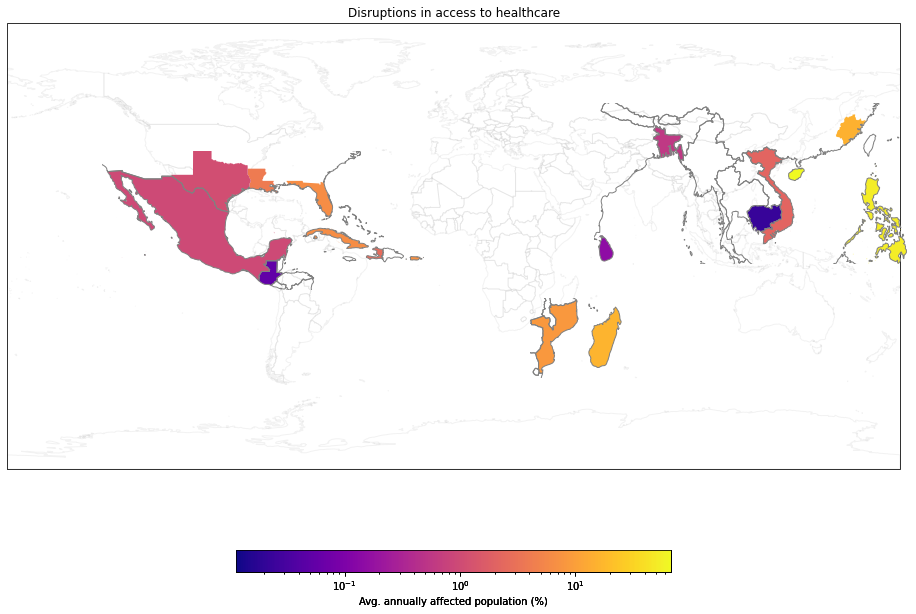

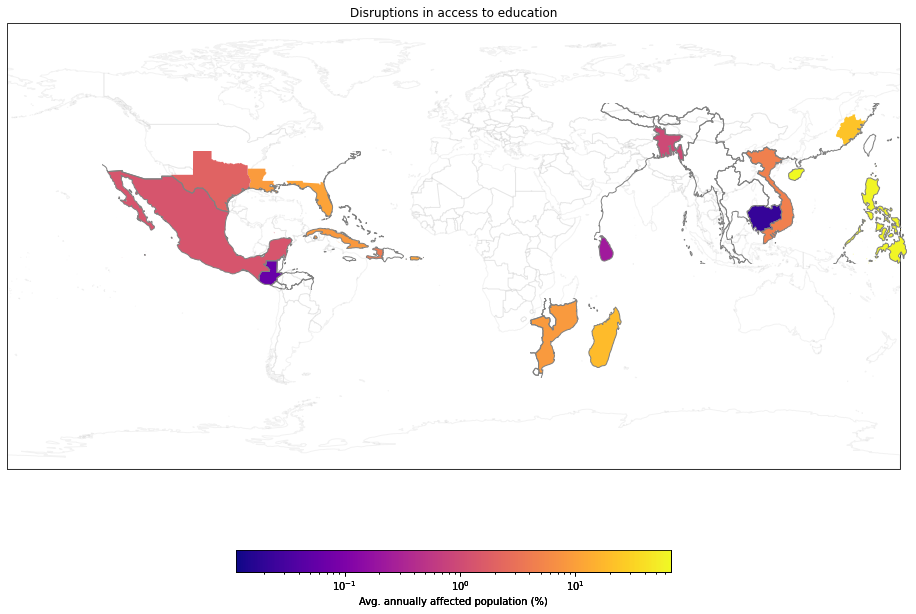

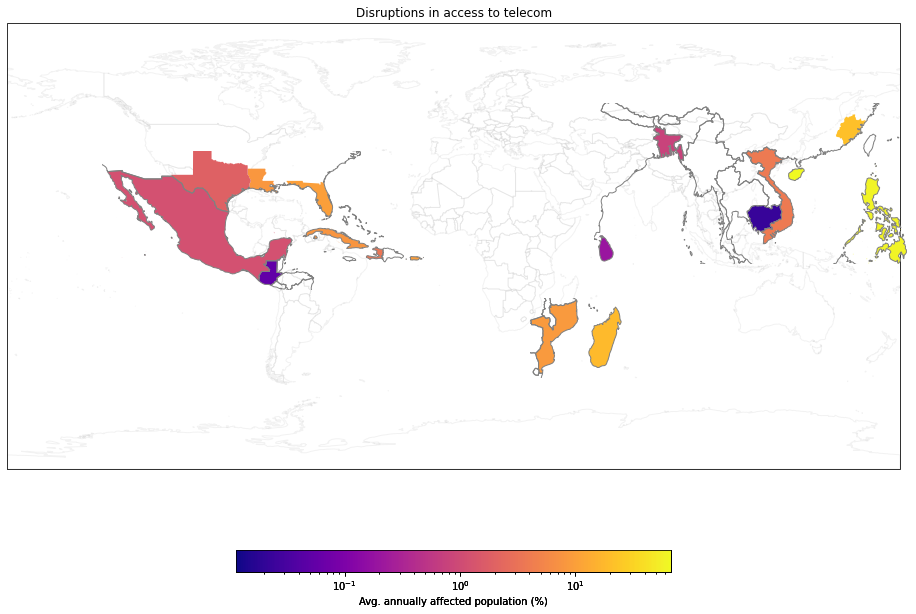

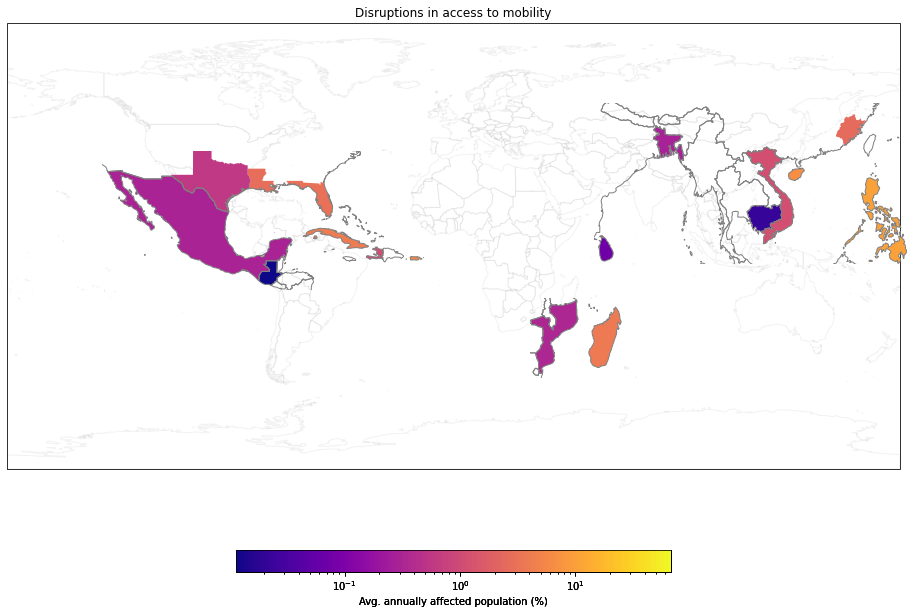

In [27]:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    import cartopy.mpl.geoaxes
    from matplotlib.colors import ListedColormap
    from matplotlib.patches import Patch
    from mpl_toolkits.axes_grid1 import make_axes_locatable, inset_locator
    
    for service in ['power', 'healthcare', 'education', 'telecom', 'mobility']:
        border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
        f, axes = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()),
                               figsize=(16,16))
        axes.add_feature(border, facecolor='none', edgecolor='0.5', alpha=0.1)

        zoom1 = (-118, -65, 13, 36)
        zoom2 = (30, 51, -28, -10)
        zoom3 = (79, 127, 5.5, 30)

        vmin = np.min(annual_service_imps.iloc[:,1:-1].values.flatten())
        vmax = np.max(annual_service_imps.iloc[:,1:-1].values.flatten())

        axins1 = inset_locator.inset_axes(axes, width="120%", height="120%", 
                                          bbox_to_anchor=((zoom1[0]+180)/360, (zoom1[2]+90)/180-0.1, .3, .3),
                                          bbox_transform=axes.transAxes, loc=1,
                                          axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                                          axes_kwargs=dict(projection=ccrs.PlateCarree())) 

        axins2 = inset_locator.inset_axes(axes, width="120%", height="120%", 
                                          bbox_to_anchor=((zoom2[0]+180)/360, (zoom2[2]+90)/180-0.1, .15, .15),
                                          bbox_transform=axes.transAxes, loc=1,
                                          axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                                          axes_kwargs=dict(projection=ccrs.PlateCarree()))

        axins3 = inset_locator.inset_axes(axes, width="120%", height="120%", 
                                          bbox_to_anchor=((zoom3[0]+180)/360, (zoom3[2]+90)/180, .3, .3),
                                          bbox_transform=axes.transAxes, loc=1,
                                          axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                                          axes_kwargs=dict(projection=ccrs.PlateCarree()))
        axes.set_title(f'Disruptions in access to {service}')
        extent_list = [zoom1, zoom2, zoom3]
        for ax, extent in zip([axins1, axins2, axins3], extent_list):
            ax.set_extent(extent, ccrs.PlateCarree())
            ax.add_feature(border, facecolor='none', edgecolor='0.5')
            ax.set_axis_off()
            #vmin = np.min(annual_service_imps[service].values)
            #vmax = np.max(annual_service_imps[service].values)
            pcm = annual_service_imps.plot(service, cmap='plasma', norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                                           vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), ax=ax, legend=True,
                                          legend_kwds={'label':'Avg. annually affected population (%)', 'shrink':0.5,
                                                      'location': 'bottom', 'pad':1})
        plt.show()
        

### Plotting point-wise

In [3]:
def _two_slope_norm(vmin=-10, vcenter=0, vmax=1):
    """
    Two Slope Norm example from
    https://matplotlib.org/stable/tutorials/colors/colormapnorms.html
    """
    #cols_access = plt.cm.Greens(np.linspace(0.75, 1, 25))
    #cols_access = plt.cm.Greens(np.linspace(0.2, 0.3, 10))
    #cols_inavail = plt.cm.Greys(np.linspace(0.2, 0.3, 11))
    cols_lower = plt.cm.magma(np.linspace(0, 0.85, 40))
    cols_upper1 = plt.cm.magma(np.linspace(0.86, 0.94, 150))
    cols_upper2 = plt.cm.magma(np.linspace(0.95, 1, 150))
    all_colors = np.vstack((cols_lower, cols_upper1, cols_upper2))
    segment_colmap = colors.LinearSegmentedColormap.from_list('service_states', all_colors)
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    return segment_colmap, divnorm  

In [ ]:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    import cartopy.mpl.geoaxes
    from matplotlib.colors import ListedColormap
    from matplotlib.patches import Patch
    from mpl_toolkits.axes_grid1 import make_axes_locatable, inset_locator
    
    for service in [colname for colname in annual_service_imps_perpoint.columns if 'actual_supply_' in colname]:
        border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
        f, axes = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()),
                               figsize=(16,16))
        axes.add_feature(border, facecolor='none', edgecolor='0.5', alpha=0.05)

        zoom1 = (-118, -65, 13, 36)
        zoom2 = (30, 51, -28, -10)
        zoom3 = (79, 127, 5.5, 30)

        vmin = np.nanmin(annual_service_imps_perpoint.iloc[:,:-7].values.flatten())+1
        vmax = np.nanmax(annual_service_imps_perpoint.iloc[:,:-7].values.flatten())

        axins1 = inset_locator.inset_axes(axes, width="120%", height="120%", 
                                          bbox_to_anchor=((zoom1[0]+180)/360, (zoom1[2]+90)/180-0.1, .3, .3),
                                          bbox_transform=axes.transAxes, loc=1,
                                          axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                                          axes_kwargs=dict(projection=ccrs.PlateCarree())) 

        axins2 = inset_locator.inset_axes(axes, width="120%", height="120%", 
                                          bbox_to_anchor=((zoom2[0]+180)/360-0.1, (zoom2[2]+90)/180-0.15, .15, .15),
                                          bbox_transform=axes.transAxes, loc=1,
                                          axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                                          axes_kwargs=dict(projection=ccrs.PlateCarree()))

        axins3 = inset_locator.inset_axes(axes, width="120%", height="120%", 
                                          bbox_to_anchor=((zoom3[0]+180)/360-0.05, (zoom3[2]+90)/180, .3, .3),
                                          bbox_transform=axes.transAxes, loc=1,
                                          axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                                          axes_kwargs=dict(projection=ccrs.PlateCarree()))
        
        axes.set_title(f'Disruptions in access to {af.cinames_dict()[service[14:-7]]}')
        extent_list = [zoom1, zoom2, zoom3]
        
        #segment_colmap, divnorm = _two_slope_norm(vmin=1, vcenter=2000, vmax=80000)
        
        for ax, extent in zip([axins1, axins2, axins3], extent_list):
            ax.set_extent(extent, ccrs.PlateCarree())
            ax.add_feature(border, facecolor='none', edgecolor='0.5')
            ax.set_axis_off()
            segment_map, divnorm = _two_slope_norm(vmin=0, vcenter=100, vmax=80000)
            pcm = ax.scatter(annual_service_imps_perpoint.geometry.x, 
                             annual_service_imps_perpoint.geometry.y, 
                             c=annual_service_imps_perpoint[service], 
                             norm=divnorm, cmap=segment_map, transform=ccrs.PlateCarree(),
                             s=0.01) #norm=colors.LogNorm(vmin=vmin, vmax=10000),#vmax  cmap='plasma',
        cb = f.colorbar(pcm, shrink=0.75, ax=ax, orientation='horizontal', panchor=(0.8,0))
        tick_list = [1, 100, 1000, 30000, 80000]#list(np.arange(vmin,vmax,3000))
        cb.set_ticks(tick_list)
    
        plt.savefig(f'/cluster/work/climate/evelynm/nw_outputs/comp_results/annual_avg_disr_points_TC_{service}.png', 
                    format='png', dpi=300,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
        plt.show()


## Creating Impact Cascade Factors

### Cascade Factor A (fraction service loss : fraction directly affected )

In [17]:
haz_type='TC'
# countries
for iso3 in ['ATG', 'BGD', 'CUB', 'GTM', 'HTI', 'KHM', 'LKA', 'MDG', 'MEX', 'MOZ', 'PHL', 'VNM', 'PRI']:
    perevent_factor_a = pd.DataFrame()
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    disr_rate_dict = af.load_dict(path_cntry_folder+f'disruption_rates_{iso3}_{haz_type}.pkl')
    for event, disr_rates in disr_rate_dict.items(): 
        perevent_factor_a[event] = pd.Series({key : disr_rates[key]/disr_rates['people'] for key in disr_rates.keys()}, index=disr_rates.keys())
    perevent_factor_a['median'] = perevent_factor_a.apply(lambda row: np.nanmedian(row), axis=1)
    perevent_factor_a = perevent_factor_a.reindex(["power", "telecom", "healthcare", 'education', 'mobility', 'people'])
    perevent_factor_a = perevent_factor_a.rename(mapper={'telecom':'mobile communications', 'power':'electricity', 'people':'population'},axis=0)
    perevent_factor_a.to_csv(path_cntry_folder+f'perevent_factor_a_{iso3}_{haz_type}.csv')
    
    
# states
for iso3, state in zip(['USA', 'USA', 'USA', 'CHN', 'CHN'], ['Florida', 'Louisiana', 'Texas', 'Fujian', 'Hainan']):
    perevent_factor_a = pd.DataFrame()
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    disr_rate_dict = af.load_dict(path_cntry_folder+f'{state}/disruption_rates_{iso3}_{state}_{haz_type}.pkl')
    for event, disr_rates in disr_rate_dict.items(): 
        perevent_factor_a[event] = pd.Series({key : disr_rates[key]/disr_rates['people'] for key in disr_rates.keys()}, index=disr_rates.keys())
    perevent_factor_a['median'] = perevent_factor_a.apply(lambda row: np.nanmedian(row), axis=1)
    perevent_factor_a = perevent_factor_a.reindex(["power", "telecom", "healthcare", 'education', 'mobility', 'people'])
    perevent_factor_a = perevent_factor_a.rename(mapper={'telecom':'mobile communications', 'power':'electricity', 'people':'population'},axis=0)
    perevent_factor_a.to_csv(path_cntry_folder+f'{state}/perevent_factor_a_{iso3}_{state}_{haz_type}.csv')
    

/scratch/tmp.14298563.evelynm/ipykernel_115563/1224294845.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  perevent_factor_a[event] = pd.Series({key : disr_rates[key]/disr_rates['people'] for key in disr_rates.keys()}, index=disr_rates.keys())


In [18]:
perevent_factor_a

1980197N07154  1981176N08150  1982283N17148  \
electricity                 1.297528       3.363071       1.097353   
mobile communications       1.246455       3.318279       0.496496   
healthcare                  1.149835       2.886402       1.916612   
education                   1.322825       3.396874       1.258859   
mobility                    0.168492       0.106131       0.000115   
population                  1.000000       1.000000       1.000000   

                       1983186N04153  1983271N18118  1984239N08146  \
electricity                 1.095462       1.084880       1.258665   
mobile communications       1.067876       1.036869       1.229824   
healthcare                  1.162541       0.030124       1.370037   
education                   1.116080       1.066332       1.232835   
mobility                    0.285189       0.011332       0.513269   
population                  1.000000       1.000000       1.000000   

                       1985268N16126  1985284N05159  1986228N19120  \
electricity               239.342479       2.306040       1.225580   
mobile communications     240.423339       2.268702       1.222715   
healthcare                240.942781       2.370559       1.083790   
education                 242.550982       2.300841       1.217634   
mobility                    0.050239       0.373544       0.274452   
population                  1.000000       1.000000       1.000000   

                       1987219N08155  ...  2011266N13139  2012296N06135  \
electricity                 5.658789  ...       1.436217       1.003231   
mobile communications       5.728490  ...       1.262284       0.689839   
healthcare                  5.301615  ...       1.246160       1.661479   
education                   5.769781  ...       1.461159       1.058898   
mobility                    0.269454  ...       0.033919       0.078150   
population                  1.000000  ...       1.000000       1.000000   

                       2013306N07162  2014190N08154  2014254N10142  \
electricity                 5.264869       1.500410       1.455778   
mobile communications       5.282563       1.468285       1.402510   
healthcare                  5.282563       1.394736       1.279857   
education                   5.282563       1.518888       1.481046   
mobility                    0.498350       0.675108       0.094957   
population                  1.000000       1.000000       1.000000   

                       2016287N13130  2017253N14130  2020286N17118  \
electricity                 2.468457     124.629090     282.231206   
mobile communications       2.531309     124.839554     279.015603   
healthcare                  2.899876     109.241888     283.423675   
education                   2.503106     129.201621     293.235411   
mobility                    0.167566       0.000000       0.000000   
population                  1.000000       1.000000       1.000000   

                       2020285N17120    median  
electricity                 3.462769  2.752922  
mobile communications       2.767415  2.715021  
healthcare                  1.804800  2.810434  
education                   3.826625  2.766555  
mobility                    0.013741  0.123967  
population                  1.000000  1.000000  

[6 rows x 41 columns]

In [10]:
perevent_factor_a = perevent_factor_a['MDG']
perevent_factor_a.reindex(["power", "telecom", "healthcare", 'education', 'mobility', 'population'])

1993016S16042  2013046S20042  1988021S12080  1984016S15073  \
power            0.000000       0.000000       0.388755       6.265597   
telecom          0.112976       0.000000       0.000000      13.190065   
healthcare       0.273703       0.093472       0.424310       1.421937   
education        0.000000       0.175824       0.484678       5.791521   
mobility         0.204095       0.180973       0.053772       0.104452   

            1982075S12055  2008037S10055  1994064S13099  2017061S11063  \
power            0.751037       2.413302       2.929889       1.782333   
telecom          0.817272       2.556251       2.164939       2.301784   
healthcare       0.764096       1.907208       1.215567       1.899967   
education        0.974475       2.505539       2.645895       2.214086   
mobility         0.413766       0.450920       0.225583       0.395635   

            2005017S09061  2003021S11081  ...  2000083S17102  2001364S19036  \
power            0.000000       0.000000  ...       1.456768       0.000000   
telecom          0.000000       0.000000  ...       1.426944       0.000000   
healthcare       0.019227       0.066497  ...       1.533788       0.091490   
education        0.311176       0.016829  ...       1.775990       0.010834   
mobility         0.388957       0.041562  ...       0.598131       0.198343   

            2007066S12066  2006021S11053  2000032S11116  1996049S10068  \
power            0.000000       0.000000       2.880801       0.000000   
telecom          0.179892       0.007282       2.833976       0.141721   
healthcare       0.526908       0.094047       2.866814       0.454970   
education        0.638435       0.106981       2.861356       0.600638   
mobility         0.529976       0.364067       0.938668       0.467737   

            2003122S11065  2011038S11062  1989006S15044    median  
power            1.723171       0.000000       0.000000  0.000000  
telecom          2.171107       0.000000       0.747586  0.747586  
healthcare       2.102740       0.040901       0.355713  0.518233  
education        2.429798       0.322079       0.308356  0.638435  
mobility         0.395371       0.248309       0.350609  0.339292  

[5 rows x 46 columns]

### Cascade Factor B (spatial cascade - all service losses : service losses of dir. affected)

In [ ]:
haz_type='TC'
# countries
for iso3 in ['ATG', 'BGD', 'CUB', 'GTM', 'HTI', 'KHM', 'LKA', 'MDG', 'MEX', 'MOZ', 'PHL', 'VNM', 'PRI']:
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    total_imps_relb={}
    gdf_summed_popweighted = gpd.GeoDataFrame(pd.read_csv(path_cntry_folder+f'summed_pop_impacts_{haz_type}_{iso3}.csv'))
    for variable, service in service_dict2().items():
        lost_service = gdf_summed_popweighted[gdf_summed_popweighted[variable]<0][variable].sum()
        sub_gdf = gdf_summed_popweighted[(gdf_summed_popweighted['imp_dir']<0) & (gdf_summed_popweighted[variable]<0)]
        lost_service_while_aff = np.maximum(sub_gdf[variable], sub_gdf['imp_dir']).sum()
        total_imps_relb[service] = np.round(lost_service/lost_service_while_aff,2)
    total_imps_relb['people']=1
    save_dict(total_imps_relb, path_cntry_folder+f'total_service_disruptions_relb_{iso3}_{haz_type}.pkl')
# states
for iso3, state in zip(['USA', 'USA', 'USA', 'CHN', 'CHN'], ['Florida', 'Louisiana', 'Texas', 'Fujian', 'Hainan']) :
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    total_imps_relb={}
    gdf_summed_popweighted = gpd.GeoDataFrame(pd.read_csv(path_cntry_folder+f'{state}/summed_pop_impacts_{haz_type}_{iso3}_{state}.csv'))
    for variable, service in service_dict2().items():
        lost_service = gdf_summed_popweighted[gdf_summed_popweighted[variable]<0][variable].sum()
        sub_gdf = gdf_summed_popweighted[(gdf_summed_popweighted['imp_dir']<0) & (gdf_summed_popweighted[variable]<0)]
        lost_service_while_aff = np.maximum(sub_gdf[variable], sub_gdf['imp_dir']).sum()
        total_imps_relb[service] = np.round(lost_service/lost_service_while_aff,2)
    total_imps_relb['people']=1
    save_dict(total_imps_relb, path_cntry_folder+f'{state}/total_service_disruptions_relb_{iso3}_{state}_{haz_type}.pkl')    
                                              

### Cascade Factor C (resilience cascade - number of service losses : number of service access in dir. affected area)

In [135]:
haz_type='TC'
# countries
for iso3 in ['ATG', 'BGD', 'CUB', 'GTM', 'HTI', 'KHM', 'LKA', 'MDG', 'MEX', 'MOZ', 'PHL', 'VNM', 'PRI']:
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'    
    total_imps_relc={}
    gdf_summed_popweighted = gpd.GeoDataFrame(pd.read_csv(path_cntry_folder+f'summed_pop_impacts_{haz_type}_{iso3}.csv'))
    for variable, service in service_dict2().items():
        lost_service = gdf_summed_popweighted[gdf_summed_popweighted[variable]<0][variable].sum()
        # has or had service, in directly affected area
        had_service_affected = gdf_summed_popweighted[(gdf_summed_popweighted['imp_dir']<0) & 
                                                      (gdf_summed_popweighted[variable]!=0)]['imp_dir'].sum()
        total_imps_relc[service] = np.round(lost_service/had_service_affected,2)
    total_imps_relc['people']=1
    save_dict(total_imps_relc, path_cntry_folder+f'total_service_disruptions_relc_{iso3}_{haz_type}.pkl')
# states
for iso3, state in zip(['USA', 'USA', 'USA', 'CHN', 'CHN'], ['Florida', 'Louisiana', 'Texas', 'Fujian', 'Hainan']) :
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    total_imps_relc={}
    gdf_summed_popweighted = gpd.GeoDataFrame(pd.read_csv(path_cntry_folder+f'{state}/summed_pop_impacts_{haz_type}_{iso3}_{state}.csv'))
    for variable, service in service_dict2().items():
        lost_service = gdf_summed_popweighted[gdf_summed_popweighted[variable]<0][variable].sum()
        # has or had service, in directly affected area
        had_service_affected = gdf_summed_popweighted[(gdf_summed_popweighted['imp_dir']<0) & 
                                                      (gdf_summed_popweighted[variable]!=0)]['imp_dir'].sum()
        total_imps_relc[service] = np.round(lost_service/had_service_affected,2)
    total_imps_relc['people']=1
    save_dict(total_imps_relc, path_cntry_folder+f'{state}/total_service_disruptions_relc_{iso3}_{state}_{haz_type}.pkl')
                                              

In [24]:
gdf_summed_popweighted = gpd.GeoDataFrame(pd.read_csv(path_cntry_folder+f'summed_pop_impacts_{haz_type}_{iso3}.csv'))

## Loading event-wise impact cascade factors

pre-calculated in region-wise scripts

In [71]:
haz_type = 'TC'

haz_iso_dict = {'TC' : ['ATG', 'BGD', 'CUB', 'GTM', 'HTI', 'KHM', 'LKA', 'MDG', 'MEX', 'MOZ',  'PHL', 'VNM', 'PRI'],
                'FL' : ['PHL','VNM','BGD', 'GRC', 'HUN', 'HTI', 'GBR', 'URY', 'MOZ', 'MEX','LKA', 'BDI', 'CUB', 'TJK', 'MDG', 'SRB', 'GTM', 'CHE', 'NLD', 'CHL', 'GEO']}
haz_state_dict = {'TC' : zip(['USA', 'USA', 'USA', 'CHN', 'CHN'], ['Florida', 'Louisiana', 'Texas', 'Fujian', 'Hainan']),
                  'FL' : zip(['USA','USA', 'CHN'],['Florida','Texas','Fujian'])}


In [ ]:
# only for "Factor A"
perevent_factor_a={}       
for iso3 in haz_iso_dict[haz_type]:
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    perevent_factor_a[iso3] = pd.read_csv(path_cntry_folder+f'perevent_factor_a_{iso3}_{haz_type}.csv', index_col=0)
for iso3, state in haz_state_dict[haz_type]:
    # define necessary paths
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    perevent_factor_a[f'{iso3} {state}'] = pd.read_csv(path_cntry_folder+f'{state}/perevent_factor_a_{iso3}_{state}_{haz_type}.csv', index_col=0)


In [68]:
# only for "Factor C"
perevent_factor_c={}      
for iso3 in haz_iso_dict[haz_type]:
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    perevent_factor_c[iso3] = pd.read_csv(path_cntry_folder+f'perevent_factor_c_{iso3}_{haz_type}.csv', index_col=0)
for iso3, state in haz_state_dict[haz_type]:
    # define necessary paths
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    perevent_factor_c[f'{iso3} {state}'] = pd.read_csv(path_cntry_folder+f'{state}/perevent_factor_c_{iso3}_{state}_{haz_type}.csv', index_col=0)


In [72]:
# only for "Factor C"
haz_type='FL'
perevent_factor_c_fl={}      
for iso3 in haz_iso_dict[haz_type]:
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    perevent_factor_c_fl[iso3] = pd.read_csv(path_cntry_folder+f'perevent_factor_c_{iso3}_{haz_type}.csv', index_col=0)
for iso3, state in haz_state_dict[haz_type]:
    # define necessary paths
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    perevent_factor_c_fl[f'{iso3} {state}'] = pd.read_csv(path_cntry_folder+f'{state}/perevent_factor_c_{iso3}_{state}_{haz_type}.csv', index_col=0)


In [12]:
# only for "Factor B"
perevent_factor_b={}
for iso3 in haz_iso_dict[haz_type]:
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    perevent_factor_b[iso3] = pd.read_csv(path_cntry_folder+f'perevent_factor_b_{iso3}_{haz_type}.csv', index_col=0)
for iso3, state in haz_state_dict[haz_type]:
    # define necessary paths
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    perevent_factor_b[f'{iso3} {state}'] = pd.read_csv(path_cntry_folder+f'{state}/perevent_factor_b_{iso3}_{state}_{haz_type}.csv', index_col=0)


### Loading Average Impact Cascade Factors

In [56]:
haz_type='TC'

In [5]:
# Comparison 1: Cascading factors
haz_type = 'TC'
total_imps_rela={}
total_imps_relb={}
total_imps_relc={}
perevent_factor_c={}

for iso3 in ['ATG', 'BGD', 'CUB', 'GTM', 'HTI', 'KHM', 'LKA', 'MDG', 'MEX', 'MOZ',  'PHL', 'VNM', 'PRI']:
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    total_imps_rela[iso3] = af.load_dict( path_cntry_folder+f'total_service_disruptions_rela_{iso3}_{haz_type}.pkl')
    total_imps_relb[iso3] = af.load_dict( path_cntry_folder+f'total_service_disruptions_relb_{iso3}_{haz_type}.pkl')
    total_imps_relc[iso3] = af.load_dict( path_cntry_folder+f'total_service_disruptions_relc_{iso3}_{haz_type}.pkl')
for iso3, state in zip(['USA', 'USA', 'USA', 'CHN', 'CHN'], ['Florida', 'Louisiana', 'Texas', 'Fujian', 'Hainan']) :
    path_cntry_folder = '/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/'
    total_imps_rela[f'{iso3} {state}'] = af.load_dict(path_cntry_folder+f'{state}/total_service_disruptions_rela_{iso3}_{state}_{haz_type}.pkl')
    total_imps_relb[f'{iso3} {state}'] = af.load_dict(path_cntry_folder+f'{state}/total_service_disruptions_relb_{iso3}_{state}_{haz_type}.pkl')
    total_imps_relc[f'{iso3} {state}'] = af.load_dict(path_cntry_folder+f'{state}/total_service_disruptions_relc_{iso3}_{state}_{haz_type}.pkl')

perevent_factor_c = af.load_dict( f'/cluster/work/climate/evelynm/nw_outputs/factor_c_eventwise_{haztype}_allcntrs.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '/cluster/work/climate/evelynm/nw_outputs/factor_c_eventwise_TC_allcntrs.pkl'

### Event severity vs. cascade factors
(Taking directly affected population as event severity proxy)
--> pretty much no correlation

In [14]:
def long_tidy_table_a(iso3, raw_data_dict, disr_rate_dict):
    df_stacked = raw_data_dict[iso3]
    df_stacked = df_stacked.reset_index().rename({'index':'service'}, axis=1)
    df_long = df_stacked.melt(id_vars='service', var_name='event_id', 
                              value_name='resilience_casc_factor', ignore_index=True)
    df_long['event_severity']= df_long.apply(lambda row: disr_rate_dict[row.event_id]['people'], axis=1)
    df_long['iso3'] = iso3
    return df_long

In [ ]:
iso3='HTI'
disr_rate_dict = af.load_dict('/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/disruption_rates_{iso3}_{haz_type}.pkl')
df_long_hti = long_tidy_table_a('HTI', perevent_factor_a, disr_rate_dict)

iso3='MDG'
disr_rate_dict = af.load_dict('/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/disruption_rates_{iso3}_{haz_type}.pkl')
df_long_mdg = long_tidy_table_a('MDG', perevent_factor_a, disr_rate_dict)

iso3='USA'
state='Florida'
disr_rate_dict = af.load_dict('/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/{state}/disruption_rates_{iso3}_{state}_{haz_type}.pkl')
df_long_usafl = long_tidy_table_a('USA Florida', perevent_factor_a, disr_rate_dict)

iso3='VNM'
disr_rate_dict = af.load_dict('/cluster/work/climate/evelynm/nw_outputs/'+f'{iso3}/disruption_rates_{iso3}_{haz_type}.pkl')
df_long_vnm = long_tidy_table_a('VNM', perevent_factor_a, disr_rate_dict)

In [ ]:
def long_tidy_table_c(iso3, raw_data_dict):
    df_stacked = raw_data_dict[iso3]
    df_stacked = df_stacked.reset_index().rename({'index':'service'}, axis=1)
    df_long = df_stacked.melt(id_vars='service', var_name='event_id', 
                              value_name='resilience_casc_factor', ignore_index=True)
    df_long['event_severity']= df_long.apply(lambda row: df_stacked.iloc[5][row.event_id], axis=1)
    df_long['iso3'] = iso3
    return df_long

In [19]:
df_long_hti = long_tidy_table_c('HTI', perevent_factor_c)
df_long_hti.loc[df_long_hti.service=='mobile /n communications', 'service'] = 'mobile communications'
df_long_mdg = long_tidy_table_c('MDG', perevent_factor_c)
df_long_usafl = long_tidy_table_c('USA Florida', perevent_factor_c)
df_long_vnm = long_tidy_table_c('VNM', perevent_factor_c)

In [31]:
# only select events with at least 1 percent directly affected population
df_long_mdg_1perc = df_long_mdg[df_long_mdg.event_severity>0.01]
df_long_usafl_1perc = df_long_usafl[df_long_usafl.event_severity>0.01]
df_long_vnm_1perc = df_long_vnm[df_long_vnm.event_severity>0.01]
df_long_hti_1perc = df_long_hti[df_long_hti.event_severity>0.01]

df_long_1perc = pd.concat([df_long_mdg_1perc, df_long_usafl_1perc, df_long_vnm_1perc, df_long_hti_1perc])
df_long_1perc = df_long_1perc.loc[df_long_1perc.service!='people'] # population

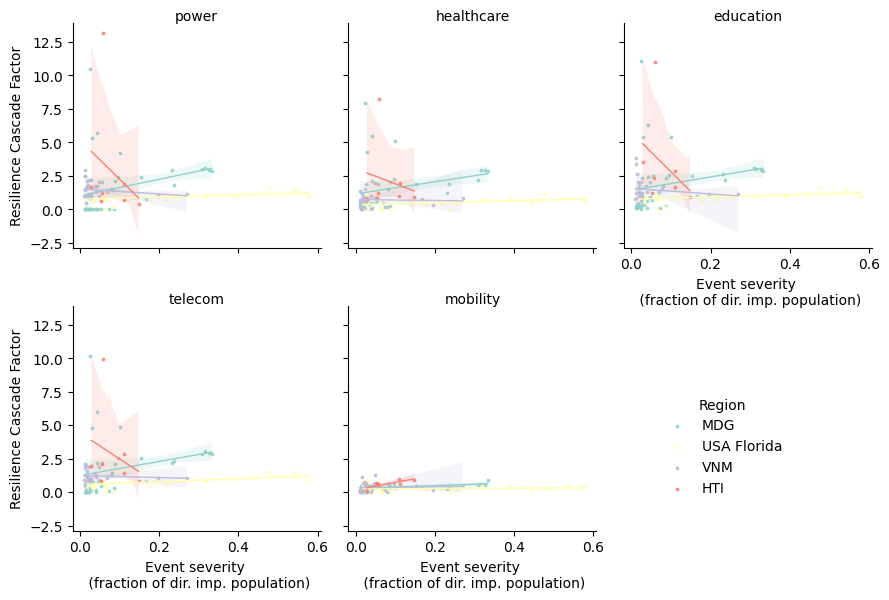

In [32]:
g = sns.lmplot(x='event_severity',y='resilience_casc_factor', col='service',
               data=df_long_1perc, fit_reg=True, height=3, facet_kws=dict(sharex=True, sharey=True),
               col_wrap=3, hue='iso3', legend=False, palette="Set3", 
               scatter_kws={"s": 3},
               line_kws={'linewidth':1})
#g.legend
legend = plt.legend(loc='lower right',bbox_to_anchor=(1.8,0.1), frameon=False)
legend.set_title('Region')

for i, ax in enumerate(g.axes):
    if i%3==0:
        ax.set_ylabel('Resilience Cascade Factor')
    ax.set_xlabel('Event severity \n (fraction of dir. imp. population)')
    ax.set_title(' '.join(ax.get_title().split(' ')[2:]), fontsize=10, pad=-18)
plt.savefig('/cluster/work/climate/evelynm/nw_outputs/comp_results/factor_a_vs_event_severity.png', dpi=300)


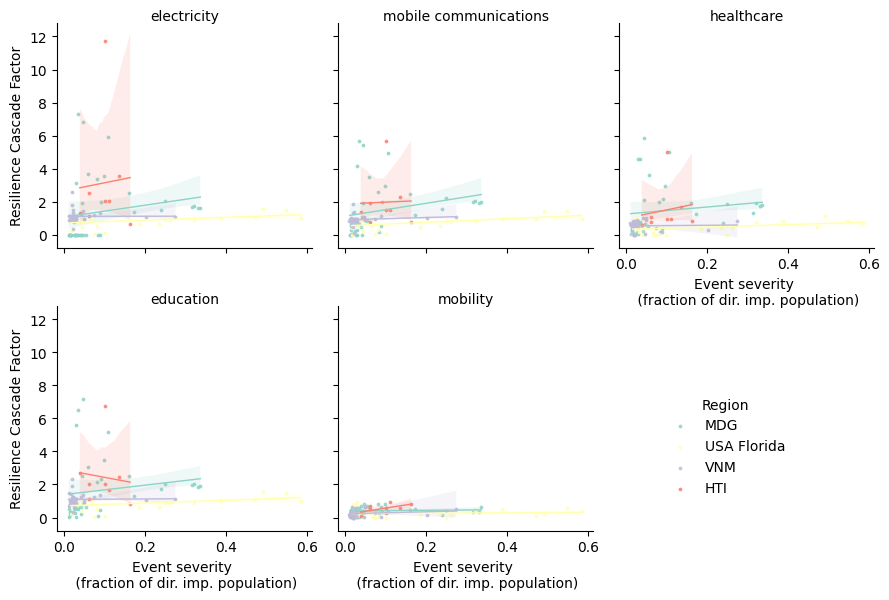

In [22]:
g = sns.lmplot(x='event_severity',y='resilience_casc_factor', col='service',
               data=df_long_1perc, fit_reg=True, height=3, facet_kws=dict(sharex=True, sharey=True),
               col_wrap=3, hue='iso3', legend=False, palette="Set3", 
               scatter_kws={"s": 3},
               line_kws={'linewidth':1})
#g.legend
legend = plt.legend(loc='lower right',bbox_to_anchor=(1.8,0.1), frameon=False)
legend.set_title('Region')

for i, ax in enumerate(g.axes):
    if i%3==0:
        ax.set_ylabel('Resilience Cascade Factor')
    ax.set_xlabel('Event severity \n (fraction of dir. imp. population)')
    ax.set_title(' '.join(ax.get_title().split(' ')[2:]), fontsize=10, pad=-18)
plt.savefig('/cluster/work/climate/evelynm/nw_outputs/comp_results/resilience_casc_vs_event_severity.png', dpi=300)

## Event severity vs. service disruption severity
(Taking directly affected population as event severity proxy)

In [71]:
disr_rate = af.load_disr_rate_allregs('TC')
destr_rate = af.load_dest_rate_allregs('TC')

### For 4 regions

In [16]:
def long_tidy_table_from_nested_dict(raw_data_dict, value_name):
    df_stacked = pd.DataFrame.from_dict(raw_data_dict).reset_index().rename({'index':'service'}, axis=1)
    df_long = df_stacked.melt(id_vars='service', var_name='event_id', 
                              value_name=value_name, ignore_index=True)
    df_long['event_severity']= df_long.apply(lambda row: df_stacked.iloc[5][row.event_id], axis=1)
    return df_long

In [10]:
iso3='MDG'
df_long_mdg_disr = long_tidy_table_from_nested_dict(disr_rate[iso3], 'disruption_rate')
df_long_mdg_disr['iso3'] = iso3

In [11]:
iso3='HTI'
df_long_hti_disr = long_tidy_table_from_nested_dict(disr_rate[iso3], 'disruption_rate')
df_long_hti_disr['iso3'] = iso3

In [12]:
iso3='VNM'
df_long_vnm_disr = long_tidy_table_from_nested_dict(disr_rate[iso3], 'disruption_rate')
df_long_vnm_disr['iso3'] = iso3

In [13]:
iso3='USA Florida'
df_long_usafl_disr = long_tidy_table_from_nested_dict(disr_rate[iso3], 'disruption_rate')
df_long_usafl_disr['iso3'] = iso3

In [14]:
# Filter out very small events (<1 % of population impacted)
df_disr_1perc = pd.concat([df_long_mdg_disr, df_long_usafl_disr, df_long_vnm_disr, df_long_hti_disr])
df_disr_1perc = df_disr_1perc.loc[df_disr_1perc.service!='people']
df_disr_1perc = df_disr_1perc[df_disr_1perc.event_severity>0.01]

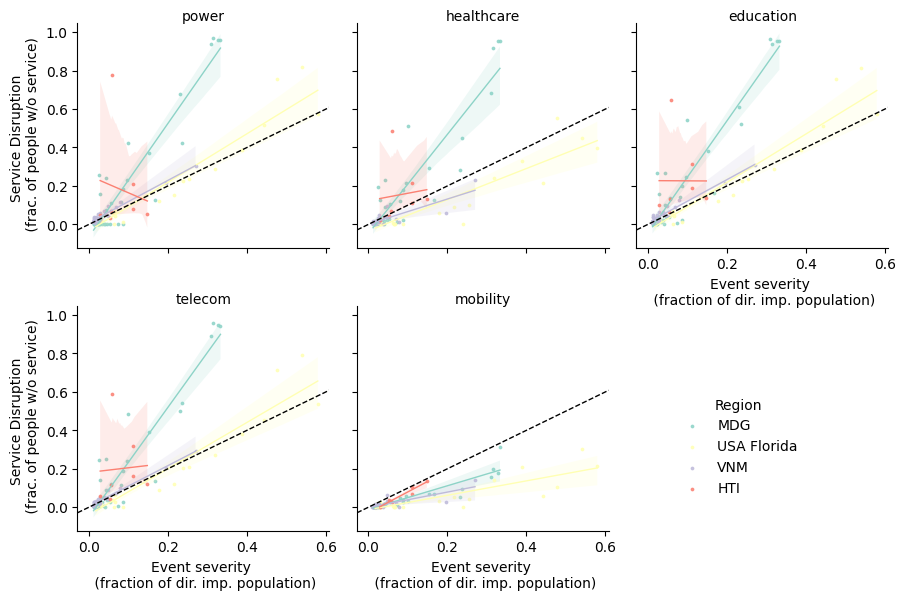

In [37]:
g = sns.lmplot(x='event_severity',y='disruption_rate', col='service',
               data=df_disr_1perc, fit_reg=True, height=3, facet_kws=dict(sharex=True, sharey=True),
               col_wrap=3, hue='iso3', legend=False, palette="Set3", 
               scatter_kws={"s": 3},
               line_kws={'linewidth':1})
#g.map(plt.axvline, x=10, color='k', linewidth=1)
legend = plt.legend(loc='lower right',bbox_to_anchor=(1.8,0.1), frameon=False)
legend.set_title('Region')

for i, ax in enumerate(g.axes):
    if i%3==0:
        ax.set_ylabel('Service Disruption \n (frac. of people w/o service)')
    ax.set_xlabel('Event severity \n (fraction of dir. imp. population)')
    ax.set_title(' '.join(ax.get_title().split(' ')[2:]), fontsize=10, pad=-18)
    ax.axline((0, 0), slope=1, linewidth=1, color='k', linestyle='--')
plt.savefig('/cluster/work/climate/evelynm/nw_outputs/comp_results/service_disr_vs_event_severity.png', dpi=300)

### For all regions -  TC

In [72]:
list_df_long = []
for reg, reg_dict in disr_rate_TC.items():
    df_cleaned = long_tidy_table_from_nested_dict(reg_dict, 'disruption_rate')
    df_cleaned['iso3'] = reg
    list_df_long.append(df_cleaned)

In [73]:
df_disr_1perc = pd.concat(list_df_long)
df_disr_1perc = df_disr_1perc.loc[df_disr_1perc.service!='people']
# Filter out very small events (<1 % of population impacted)
#df_disr_1perc = df_disr_1perc[df_disr_1perc.event_severity>0.01]
df_disr_1perc['geo_reg'] = df_disr_1perc.apply(lambda row: af.region_dict()[row.iso3], axis=1)
df_disr_1perc['inc_class'] = df_disr_1perc.apply(lambda row: af.inc_class_dict()[row.iso3], axis=1)
df_disr_1perc['island'] = df_disr_1perc.apply(lambda row: row.iso3 in ['ATG', 'CHN Hainan', 'CUB', 'HTI', 
                                                                      'LKA', 'MDG', 'PRI'], axis=1)
df_disr_1perc = df_disr_1perc.reset_index(drop=True)

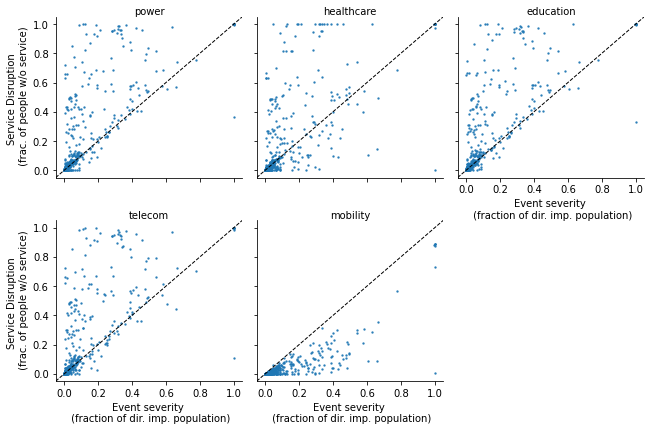

In [37]:
g = sns.lmplot(x='event_severity',y='disruption_rate', col='service',
               data=df_disr_1perc, fit_reg=False, height=3, facet_kws=dict(sharex=True, sharey=True),
               col_wrap=3, legend=False, palette="Set3", 
               scatter_kws={"s": 2}, line_kws={'linewidth':1}) #hue='iso3',
#legend = plt.legend(loc='lower right',bbox_to_anchor=(1.8,0.1), frameon=False)
#legend.set_title('Region')

for i, ax in enumerate(g.axes):
    if i%3==0:
        ax.set_ylabel('Service Disruption \n (frac. of people w/o service)')
    ax.set_xlabel('Event severity \n (fraction of dir. imp. population)')
    ax.set_title(' '.join(ax.get_title().split(' ')[2:]), fontsize=10, pad=-18)
    ax.axline((0, 0), slope=1, linewidth=1, color='k', linestyle='--')

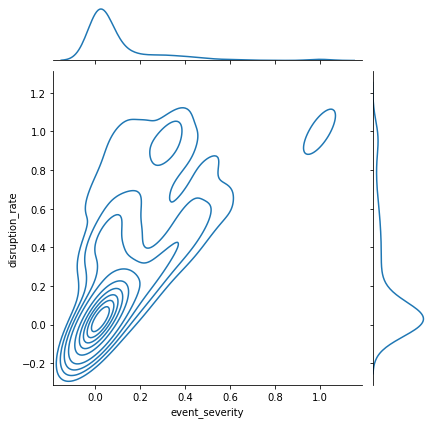

In [38]:
sns.jointplot(data=df_disr_1perc[df_disr_1perc.service=='power'], x="event_severity", y="disruption_rate",
               kind="kde")

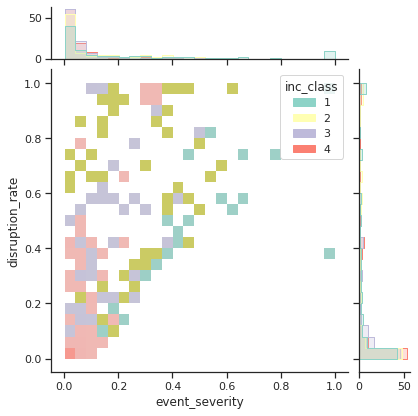

In [54]:
import seaborn as sns
sns.set_theme(style="ticks")

# Load the planets dataset and initialize the figure
g = sns.JointGrid(data=df_disr_1perc[df_disr_1perc.service=='power'], x="event_severity", y="disruption_rate", marginal_ticks=True,
                 hue='inc_class', palette="Set3")

# Set a log scaling on the y axis
# Add the joint and marginal histogram plots

g.plot_joint(sns.histplot, bins=25)#sns.scatterplot

g.plot_marginals(sns.histplot, element="step", stat='percent', common_norm=False, bins=25)

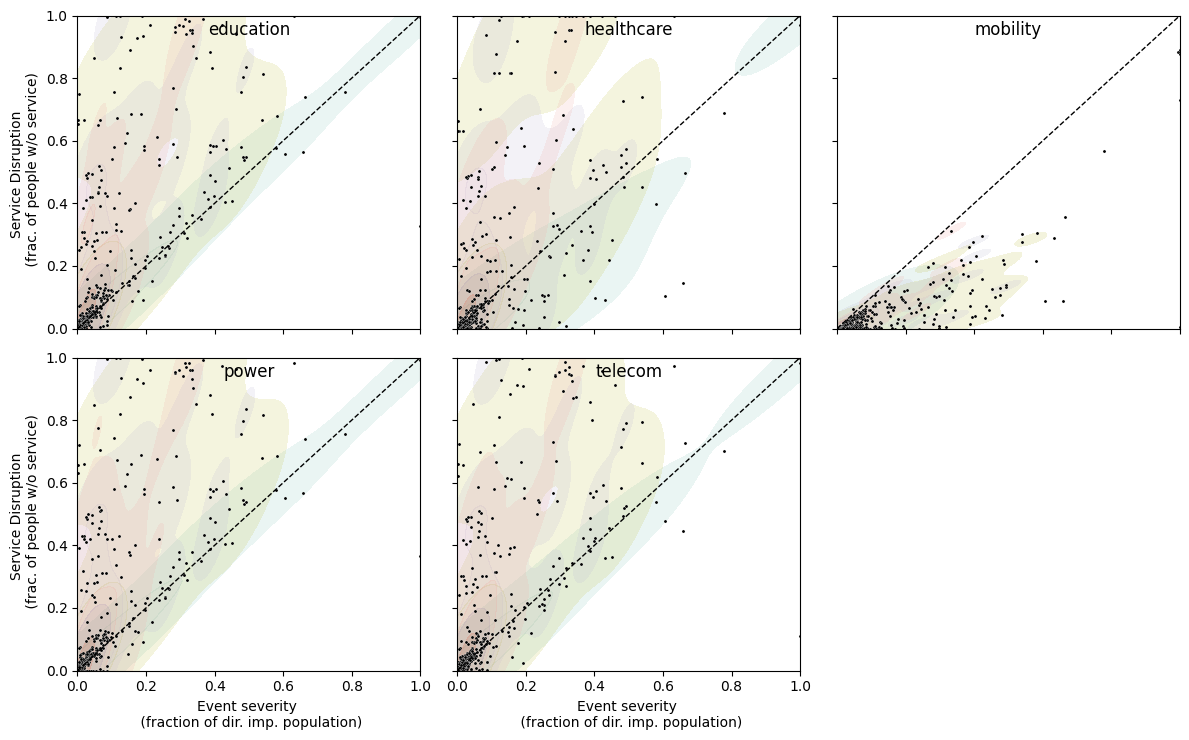

In [166]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,7.5))
axes = axes.flatten()
for ax, service in zip(axes, np.unique(df_disr_1perc.service)):
    sns.kdeplot(
        data=df_disr_1perc[df_disr_1perc.service==service], x="event_severity", y="disruption_rate", fill=True,levels=4,
        hue='inc_class', palette="Set3", alpha=0.2, legend=False,ax=ax)
    sns.scatterplot(data=df_disr_1perc[df_disr_1perc.service==service], x="event_severity", y="disruption_rate",
         alpha=1, s=5, legend=False,ax=ax, color='black') #hue='inc_class', palette="Set3",
    ax.set_title(service)
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])

for i, ax in enumerate(fig.axes):
    if i%3==0:
        ax.set_ylabel('Service Disruption \n (frac. of people w/o service)')
    ax.set_xlabel('Event severity \n (fraction of dir. imp. population)')
    #ax.set_title(' '.join(ax.get_title().split(' ')[2:]), fontsize=10, pad=-18)
    ax.axline((0, 0), slope=1, linewidth=1, color='k', linestyle='--')
    if i==5:
        fig.delaxes(ax)
fig.tight_layout()
    

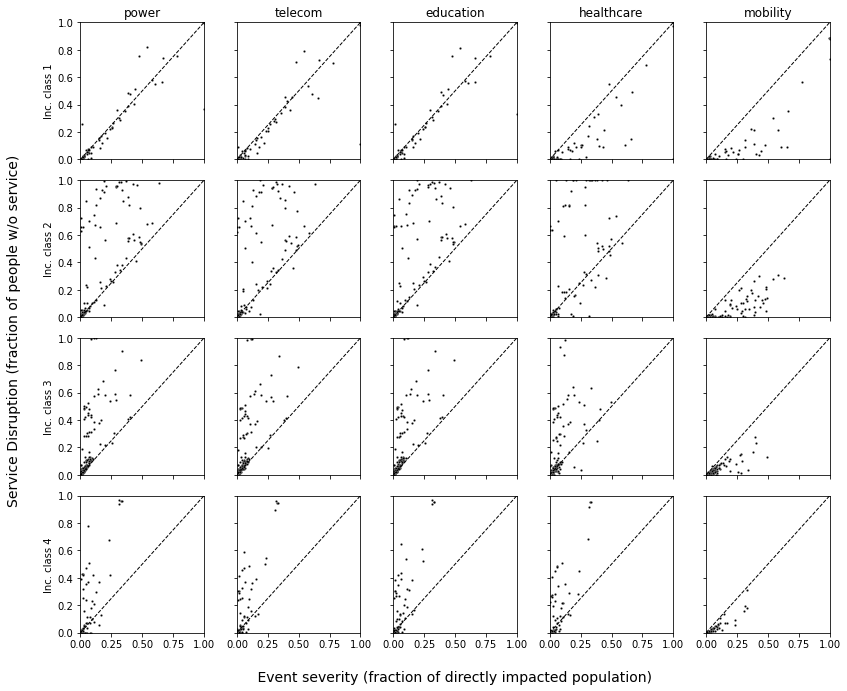

In [13]:
fig, axes = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(12.5,10))

for j, service in enumerate(['power', 'telecom', 'education', 'healthcare', 'mobility']):#np.unique(df_disr_1perc.service)
    for i, inc_class in enumerate(np.unique(df_disr_1perc.inc_class)):
        sns.scatterplot(data=df_disr_1perc[((df_disr_1perc.service==service)&(df_disr_1perc.inc_class==inc_class))],
                        x="event_severity", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[i,j], color='black')
        axes[i,j].set_ylim([0,1])
        axes[i,j].set_xlim([0,1])
        axes[i,j].set(xlabel=None, ylabel=None)
        axes[i,j].axline((0, 0), slope=1, linewidth=1, color='k', linestyle='--')
        if i==0:
            axes[i,j].set_title(service)
        if j==0:
            axes[i,j].set_ylabel(f'Inc. class {inc_class}')
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('\n Event severity (fraction of directly impacted population) ', fontsize=14)
plt.ylabel('Service Disruption (fraction of people w/o service) \n\n ', fontsize=14)
fig.tight_layout()


In [75]:
axes

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >], dtype=object)

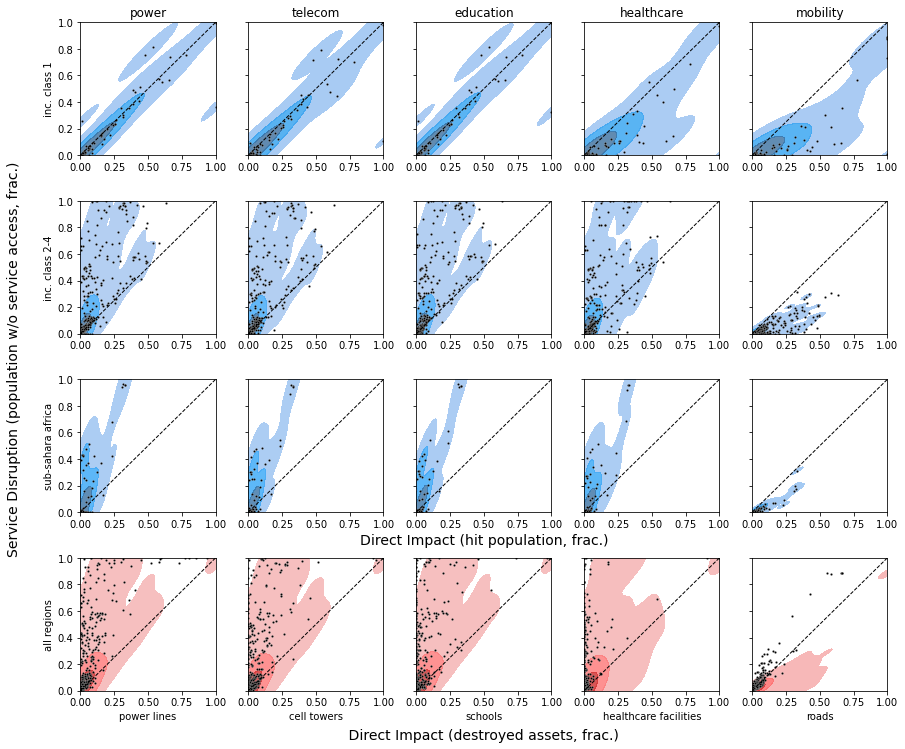

In [113]:
fig, axes = plt.subplots(4, 5, sharex=False, sharey=True, figsize=(13.3,11))

for j, service in enumerate(['power', 'telecom', 'education', 'healthcare', 'mobility']):#np.unique(df_disr_1perc.service)    
    
    i = 0
    sns.kdeplot(data=df_disr_1perc[((df_disr_1perc.service==service)&(df_disr_1perc.inc_class==1))],
                x="event_severity", y="disruption_rate", alpha=0.8, legend=False,ax=axes[i,j],
                fill=True,levels=4)
    sns.scatterplot(data=df_disr_1perc[((df_disr_1perc.service==service)&(df_disr_1perc.inc_class==1))],
                        x="event_severity", y="disruption_rate", alpha=1, s=5, 
                    legend=False,ax=axes[i,j], color='black')
    axes[i,j].set_title(service)
    i = 1
    sns.kdeplot(data=df_disr_1perc[((df_disr_1perc.service==service)&(df_disr_1perc.inc_class>1))],
                x="event_severity", y="disruption_rate", alpha=0.8, legend=False,ax=axes[i,j],
                fill=True,levels=4)  
    sns.scatterplot(data=df_disr_1perc[((df_disr_1perc.service==service)&(df_disr_1perc.inc_class>1))],
                        x="event_severity", y="disruption_rate", alpha=1, s=5, 
                    legend=False,ax=axes[i,j], color='black')
    i = 2
    sns.kdeplot(data=df_disr_1perc[((df_disr_1perc.service==service)&(df_disr_1perc.geo_reg=='SSA'))],
                x="event_severity", y="disruption_rate", alpha=0.8, legend=False,ax=axes[i,j],
                fill=True,levels=4) 
    sns.scatterplot(data=df_disr_1perc[((df_disr_1perc.service==service)&(df_disr_1perc.geo_reg=='SSA'))],
                        x="event_severity", y="disruption_rate", alpha=1, s=5, 
                    legend=False,ax=axes[i,j], color='black')
    i = 3
    sns.kdeplot(data=df_dest_disr_1perc[(df_dest_disr_1perc.service==service)],
                x="event_severity", y="disruption_rate", alpha=0.8, legend=False,ax=axes[i,j],
                fill=True,levels=4, color='red') 
    sns.scatterplot(data=df_dest_disr_1perc[(df_dest_disr_1perc.service==service)],
                    x="destruction_rate", y="disruption_rate", alpha=1, s=5, 
                    legend=False,ax=axes[i,j], color='black')    


for ax in axes.flatten():            
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])
    ax.set(xlabel=None, ylabel=None)
    ax.axline((0, 0), slope=1, linewidth=1, color='k', linestyle='--')

        
axes[0,0].set_ylabel('inc. class 1')
axes[1,0].set_ylabel('inc. class 2-4')
axes[2,0].set_ylabel('sub-sahara africa')
axes[3,0].set_ylabel('all regions')

for j, service in enumerate(['power', 'telecom', 'education', 'healthcare', 'mobility']):
    i=3
    axes[i,j].set_xlabel(f'{infra_renaming_dict[service]}')

axes[2,2].set_xlabel('Direct Impact (hit population, frac.)', fontsize=14)


fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('\n Direct Impact (destroyed assets, frac.) ', fontsize=14)
plt.ylabel('Service Disruption (population w/o service access, frac.) \n\n ', fontsize=14)

fig.tight_layout()
plt.savefig('/cluster/work/climate/evelynm/nw_outputs/comp_results/service_disr_vs_impacts_TC.png', dpi=300)

In [102]:
axes[2,2]

<AxesSubplot: xlabel='Direct Impact Severity (fraction of directly impacted population) '>

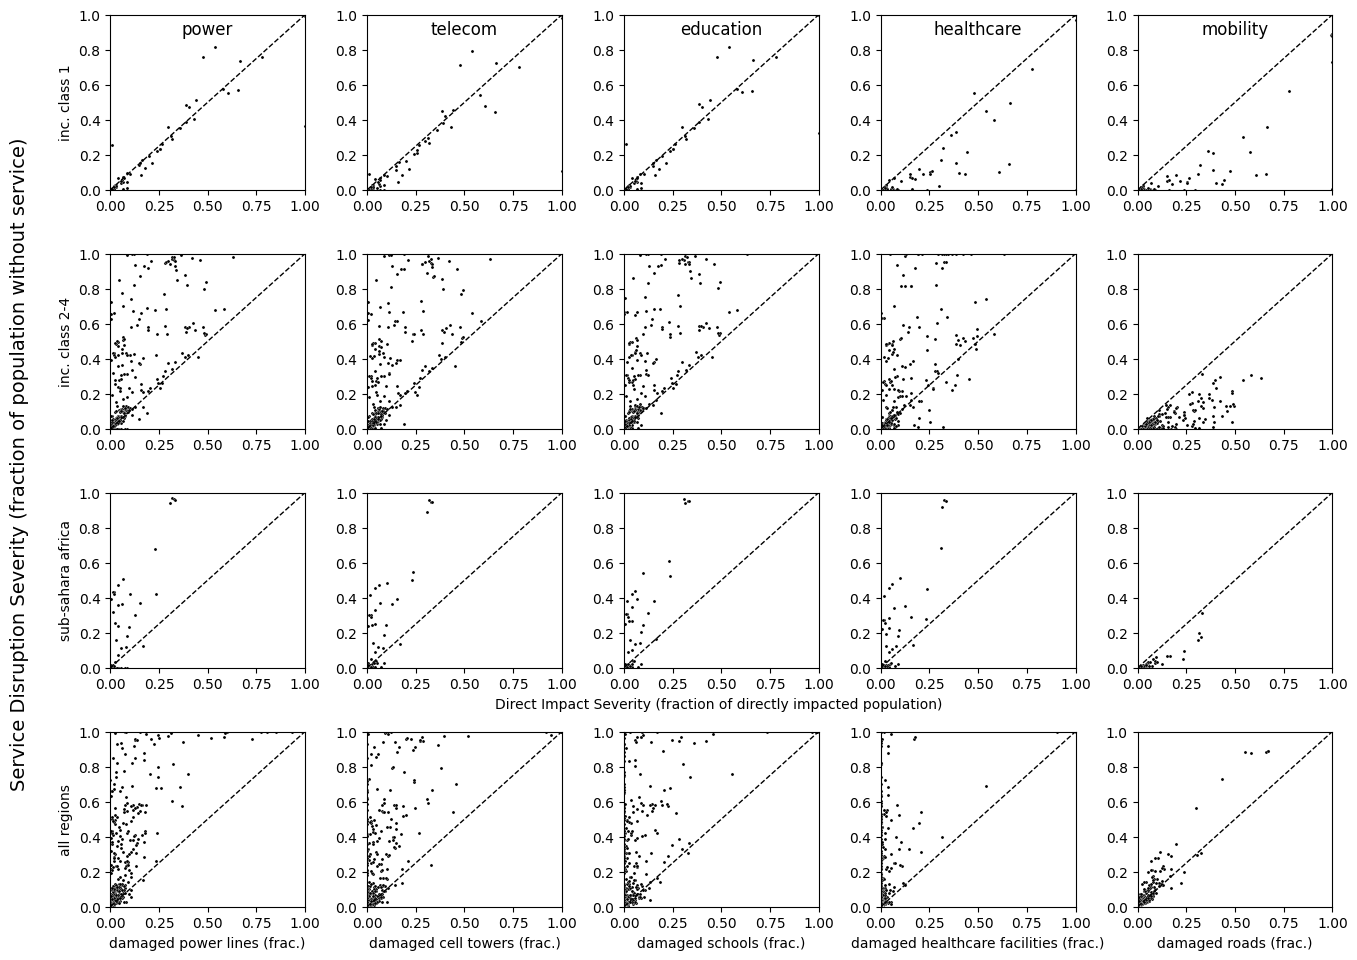

In [48]:
fig, axes = plt.subplots(4, 5, sharex=False, sharey=False, figsize=(14.3,10))

for j, service in enumerate(['power', 'telecom', 'education', 'healthcare', 'mobility']):#np.unique(df_disr_1perc.service)
    
    i = 0
    sns.scatterplot(data=df_disr_1perc[((df_disr_1perc.service==service)&(df_disr_1perc.inc_class==1))],
                        x="event_severity", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[i,j], color='black')
    axes[i,j].set_title(service)
    i = 1
    sns.scatterplot(data=df_disr_1perc[((df_disr_1perc.service==service)&(df_disr_1perc.inc_class>1))],
                        x="event_severity", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[i,j], color='black')
    i = 2
    sns.scatterplot(data=df_disr_1perc[((df_disr_1perc.service==service)&(df_disr_1perc.geo_reg=='SSA'))],
                        x="event_severity", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[i,j], color='black')
for j, service in enumerate(['power', 'telecom', 'education', 'healthcare', 'mobility']):#np.unique(df_disr_1perc.service)
    i = 3
    sns.scatterplot(data=df_dest_disr_1perc[(df_dest_disr_1perc.service==service)],
                        x="destruction_rate", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[i,j], color='black')    
for ax in axes.flatten():            
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])
    ax.set(xlabel=None, ylabel=None)
    ax.axline((0, 0), slope=1, linewidth=1, color='k', linestyle='--')

axes[2,2].set_xlabel('Direct Impact Severity (fraction of directly impacted population) ')

for j, service in enumerate(['power', 'telecom', 'education', 'healthcare', 'mobility']):#np.unique(df_disr_1perc.service)
    i=3
    axes[i,j].set_xlabel(f'damaged {infra_renaming_dict[service]} (frac.)')
    
axes[0,0].set_ylabel('inc. class 1')
axes[1,0].set_ylabel('inc. class 2-4')
axes[2,0].set_ylabel('sub-sahara africa')
axes[3,0].set_ylabel('all regions')

    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel('Service Disruption Severity (fraction of population without service) \n\n ', fontsize=14)
fig.tight_layout()
plt.savefig('/cluster/work/climate/evelynm/nw_outputs/comp_results/service_disr_vs_event_severity_vs_dest_TC.png', dpi=300)

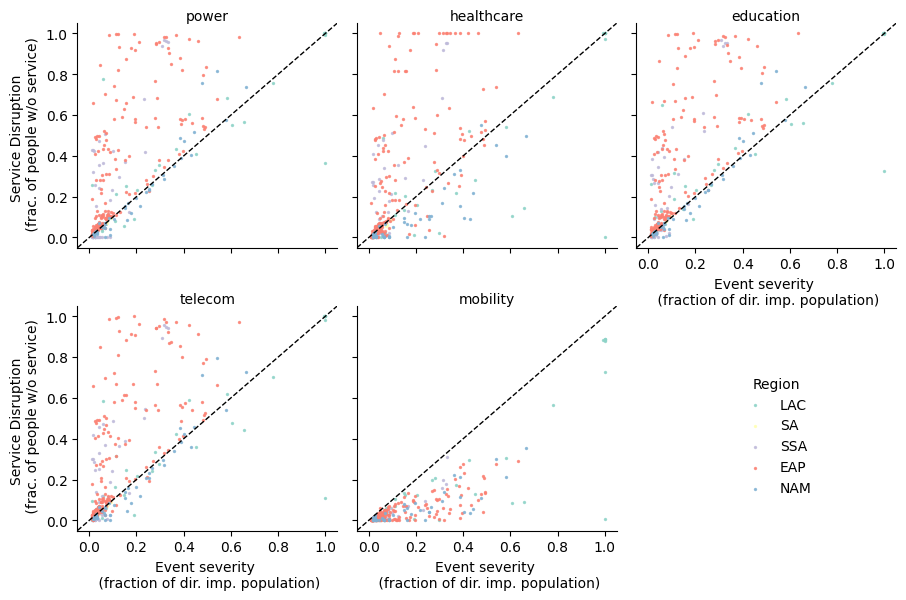

In [42]:
g = sns.lmplot(x='event_severity',y='disruption_rate', col='service',
               data=df_disr_1perc, fit_reg=False, height=3, facet_kws=dict(sharex=True, sharey=True),
               col_wrap=3, legend=False, palette="Set3", hue='geo_reg',
               scatter_kws={"s": 2}, line_kws={'linewidth':1}) #hue='iso3',
legend = plt.legend(loc='lower right',bbox_to_anchor=(1.8,0.1), frameon=False)
legend.set_title('Region')

for i, ax in enumerate(g.axes):
    if i%3==0:
        ax.set_ylabel('Service Disruption \n (frac. of people w/o service)')
    ax.set_xlabel('Event severity \n (fraction of dir. imp. population)')
    ax.set_title(' '.join(ax.get_title().split(' ')[2:]), fontsize=10, pad=-18)
    ax.axline((0, 0), slope=1, linewidth=1, color='k', linestyle='--')

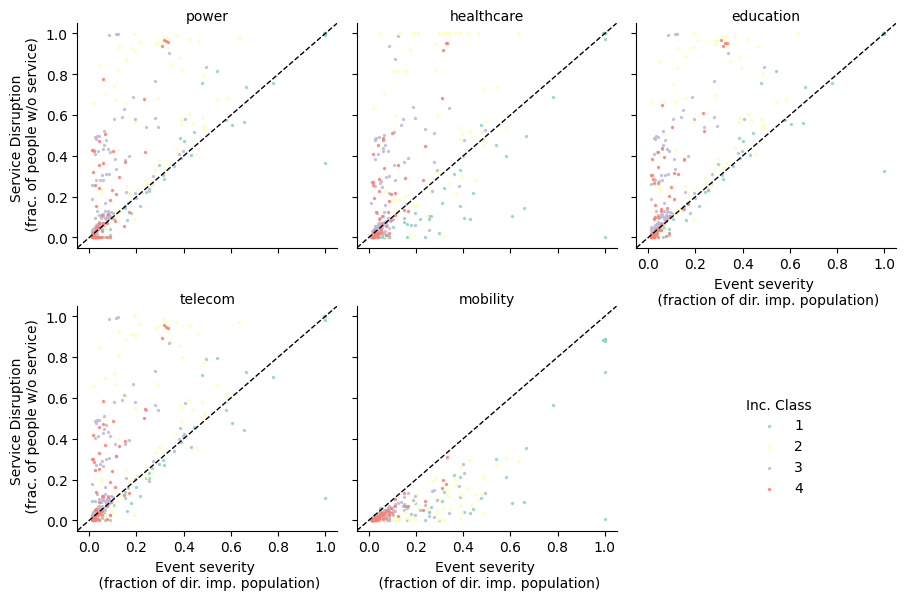

In [43]:
g = sns.lmplot(x='event_severity',y='disruption_rate', col='service',
               data=df_disr_1perc, fit_reg=False, height=3, facet_kws=dict(sharex=True, sharey=True),
               col_wrap=3, legend=False, palette="Set3", hue='inc_class',
               scatter_kws={"s": 2}, line_kws={'linewidth':1})
legend = plt.legend(loc='lower right',bbox_to_anchor=(1.8,0.1), frameon=False)
legend.set_title('Inc. Class')

for i, ax in enumerate(g.axes):
    if i%3==0:
        ax.set_ylabel('Service Disruption \n (frac. of people w/o service)')
    ax.set_xlabel('Event severity \n (fraction of dir. imp. population)')
    ax.set_title(' '.join(ax.get_title().split(' ')[2:]), fontsize=10, pad=-18)
    ax.axline((0, 0), slope=1, linewidth=1, color='k', linestyle='--')
    


### For all regions -  FL

In [38]:
list_df_long = []
for reg, reg_dict in disr_rate_FL.items():
    df_cleaned = long_tidy_table_from_nested_dict(reg_dict, 'disruption_rate')
    df_cleaned['iso3'] = reg
    list_df_long.append(df_cleaned)
df_disr = pd.concat(list_df_long)

#df_disr['geo_reg'] = df_disr.apply(lambda row: af.region_dict()[row.iso3], axis=1)
#df_disr['inc_class'] = df_disr.apply(lambda row: af.inc_class_dict()[row.iso3], axis=1)
df_disr = df_disr.loc[df_disr.service!='people']
df_disr = df_disr.reset_index(drop=True)    
    

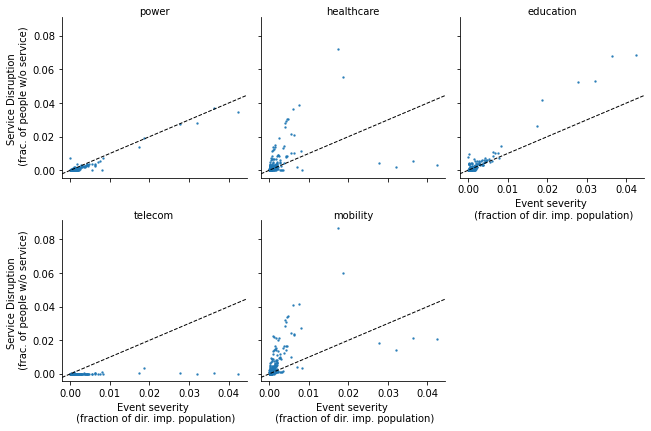

In [39]:
g = sns.lmplot(x='event_severity',y='disruption_rate', col='service',
               data=df_disr, fit_reg=False, height=3, facet_kws=dict(sharex=True, sharey=True),
               col_wrap=3, legend=False, palette="Set3", 
               scatter_kws={"s": 2}, line_kws={'linewidth':1}) #hue='iso3',
#legend = plt.legend(loc='lower right',bbox_to_anchor=(1.8,0.1), frameon=False)
#legend.set_title('Region')

for i, ax in enumerate(g.axes):
    if i%3==0:
        ax.set_ylabel('Service Disruption \n (frac. of people w/o service)')
    ax.set_xlabel('Event severity \n (fraction of dir. imp. population)')
    ax.set_title(' '.join(ax.get_title().split(' ')[2:]), fontsize=10, pad=-18)
    ax.axline((0, 0), slope=1, linewidth=1, color='k', linestyle='--')

## Infrastructure damage vs. service disruption severity
(Taking infrastructure-specific disruption rate vs. destruction rate))

In [34]:
disr_rate = af.load_disr_rate_allregs('TC')
dest_rate = af.load_dest_rate_allregs('TC')

In [98]:
infra_renaming_dict = {
    'power' : 'power lines',
    'healthcare' : 'healthcare facilities',
    'education' : 'schools',
    'telecom' : 'cell towers',
    'mobility' : 'roads',
    'mobile communications': 'cell towers',
}

### For 4 regions

In [17]:
# Haiti
# reorder one dict to have the same key-order as the other one
iso3='HTI'
keys_ordered = list(disr_rate[iso3].keys())
reordered_dict = {k: dest_rate[iso3][k] for k in keys_ordered}
df_long_hti_disr = long_tidy_table_from_nested_dict(disr_rate[iso3], 'disruption_rate')
df_long_hti_disr['iso3'] = iso3
df_long_hti_dest = long_tidy_table_from_nested_dict(reordered_dict, 'destruction_rate')
df_long_hti_disr['destruction_rate'] = df_long_hti_dest['destruction_rate']/100

In [18]:
# Madagascar
iso3='MDG'
keys_ordered = list(disr_rate[iso3].keys())
reordered_dict = {k: dest_rate[iso3][k] for k in keys_ordered}
df_long_mdg_disr = long_tidy_table_from_nested_dict(disr_rate[iso3], 'disruption_rate')
df_long_mdg_disr['iso3'] = iso3
df_long_mdg_dest = long_tidy_table_from_nested_dict(reordered_dict, 'destruction_rate')
df_long_mdg_disr['destruction_rate'] = df_long_mdg_dest['destruction_rate']/100

In [19]:
# USA Florida
iso3='USA Florida'
keys_ordered = list(disr_rate[iso3].keys())
reordered_dict = {k: dest_rate[iso3][k] for k in keys_ordered}
df_long_usafl_disr = long_tidy_table_from_nested_dict(disr_rate[iso3], 'disruption_rate')
df_long_usafl_disr['iso3'] = iso3
df_long_usafl_dest = long_tidy_table_from_nested_dict(reordered_dict, 'destruction_rate')
df_long_usafl_disr['destruction_rate'] = df_long_usafl_dest['destruction_rate']/100

In [20]:
# Viet Nam
iso3='VNM'
keys_ordered = list(disr_rate[iso3].keys())
reordered_dict = {k: dest_rate[iso3][k] for k in keys_ordered}
df_long_vnm_disr = long_tidy_table_from_nested_dict(disr_rate[iso3], 'disruption_rate')
df_long_vnm_disr['iso3'] = iso3
df_long_vnm_dest = long_tidy_table_from_nested_dict(reordered_dict, 'destruction_rate')
df_long_vnm_disr['destruction_rate'] = df_long_vnm_dest['destruction_rate']/100

In [21]:
df_disr_destr_1perc = pd.concat([df_long_mdg_disr, df_long_usafl_disr, df_long_vnm_disr, df_long_hti_disr])
df_disr_destr_1perc = df_disr_destr_1perc.loc[df_disr_destr_1perc.service!='people']
df_disr_destr_1perc = df_disr_destr_1perc[df_disr_destr_1perc.event_severity>0.01]
df_disr_destr_1perc.loc[df_disr_destr_1perc.service=='telecom','service'] = 'mobile communications'

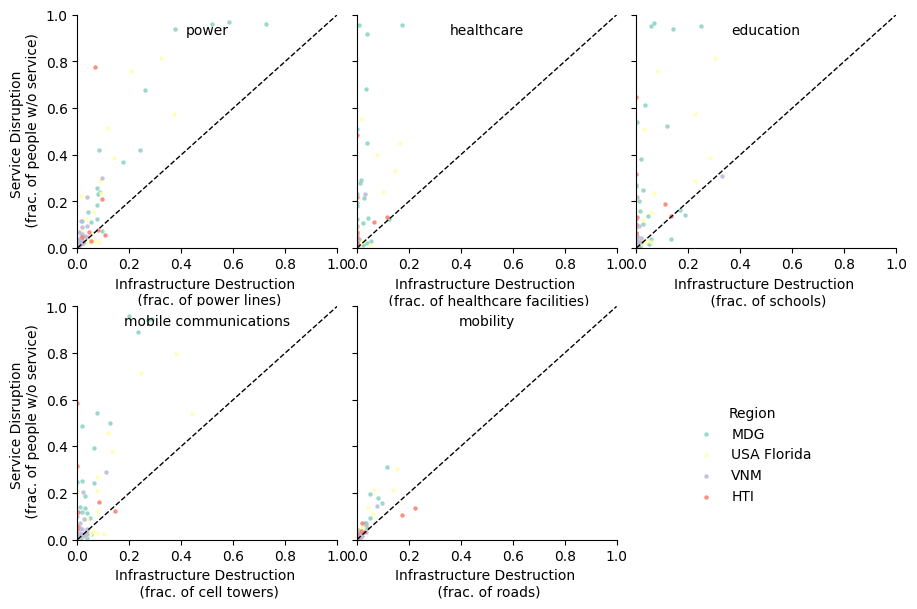

In [27]:
g = sns.lmplot(x='destruction_rate',y='disruption_rate', col='service',
               data=df_disr_destr_1perc, fit_reg=False, height=3, facet_kws=dict(sharex=False, sharey=True),
               col_wrap=3, hue='iso3', legend=False, palette="Set3", 
               scatter_kws={"s": 5}, ci=None,
               line_kws={'linewidth':1})
#g.map(plt.axvline, x=10, color='k', linewidth=1)
legend = plt.legend(loc='lower right',bbox_to_anchor=(1.8,0.1), frameon=False)
legend.set_title('Region')

for i, ax in enumerate(g.axes):
    if i%3==0:
        ax.set_ylabel('Service Disruption \n (frac. of people w/o service)')
    service = ' '.join(ax.get_title().split(' ')[2:])
    ax.set_xlabel(f'Infrastructure Destruction \n (frac. of {infra_renaming_dict[service]})')
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])
    ax.axline((0, 0), slope=1, linewidth=1, color='k', linestyle='--')
    plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
    plt.rcParams['axes.titlepad'] = -14
    ax.set_title(service, fontsize=10)
    
plt.savefig('/cluster/work/climate/evelynm/nw_outputs/comp_results/service_disr_vs_infra_dest.png', dpi=300)

### For all regions - TC

In [77]:
list_df_long = []
for reg, reg_dict in destr_rate_TC.items():
    df_cleaned = long_tidy_table_from_nested_dict(reg_dict, 'destruction_rate')
    df_cleaned['iso3'] = reg
    list_df_long.append(df_cleaned)

In [78]:
df_dest_1perc = pd.concat(list_df_long)
df_dest_1perc = df_dest_1perc.loc[df_dest_1perc.service!='people']
df_dest_1perc = df_dest_1perc.reset_index(drop=True)

In [79]:
rename_dict = {'power_line':'power',
              'celltower':'telecom',
              'road':'mobility',
               'education':'education',
              'health':'healthcare'}
df_dest_1perc['service'] = df_dest_1perc.apply(lambda row: rename_dict[row.service], axis=1)

In [80]:
df_dest_disr_1perc = pd.merge(
    df_dest_1perc,
    df_disr_1perc,
    how="inner",
    on=['service', 'event_id', 'iso3'])
df_dest_disr_1perc['event_severity'] = df_dest_disr_1perc.event_severity_y
df_dest_disr_1perc['destruction_rate']/=100
df_dest_disr_1perc = df_dest_disr_1perc.drop(['event_severity_x', 'event_severity_y'], axis=1)

In [21]:
#df_dest_disr_1perc = df_dest_disr_1perc[df_dest_disr_1perc.event_severity>0.01]

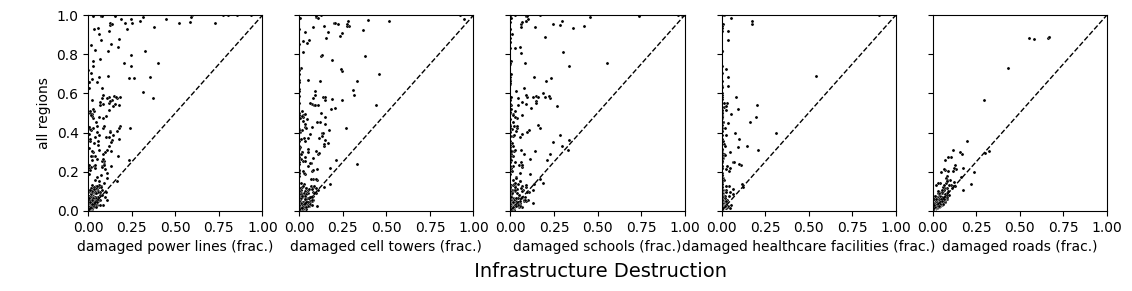

In [37]:
fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(12,3.5))

for j, service in enumerate(['power', 'telecom', 'education', 'healthcare', 'mobility']):#np.unique(df_disr_1perc.service)
    sns.scatterplot(data=df_dest_disr_1perc[(df_dest_disr_1perc.service==service)],
                        x="destruction_rate", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[j], color='black')    
for ax in axes.flatten():            
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])
    ax.set(xlabel=None, ylabel=None)
    ax.axline((0, 0), slope=1, linewidth=1, color='k', linestyle='--')

axes[0].set_ylabel('all regions')

for j, service in enumerate(['power', 'telecom', 'education', 'healthcare', 'mobility']):#np.unique(df_disr_1perc.service)
    axes[j].set_xlabel(f'damaged {infra_renaming_dict[service]} (frac.)')
    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('\n Infrastructure Destruction', fontsize=14)
plt.ylabel('\n  ', fontsize=14)

fig.tight_layout()

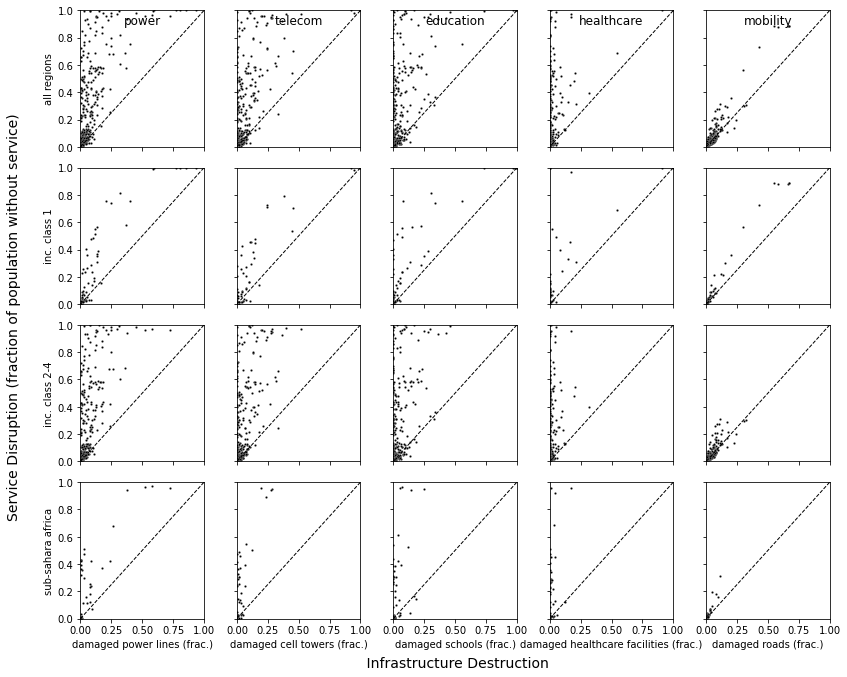

In [111]:
fig, axes = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(12.5,10))

for j, service in enumerate(['power', 'telecom', 'education', 'healthcare', 'mobility']):#np.unique(df_disr_1perc.service)
    i = 0
    sns.scatterplot(data=df_dest_disr_1perc[(df_dest_disr_1perc.service==service)],
                        x="destruction_rate", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[i,j], color='black')
    axes[i,j].set_title(service)
    
    i = 1
    sns.scatterplot(data=df_dest_disr_1perc[((df_dest_disr_1perc.service==service)&(df_dest_disr_1perc.inc_class==1))],
                        x="destruction_rate", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[i,j], color='black')
    i = 2
    sns.scatterplot(data=df_dest_disr_1perc[((df_dest_disr_1perc.service==service)&(df_dest_disr_1perc.inc_class>1))],
                        x="destruction_rate", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[i,j], color='black')
    i = 3
    sns.scatterplot(data=df_dest_disr_1perc[((df_dest_disr_1perc.service==service)&(df_dest_disr_1perc.geo_reg=='SSA'))],
                        x="destruction_rate", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[i,j], color='black')
    
for ax in axes.flatten():            
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])
    ax.set(xlabel=None, ylabel=None)
    ax.axline((0, 0), slope=1, linewidth=1, color='k', linestyle='--')

axes[0,0].set_ylabel('all regions')
axes[1,0].set_ylabel('inc. class 1')
axes[2,0].set_ylabel('inc. class 2-4')
axes[3,0].set_ylabel('sub-sahara africa')

for j, service in enumerate(['power', 'telecom', 'education', 'healthcare', 'mobility']):#np.unique(df_disr_1perc.service)
    axes[3,j].set_xlabel(f'damaged {infra_renaming_dict[service]} (frac.)')
#axes[3,1].set_xlabel('inc. class 1')
#axes[3,2].set_xlabel('inc. class 2-4')
#axes[3,3].set_xlabel('sub-sahara africa')
#axes[3,4].set_xlabel('sub-sahara africa')
    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('\n Infrastructure Destruction', fontsize=14)
plt.ylabel('Service Disruption (fraction of population without service) \n\n ', fontsize=14)
fig.tight_layout()

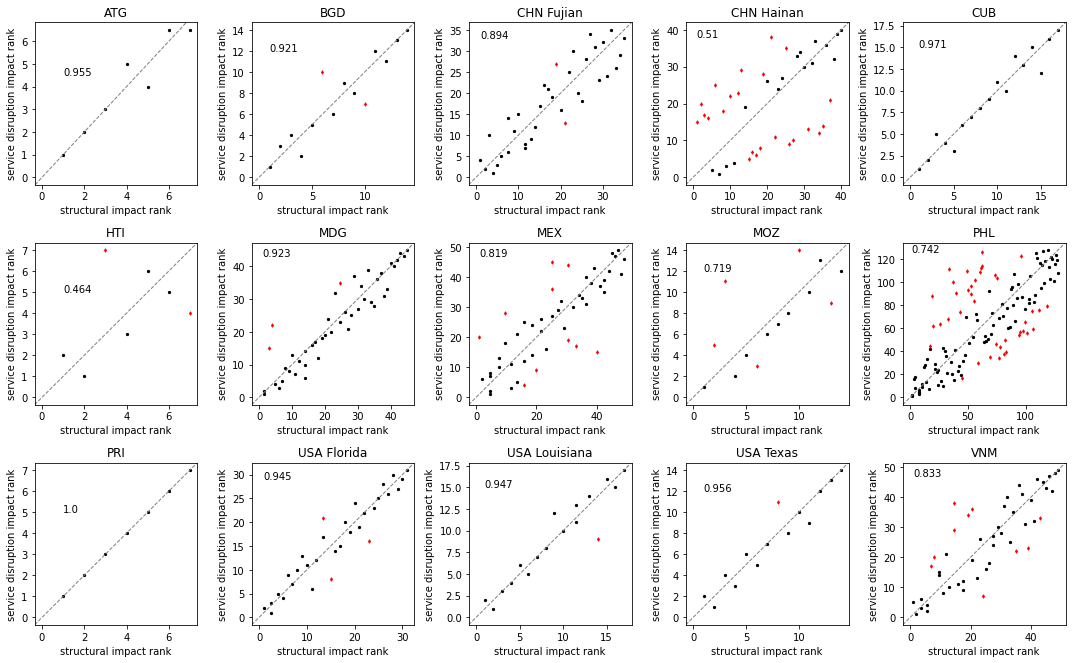

In [14]:
fig, axes = plt.subplots(5,5,figsize=(15,15))
axes = axes.flatten()
num_regs = 0
valid_regs = [reg for reg in disr_rate_TC.keys() if len(disr_rate_TC[reg].keys())>2]

for iso3, ax in zip(valid_regs, axes):
        num_regs+=1
        spearmanr_res, ranklist = af.compare_impact_rankings(disr_rate_TC[iso3], destr_rate_TC[iso3])
        outliers = np.abs(ranklist[1]-ranklist[0])/len(ranklist[1])>0.2
        ax.scatter(ranklist[1][~outliers], ranklist[0][~outliers], color='k', s=5)
        ax.scatter(ranklist[1][outliers], ranklist[0][outliers], color='r', s=5, marker='d')
        ax.set_title(f"{iso3}")
        ax.set_xlabel("structural impact rank")
        ax.set_ylabel("service disruption impact rank")
        ax.axline((min(ranklist[0])-1, min(ranklist[0])-1), slope=1, linewidth=1, color='gray', linestyle='--')
        if not np.isnan(spearmanr_res[0]):
            ax.text(min(ranklist[0]), max(ranklist[0]-2), f'{np.round(spearmanr_res[0], 3)}')
        #for i, txt in enumerate(event_names):
        #    ax.annotate(txt, (ranklist[1][i]-1, ranklist[0][i]+0.3))
for ax in axes[num_regs:]:
    fig.delaxes(ax)
fig.tight_layout()
plt.show()

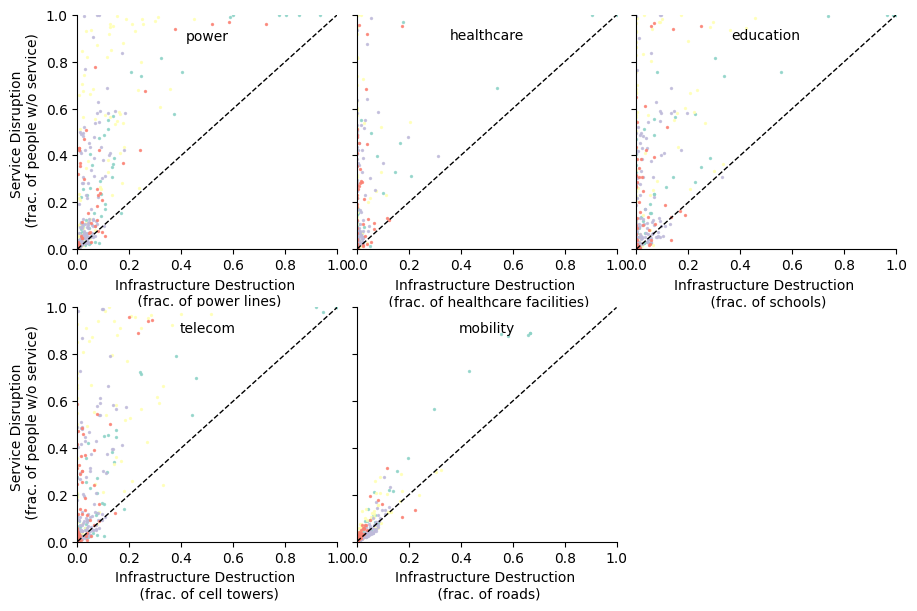

In [164]:
g = sns.lmplot(x='destruction_rate',y='disruption_rate', col='service',
               data=df_dest_disr_1perc, fit_reg=False, height=3, facet_kws=dict(sharex=False, sharey=True),
               col_wrap=3, legend=False, palette="Set3", 
               scatter_kws={"s": 2}, line_kws={'linewidth':1}, hue='inc_class') #hue='iso3',
#legend = plt.legend(loc='lower right',bbox_to_anchor=(1.8,0.1), frameon=False)
#legend.set_title('Region')

for i, ax in enumerate(g.axes):
    ax.set_ylabel('Service Disruption \n (frac. of people w/o service)')
    service = ' '.join(ax.get_title().split(' ')[2:])
    plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
    plt.rcParams['axes.titlepad'] = -14
    ax.set_title(' '.join(ax.get_title().split(' ')[2:]), fontsize=10, pad=-18)
    ax.axline((0, 0), slope=1, linewidth=1, color='k', linestyle='--')
    ax.set_xlabel(f'Infrastructure Destruction \n (frac. of {infra_renaming_dict[service]})')
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])

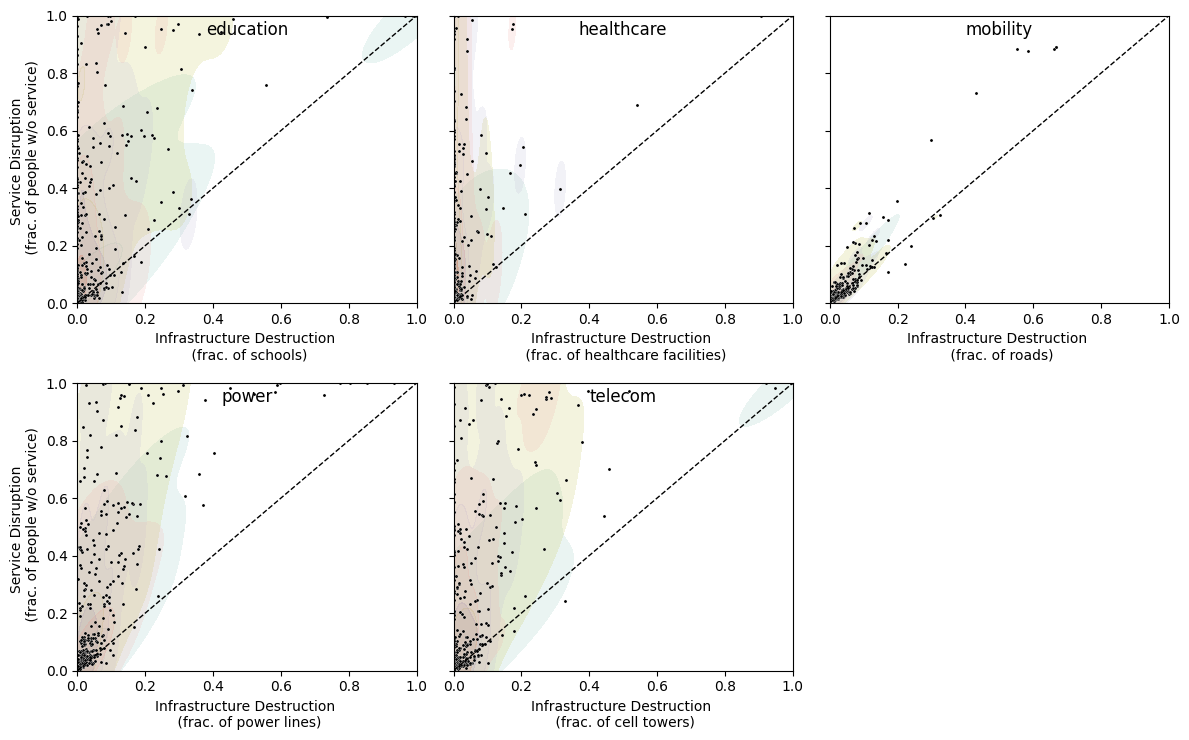

In [165]:
fig, axes = plt.subplots(2, 3, sharex=False, sharey=True, figsize=(12,7.5))
axes = axes.flatten()
for ax, service in zip(axes, np.unique(df_dest_disr_1perc.service)):
    sns.kdeplot(
        data=df_dest_disr_1perc[df_dest_disr_1perc.service==service], x="destruction_rate", y="disruption_rate", fill=True,levels=4,
        hue='inc_class', palette="Set3", alpha=0.2, legend=False,ax=ax)
    sns.scatterplot(data=df_dest_disr_1perc[df_dest_disr_1perc.service==service], x="destruction_rate", y="disruption_rate",
         alpha=1, s=5, legend=False,ax=ax, color='black') #hue='inc_class', palette="Set3",
    ax.set_title(service)
    
    ax.set_ylabel('Service Disruption \n (frac. of people w/o service)')
    plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
    plt.rcParams['axes.titlepad'] = -14
    #ax.set_title(' '.join(ax.get_title().split(' ')[2:]), fontsize=10, pad=-18)
    ax.axline((0, 0), slope=1, linewidth=1, color='k', linestyle='--')
    ax.set_xlabel(f'Infrastructure Destruction \n (frac. of {infra_renaming_dict[service]})')
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])
fig.delaxes(axes[-1])
fig.tight_layout()

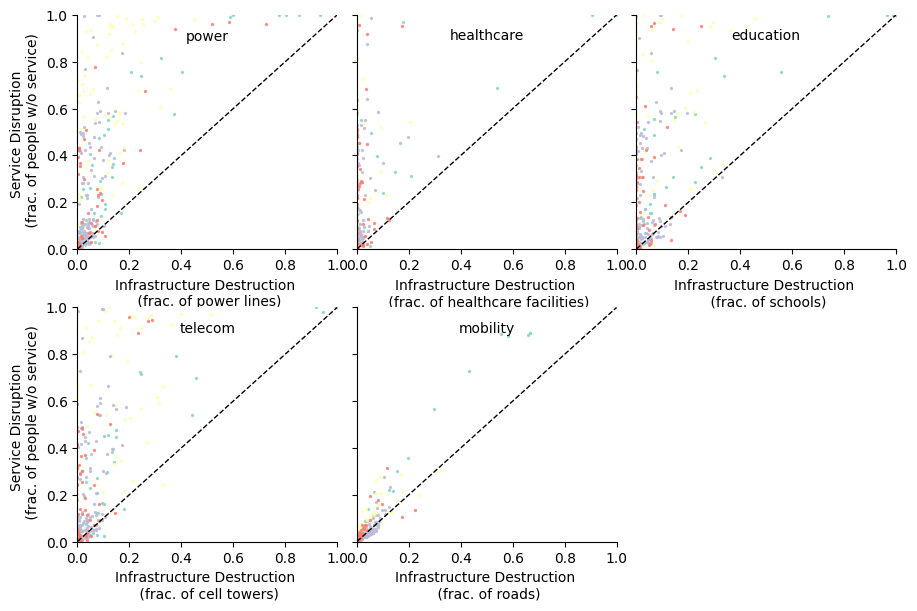

In [154]:
g = sns.lmplot(x='destruction_rate',y='disruption_rate', col='service',
               data=df_dest_disr_1perc, fit_reg=False, height=3, facet_kws=dict(sharex=False, sharey=True),
               col_wrap=3, legend=False, palette="Set3", hue='inc_class',
               scatter_kws={"s": 2}, line_kws={'linewidth':1}) #hue='iso3',
#legend = plt.legend(loc='lower right',bbox_to_anchor=(1.8,0.1), frameon=False)
#legend.set_title('Region')

for i, ax in enumerate(g.axes):
    ax.set_ylabel('Service Disruption \n (frac. of people w/o service)')
    service = ' '.join(ax.get_title().split(' ')[2:])
    plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
    plt.rcParams['axes.titlepad'] = -14
    ax.set_title(' '.join(ax.get_title().split(' ')[2:]), fontsize=10, pad=-18)
    ax.axline((0, 0), slope=1, linewidth=1, color='k', linestyle='--')
    ax.set_xlabel(f'Infrastructure Destruction \n (frac. of {infra_renaming_dict[service]})')
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])

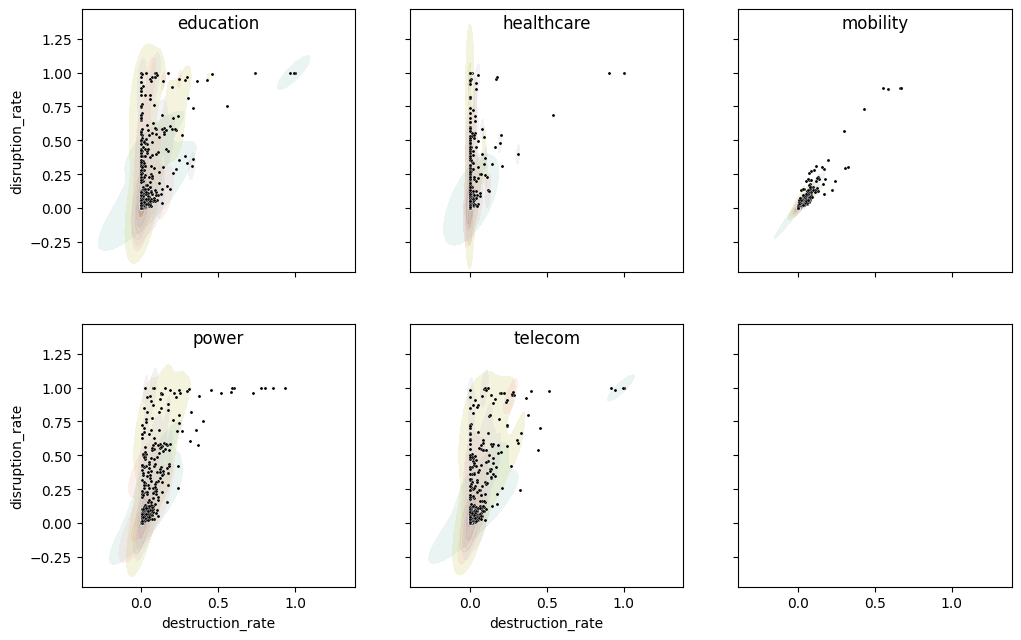

In [148]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,7.5))
axes = axes.flatten()
for ax, service in zip(axes, np.unique(df_dest_disr_1perc.service)):
    sns.kdeplot(
        data=df_dest_disr_1perc[df_dest_disr_1perc.service==service], x="destruction_rate", y="disruption_rate", fill=True,levels=4,
        hue='inc_class', palette="Set3", alpha=0.2, legend=False,ax=ax)
    sns.scatterplot(data=df_dest_disr_1perc[df_dest_disr_1perc.service==service], x="destruction_rate", y="disruption_rate",
         alpha=1, s=5, legend=False,ax=ax, color='black') #hue='inc_class', palette="Set3",
    ax.set_title(service)
    
    

### For all regions - FL

In [10]:
list_df_long = []
for reg, reg_dict in disr_rate_FL.items():
    df_cleaned = long_tidy_table_from_nested_dict(reg_dict, 'disruption_rate')
    df_cleaned['iso3'] = reg
    list_df_long.append(df_cleaned)

df_disr = pd.concat(list_df_long)
df_disr = df_disr.loc[df_disr.service!='people']
df_disr['geo_reg'] = df_disr.apply(lambda row: af.region_dict()[row.iso3], axis=1)
df_disr['inc_class'] = df_disr.apply(lambda row: af.inc_class_dict()[row.iso3], axis=1)
df_disr = df_disr.reset_index(drop=True)

In [11]:
list_df_long = []
for reg, reg_dict in destr_rate_FL.items():
    df_cleaned = long_tidy_table_from_nested_dict(reg_dict, 'destruction_rate')
    df_cleaned['iso3'] = reg
    list_df_long.append(df_cleaned)
df_dest = pd.concat(list_df_long)

#df_disr['geo_reg'] = df_disr.apply(lambda row: af.region_dict()[row.iso3], axis=1)
#df_disr['inc_class'] = df_disr.apply(lambda row: af.inc_class_dict()[row.iso3], axis=1)
df_dest = df_dest.loc[df_dest.service!='people']
df_dest = df_dest.reset_index(drop=True)    
rename_dict = {'power_line':'power',
              'celltower':'telecom',
              'road':'mobility',
               'education':'education',
              'health':'healthcare'}
df_dest['service'] = df_dest.apply(lambda row: rename_dict[row.service], axis=1) 

In [12]:
df_dest_disr = pd.merge(
    df_dest,
    df_disr,
    how="inner",
    on=['service', 'event_id', 'iso3'])
df_dest_disr['event_severity'] = df_dest_disr.event_severity_y
df_dest_disr['destruction_rate']/=100
df_dest_disr = df_dest_disr.drop(['event_severity_x', 'event_severity_y'], axis=1)

NameError: name 'infra_renaming_dict' is not defined

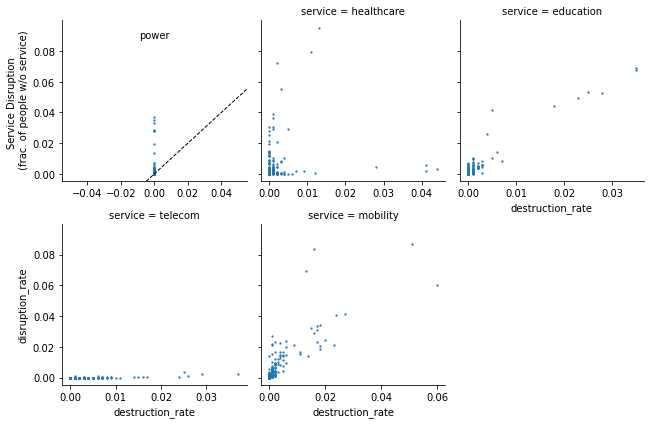

In [13]:
g = sns.lmplot(x='destruction_rate',y='disruption_rate', col='service',
               data=df_dest_disr, fit_reg=False, height=3, facet_kws=dict(sharex=False, sharey=True),
               col_wrap=3, legend=False, palette="Set3", 
               scatter_kws={"s": 2}, line_kws={'linewidth':1}) #hue='iso3',
#legend = plt.legend(loc='lower right',bbox_to_anchor=(1.8,0.1), frameon=False)
#legend.set_title('Region')

for i, ax in enumerate(g.axes):
    ax.set_ylabel('Service Disruption \n (frac. of people w/o service)')
    service = ' '.join(ax.get_title().split(' ')[2:])
    plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
    plt.rcParams['axes.titlepad'] = -14
    ax.set_title(' '.join(ax.get_title().split(' ')[2:]), fontsize=10, pad=-18)
    ax.axline((0, 0), slope=1, linewidth=1, color='k', linestyle='--')
    ax.set_xlabel(f'Infrastructure Destruction \n (frac. of {infra_renaming_dict[service]})')
    ax.set_ylim([0,0.1])
    ax.set_xlim([0,0.1])

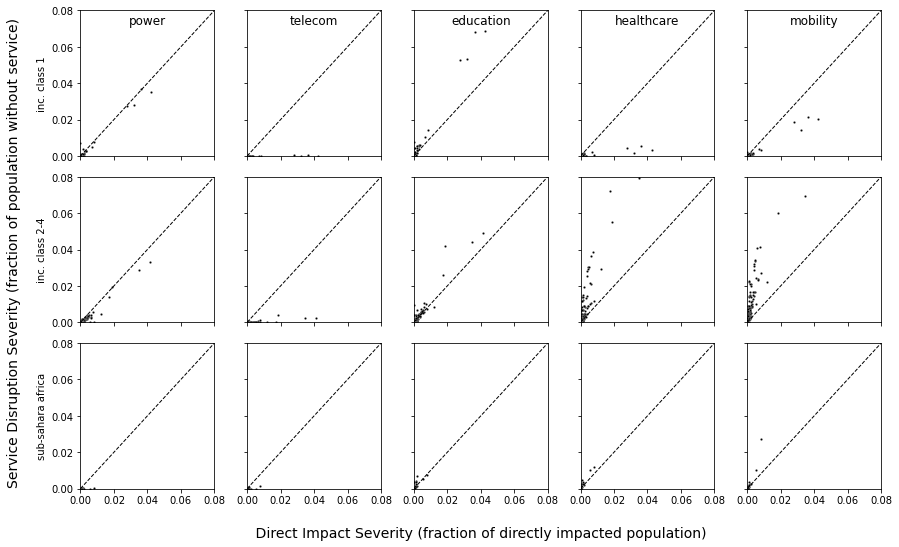

In [16]:
fig, axes = plt.subplots(3, 5, sharex=True, sharey=True, figsize=(13.3,8))

for j, service in enumerate(['power', 'telecom', 'education', 'healthcare', 'mobility']):#np.unique(df_disr_1perc.service)
    #i = 0
    #sns.scatterplot(data=df_disr_1perc[(df_disr_1perc.service==service)],
    #                    x="event_severity", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[i,j], color='black')
    #axes[i,j].set_title(service)
    
    i = 0
    sns.scatterplot(data=df_dest_disr[((df_dest_disr.service==service)&(df_dest_disr.inc_class==1))],
                        x="event_severity", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[i,j], color='black')
    axes[i,j].set_title(service)
    i = 1
    sns.scatterplot(data=df_dest_disr[((df_dest_disr.service==service)&(df_dest_disr.inc_class>1))],
                        x="event_severity", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[i,j], color='black')
    i = 2
    sns.scatterplot(data=df_dest_disr[((df_dest_disr.service==service)&(df_dest_disr.geo_reg=='SSA'))],
                        x="event_severity", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[i,j], color='black')
    
for ax in axes.flatten():            
    ax.set_ylim([0,0.08])
    ax.set_xlim([0,0.08])
    ax.set(xlabel=None, ylabel=None)
    ax.axline((0, 0), slope=1, linewidth=1, color='k', linestyle='--')

#axes[0,0].set_ylabel('all regions')
axes[0,0].set_ylabel('inc. class 1')
axes[1,0].set_ylabel('inc. class 2-4')
axes[2,0].set_ylabel('sub-sahara africa')
    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('\n Direct Impact Severity (fraction of directly impacted population) ', fontsize=14)
plt.ylabel('Service Disruption Severity (fraction of population without service) \n\n ', fontsize=14)
fig.tight_layout()
plt.savefig('/cluster/work/climate/evelynm/nw_outputs/comp_results/service_disr_vs_event_severity_FL_3cat.png', dpi=300)

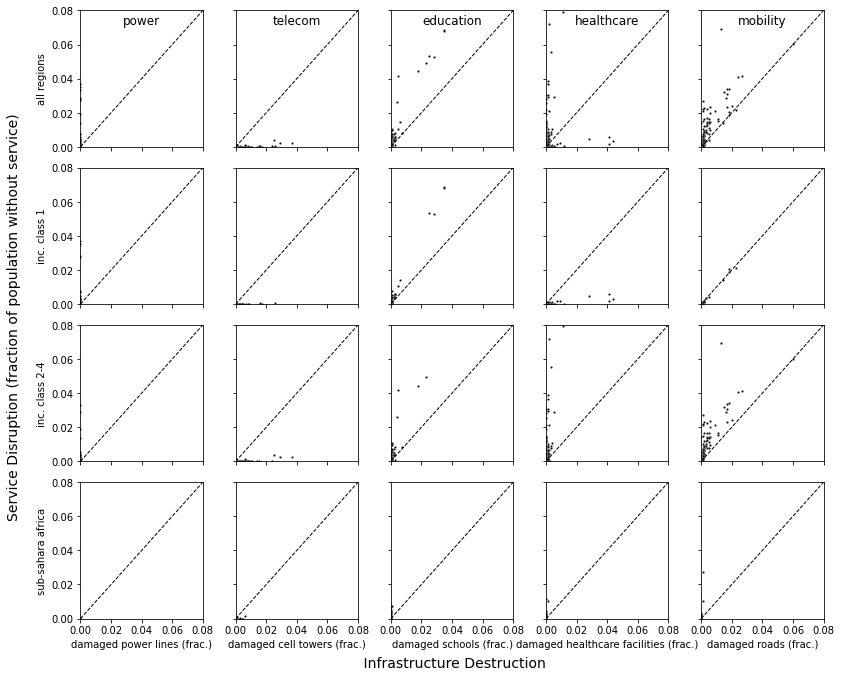

In [21]:
fig, axes = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(12.5,10))

for j, service in enumerate(['power', 'telecom', 'education', 'healthcare', 'mobility']):#np.unique(df_disr_1perc.service)
    i = 0
    sns.scatterplot(data=df_dest_disr[(df_dest_disr.service==service)],
                        x="destruction_rate", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[i,j], color='black')
    axes[i,j].set_title(service)
    
    i = 1
    sns.scatterplot(data=df_dest_disr[((df_dest_disr.service==service)&(df_dest_disr.inc_class==1))],
                        x="destruction_rate", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[i,j], color='black')
    i = 2
    sns.scatterplot(data=df_dest_disr[((df_dest_disr.service==service)&(df_dest_disr.inc_class>1))],
                        x="destruction_rate", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[i,j], color='black')
    i = 3
    sns.scatterplot(data=df_dest_disr[((df_dest_disr.service==service)&(df_dest_disr.geo_reg=='SSA'))],
                        x="destruction_rate", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[i,j], color='black')
    
for ax in axes.flatten():            
    ax.set_ylim([0,0.08])
    ax.set_xlim([0,0.08])
    ax.set(xlabel=None, ylabel=None)
    ax.axline((0, 0), slope=1, linewidth=1, color='k', linestyle='--')

axes[0,0].set_ylabel('all regions')
axes[1,0].set_ylabel('inc. class 1')
axes[2,0].set_ylabel('inc. class 2-4')
axes[3,0].set_ylabel('sub-sahara africa')

for j, service in enumerate(['power', 'telecom', 'education', 'healthcare', 'mobility']):#np.unique(df_disr_1perc.service)
    axes[3,j].set_xlabel(f'damaged {infra_renaming_dict[service]} (frac.)')
#axes[3,1].set_xlabel('inc. class 1')
#axes[3,2].set_xlabel('inc. class 2-4')
#axes[3,3].set_xlabel('sub-sahara africa')
#axes[3,4].set_xlabel('sub-sahara africa')
    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('\n Infrastructure Destruction', fontsize=14)
plt.ylabel('Service Disruption (fraction of population without service) \n\n ', fontsize=14)
fig.tight_layout()

### Disruption vs. Destruction - Rank plots

In [9]:
def plot_rank_correlation(ranklist, spearmanr_res, event_names, haz_type, save_path=None, ax=None):
    f, ax = plt.subplots(1, 1, figsize=(8,8))
    ax.scatter( ranklist[1], ranklist[0])
    plt.title("rank correlation ")
    plt.xlabel("structural impact rank")
    plt.ylabel("service disruption impact rank")
    plt.axline((min(ranklist[0])-1, min(ranklist[0])-1), slope=1)
    plt.text(min(ranklist[0]), max(ranklist[0]), f'Spearman rank corr. coeff.: {np.round(spearmanr_res[0], 3)}')
    for i, txt in enumerate(event_names):
        ax.annotate(txt, (ranklist[1][i]-1, ranklist[0][i]+0.3))
    return f, ax

In [10]:
# Sort iso3 region codes alphabetically
disr_rate_TC = {key : disr_rate_TC[key] for key in sorted(disr_rate_TC.keys())}

In [11]:
# Sort iso3 region codes alphabetically
disr_rate_FL = {key : disr_rate_FL[key] for key in sorted(disr_rate_FL.keys())}

In [ ]:
list_df_long = []
for reg, reg_dict in dest_rate_FL.items():
    df_cleaned = long_tidy_table_from_nested_dict(reg_dict, 'destruction_rate')
    df_cleaned['iso3'] = reg
    list_df_long.append(df_cleaned)

df_dest_1perc = pd.concat(list_df_long)
df_dest_1perc = df_dest_1perc.loc[df_dest_1perc.service!='people']
df_dest_1perc = df_dest_1perc.reset_index(drop=True)

rename_dict = {'power_line':'power',
              'celltower':'telecom',
              'road':'mobility',
               'education':'education',
              'health':'healthcare'}
df_dest_1perc['service'] = df_dest_1perc.apply(lambda row: rename_dict[row.service], axis=1)

df_dest_disr_1perc = pd.merge(
    df_dest_1perc,
    df_disr_1perc,
    how="inner",
    on=['service', 'event_id', 'iso3'])
df_dest_disr_1perc['event_severity'] = df_dest_disr_1perc.event_severity_y
df_dest_disr_1perc['destruction_rate']/=100
df_dest_disr_1perc = df_dest_disr_1perc.drop(['event_severity_x', 'event_severity_y'], axis=1)

/cluster/apps/nss/gcc-8.2.0/python/3.9.9/x86_64/lib64/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


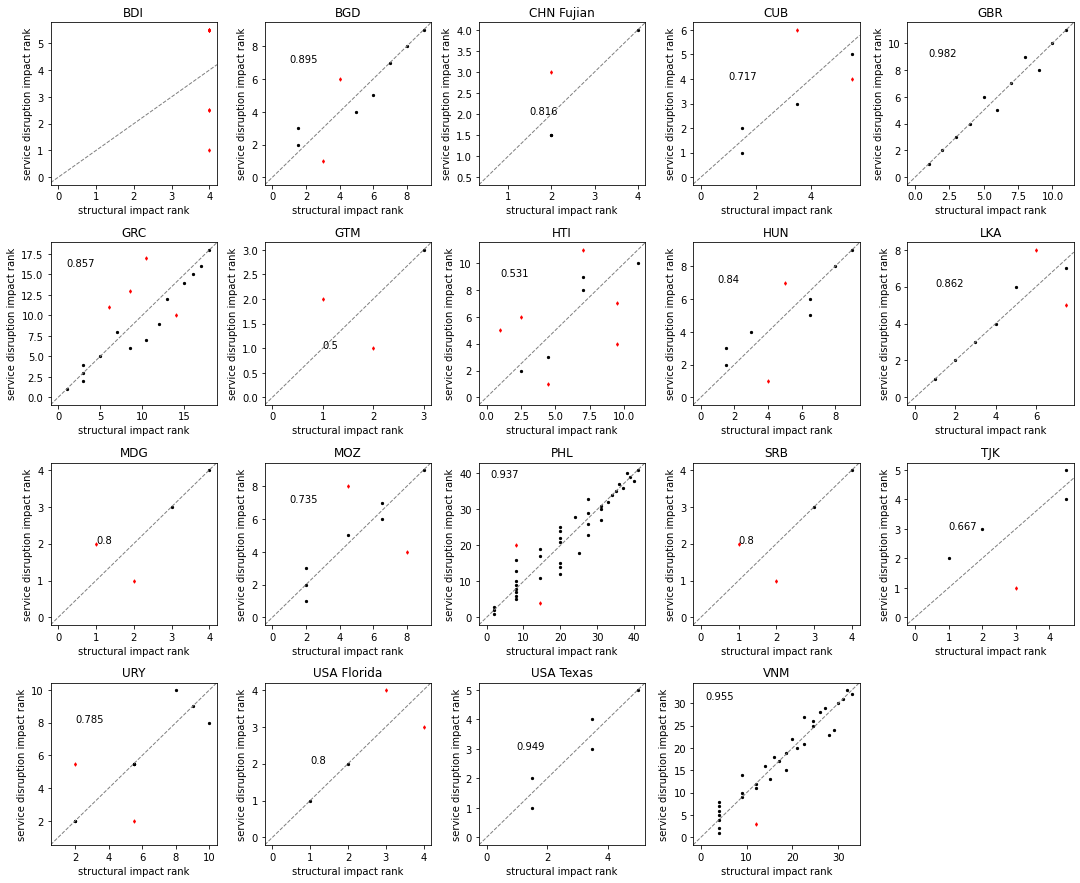

In [12]:
fig, axes = plt.subplots(5,5,figsize=(15,15))
axes = axes.flatten()
num_regs = 0
valid_regs = [reg for reg in disr_rate_FL.keys() if len(disr_rate_FL[reg].keys())>2]

for iso3, ax in zip(valid_regs, axes):
        num_regs+=1
        spearmanr_res, ranklist = af.compare_impact_rankings(disr_rate_FL[iso3], destr_rate_FL[iso3])
        outliers = np.abs(ranklist[1]-ranklist[0])/len(ranklist[1])>0.2
        ax.scatter(ranklist[1][~outliers], ranklist[0][~outliers], color='k', s=5)
        ax.scatter(ranklist[1][outliers], ranklist[0][outliers], color='r', s=5, marker='d')
        ax.set_title(f"{iso3}")
        ax.set_xlabel("structural impact rank")
        ax.set_ylabel("service disruption impact rank")
        ax.axline((min(ranklist[0])-1, min(ranklist[0])-1), slope=1, linewidth=1, color='gray', linestyle='--')
        if not np.isnan(spearmanr_res[0]):
            ax.text(min(ranklist[0]), max(ranklist[0]-2), f'{np.round(spearmanr_res[0], 3)}')
        #for i, txt in enumerate(event_names):
        #    ax.annotate(txt, (ranklist[1][i]-1, ranklist[0][i]+0.3))
for ax in axes[num_regs:]:
    fig.delaxes(ax)
fig.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(12.5,10))

for j, service in enumerate(['power', 'telecom', 'education', 'healthcare', 'mobility']):#np.unique(df_disr_1perc.service)
    i = 0
    sns.scatterplot(data=df_disr_1perc[(df_disr_1perc.service==service)],
                        x="event_severity", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[i,j], color='black')
    axes[i,j].set_title(service)
    
    i = 1
    sns.scatterplot(data=df_disr_1perc[((df_disr_1perc.service==service)&(df_disr_1perc.inc_class==1))],
                        x="event_severity", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[i,j], color='black')
    i = 2
    sns.scatterplot(data=df_disr_1perc[((df_disr_1perc.service==service)&(df_disr_1perc.inc_class>1))],
                        x="event_severity", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[i,j], color='black')
    i = 3
    sns.scatterplot(data=df_disr_1perc[((df_disr_1perc.service==service)&(df_disr_1perc.geo_reg=='SSA'))],
                        x="event_severity", y="disruption_rate", alpha=1, s=5, legend=False,ax=axes[i,j], color='black')
    
for ax in axes.flatten():            
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])
    ax.set(xlabel=None, ylabel=None)
    ax.axline((0, 0), slope=1, linewidth=1, color='k', linestyle='--')

axes[0,0].set_ylabel('all regions')
axes[1,0].set_ylabel('inc. class 1')
axes[2,0].set_ylabel('inc. class 2-4')
axes[3,0].set_ylabel('sub-sahara africa')
    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('\n Direct Impact Severity (fraction of directly impacted population) ', fontsize=14)
plt.ylabel('Service Disruption Severity (fraction of population without service) \n\n ', fontsize=14)
fig.tight_layout()

### Explanatory power of various variables on disruption impacts
(Categorical and continuous variables)
e.g. service disruption (Service X) = event severity + infra destruction (infra X) + inc. class + pop. density + infra density
Several of those are strongly correlated!!


In [56]:
df_dest_disr_1perc.columns

Index(['service', 'event_id', 'destruction_rate', 'iso3', 'disruption_rate',
       'geo_reg', 'inc_class', 'island', 'event_severity'],
      dtype='object')

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn

In [64]:
# dataframe with infrastructure densities
#df_infra_density = af.infra_density_df(list(perevent_factor_c.keys()), save_path= '/cluster/work/climate/evelynm/nw_outputs/comp_results/')
df_infra_density = pd.read_csv('/cluster/work/climate/evelynm/nw_outputs/comp_results/df_infra_density.csv', index_col=0)
df_infra_density= df_infra_density.reset_index().rename({'index':'infrastructure'}, axis=1)
df_infra_density = df_infra_density.melt(id_vars='infrastructure', var_name='iso3', value_name='infra_density')
df_infra_density = df_infra_density[df_infra_density.infrastructure!='power_plant']
infra_service_renaming_dict = {
    'power_line' : 'power',
    'health' : 'healthcare',
    'education' : 'education',
    'celltower' : 'telecom',
    'road' : 'mobility'
}

df_infra_density['infrastructure'] = df_infra_density.apply(lambda row: infra_service_renaming_dict[row.infrastructure], axis=1)

In [69]:
df_dest_disr_1perc['infra_density'] = df_dest_disr_1perc.apply(lambda row: 
            df_infra_density[(df_infra_density.infrastructure==row.service) &
                                           (df_infra_density.iso3==row.iso3)].infra_density.values[0], axis=1)

In [74]:
df_dest_disr_1perc['pop_density'] = df_dest_disr_1perc.apply(lambda row: af.pop_density_dict()[row.iso3], axis=1)

In [90]:
data_power = df_dest_disr_1perc[df_dest_disr_1perc.service=='power']
y_power = data_power.disruption_rate
x_power = data_power[['destruction_rate', 'event_severity', 'inc_class', 'infra_density', 'pop_density']]

In [91]:
x_power = sm.add_constant(x_power)
results = sm.OLS(y_power,x_power).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        disruption_rate   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     115.0
Date:                Tue, 13 Jun 2023   Prob (F-statistic):           2.44e-79
Time:                        12:23:10   Log-Likelihood:                 103.66
No. Observations:                 478   AIC:                            -195.3
Df Residuals:                     472   BIC:                            -170.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1544      0.049      3.181      0.002       0.059       0.250
destruction_rate     0.5288      0.145      3.639      0.000       0.243       0.814
event_severity       0.9115      0.099      9.174      0.000       0.716       1.107
inc_class           -0.0101      0.014     -0.719      0.473      -0.038       0.018
infra_density       -0.0200      0.005     -3.746      0.000      -0.031      -0.010
pop_density      -2.762e-05   4.51e-05     -0.612      0.541      -0.000     6.1e-05
==============================================================================
Omnibus:                      161.422   Durbin-Watson:                   1.229
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              447.711
Skew:                           1.652   Prob(JB):                     6.04e-98
Kurtosis:                       6.400   Cond. No.                     6.46e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [105]:
x_power2 = x_power.copy()
# no additional explanatory power (inc class 1 and infra density very similar.)
# x_power2['inc_class_1'] = pd.get_dummies(x_power.inc_class, prefix='inc_class')['inc_class_1']
# x_power2['inc_class_4'] = pd.get_dummies(x_power.inc_class, prefix='inc_class')['inc_class_4']
x_power2.drop('inc_class', inplace=True, axis=1)
x_power2.drop('pop_density', inplace=True, axis=1)

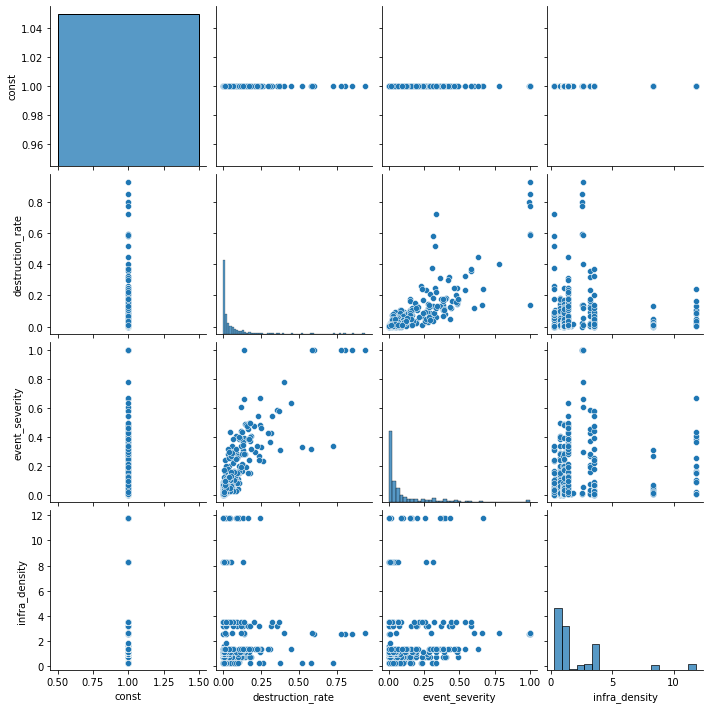

In [106]:
sns.pairplot(x_power2)

In [107]:
results2 = sm.OLS(y_power,x_power2).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        disruption_rate   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     191.8
Date:                Tue, 13 Jun 2023   Prob (F-statistic):           2.03e-81
Time:                        15:52:55   Log-Likelihood:                 103.18
No. Observations:                 478   AIC:                            -198.4
Df Residuals:                     474   BIC:                            -181.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1126      0.013      8.987      0.000       0.088       0.137
destruction_rate     0.5245      0.143      3.668      0.000       0.244       0.806
event_severity       0.9271      0.094      9.853      0.000       0.742       1.112
infra_density       -0.0164      0.004     -4.423      0.000      -0.024      -0.009
==============================================================================
Omnibus:                      164.078   Durbin-Watson:                   1.228
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              463.112
Skew:                           1.673   Prob(JB):                    2.73e-101
Kurtosis:                       6.473   Cond. No.                         60.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
x_power3 = x_power2.copy()
x_power3.drop('event_severity', inplace=True, axis=1)

x_power4 = x_power2.copy()
x_power4.drop('destruction_rate', inplace=True, axis=1)

In [109]:
results3 = sm.OLS(y_power,x_power3).fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        disruption_rate   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     198.9
Date:                Tue, 13 Jun 2023   Prob (F-statistic):           1.75e-63
Time:                        15:55:53   Log-Likelihood:                 58.651
No. Observations:                 478   AIC:                            -111.3
Df Residuals:                     475   BIC:                            -98.79
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1306      0.014      9.613      0.000       0.104       0.157
destruction_rate     1.7039      0.086     19.859      0.000       1.535       1.873
infra_density       -0.0095      0.004     -2.379      0.018      -0.017      -0.002
==============================================================================
Omnibus:                      140.392   Durbin-Watson:                   1.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              312.040
Skew:                           1.546   Prob(JB):                     1.74e-68
Kurtosis:                       5.470   Cond. No.                         28.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [110]:
results4 = sm.OLS(y_power,x_power4).fit()
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        disruption_rate   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     273.8
Date:                Tue, 13 Jun 2023   Prob (F-statistic):           8.14e-80
Time:                        15:55:56   Log-Likelihood:                 96.495
No. Observations:                 478   AIC:                            -187.0
Df Residuals:                     475   BIC:                            -174.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1154      0.013      9.108      0.000       0.090       0.140
event_severity     1.2159      0.052     23.314      0.000       1.113       1.318
infra_density     -0.0184      0.004     -4.940      0.000      -0.026      -0.011
==============================================================================
Omnibus:                      159.678   Durbin-Watson:                   1.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              478.477
Skew:                           1.591   Prob(JB):                    1.26e-104
Kurtosis:                       6.728   Cond. No.                         18.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### "Spillover effect":

In [125]:
event_count = 0
spillover_count = 0
for reg, event_df in perevent_factor_c.items():
    spillover_count+=sum(sum(event_df.values>1)[:-1]>0)
    event_count+=len(event_df.columns)-1
print(spillover_count/event_count)

0.6470588235294118


## Static region variables vs. cascade factors

### Infrastructure density vs. cascade factors
--> take median cascade factors!

In [160]:
af.save_dict(perevent_factor_c, f'/cluster/work/climate/evelynm/nw_outputs/comp_results/factor_c_eventwise_{haz_type}_allcntrs.pkl')

In [161]:
perevent_factor_c = af.load_dict(f'/cluster/work/climate/evelynm/nw_outputs/comp_results/factor_c_eventwise_{haz_type}_allcntrs.pkl')


In [74]:
perevent_factor_c ={key : perevent_factor_c[key].rename({'electricity':'power', 'mobile communications' : 'telecom'}, axis=0) for key in sorted(perevent_factor_c.keys())}


In [65]:
# dataframe with median cascade factors
median_factor_c = {}
perevent_factor_c['HTI'].rename({'mobile /n communications': 'mobile communications'}, axis=0, inplace=True)
perevent_factor_c = {key : perevent_factor_c[key] for key in sorted(perevent_factor_c.keys())}
perevent_factor_c = {key : perevent_factor_c[key].rename({'electricity':'power', 'mobile communications' : telecom}, axis=0) for key in sorted(perevent_factor_c.keys())}


for reg, factor_dict in perevent_factor_c.items():
    median_factor_c[reg] = factor_dict['median']
df_median_factor_c = pd.DataFrame.from_dict(median_factor_c)

In [66]:
df_median_factor_c

ATG       BGD  CHN Fujian  CHN Hainan       CUB  \
education              1.00  1.095000    1.420000    2.730000  1.080000   
electricity            1.00  1.120000    1.580000    2.690000  1.080000   
healthcare             1.00  0.480000    0.580000    2.865000  0.740000   
mobile communications  1.00  0.925000    1.130000    2.670000  0.870000   
mobility               0.88  0.040000    0.010000    0.115000  0.580000   
population             1.00  0.010348    0.058131    0.301759  0.166958   

                            GTM       HTI       KHM       LKA       MDG  \
education              1.670000  2.060000  1.060000  1.150000  0.660000   
electricity            1.770000  2.050000  1.060000  1.150000  0.000000   
healthcare             1.475000  0.980000  1.020000  0.720000  0.730000   
mobile communications  1.470000  1.470000  1.040000  0.940000  0.640000   
mobility               0.320000  0.580000  1.030000  0.350000  0.380000   
population             0.007948  0.100613  0.009038  0.084015  0.033728   

                            MEX        MOZ       PHL       PRI  USA Florida  \
education              1.080000   8.940000  1.650000  0.930000     0.980000   
electricity            1.100000   9.655000  1.650000  0.930000     0.980000   
healthcare             0.840000   6.960000  1.150000  0.210000     0.390000   
mobile communications  0.920000  10.715000  1.560000  0.760000     0.840000   
mobility               0.150000   0.330000  0.500000  0.140000     0.120000   
population             0.006236   0.019999  0.042248  0.677272     0.043183   

                       USA Louisiana  USA Texas       VNM  
education                   0.890000   0.815000  1.090000  
electricity                 0.900000   0.820000  1.070000  
healthcare                  0.330000   0.355000  0.550000  
mobile communications       0.770000   0.645000  0.910000  
mobility                    0.160000   0.145000  0.130000  
population                  0.164796   0.022529  0.018065

In [151]:
df_median_factor_c = df_median_factor_c.reset_index().rename({'index':'service'}, axis=1)
df_median_factor_c = df_median_factor_c.melt(id_vars='service', var_name='iso3', value_name='resilience_casc_factor')
df_median_factor_c = df_median_factor_c[df_median_factor_c.service!='population']

In [152]:
# dataframe with infrastructure densities
#df_infra_density = af.infra_density_df(list(perevent_factor_c.keys()), save_path= '/cluster/work/climate/evelynm/nw_outputs/comp_results/')
df_infra_density = pd.read_csv('/cluster/work/climate/evelynm/nw_outputs/comp_results/df_infra_density.csv', index_col=0)
df_infra_density= df_infra_density.reset_index().rename({'index':'infrastructure'}, axis=1)
df_infra_density = df_infra_density.melt(id_vars='infrastructure', var_name='iso3', value_name='infra_density')
df_infra_density = df_infra_density[df_infra_density.infrastructure!='power_plant']

In [153]:
infra_service_renaming_dict = {
    'power_line' : 'power',
    'health' : 'healthcare',
    'education' : 'education',
    'celltower' : 'telecom',
    'road' : 'mobility'
}
df_infra_density['infrastructure'] = df_infra_density.apply(lambda row: infra_service_renaming_dict[row.infrastructure], axis=1)

In [154]:
df_density_casc = pd.merge(df_infra_density, df_median_factor_c, how='left', right_on=['iso3', 'service'], left_on=['iso3', 'infrastructure'])

In [122]:
service_infra_renaming_dict = {
    'power' : 'power lines (m/cap.)',
    'healthcare' : 'health facilities (u./cap.)',
    'education' : 'schools (u./cap.)',
    'telecom' : 'cell towers (u./cap.)',
    'mobility' : 'roads (m/cap.)'
}

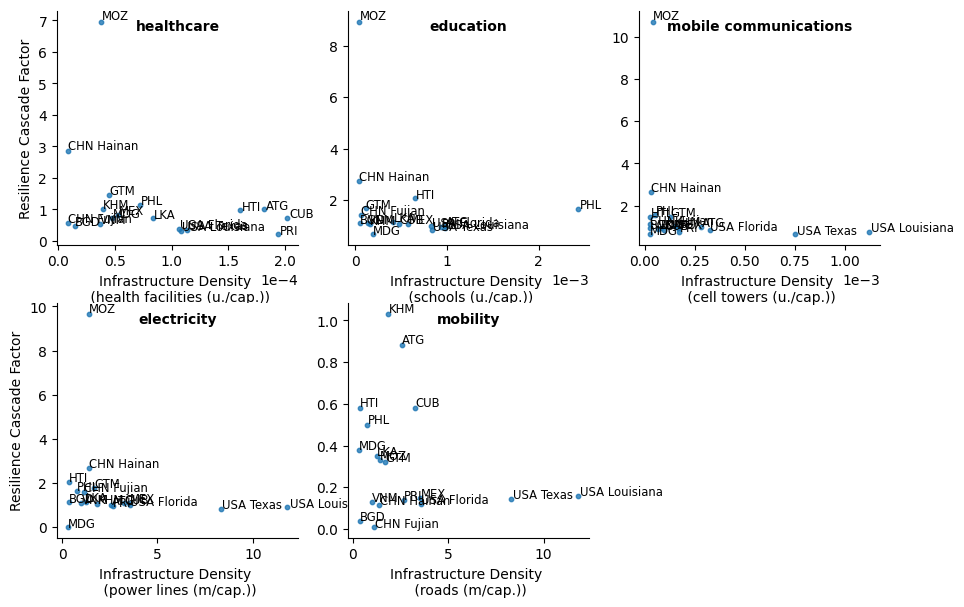

In [45]:
g = sns.lmplot(x='infra_density',y='resilience_casc_factor', col='service',
               data=df_density_casc, fit_reg=False, height=3, facet_kws=dict(sharex=False, sharey=False),
               col_wrap=3,  legend=False, palette="Set3", 
               scatter_kws={"s": 10}, ci=None)
#legend = plt.legend(loc='lower right',bbox_to_anchor=(1.8,0.1), frameon=False)
#legend.set_title('Region')

for i, ax in enumerate(g.axes):
    if i%3==0:
        ax.set_ylabel('Resilience Cascade Factor')
    service = ' '.join(ax.get_title().split(' ')[2:])
    plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
    plt.rcParams['axes.titlepad'] = -14
    ax.set_xlabel(f'Infrastructure Density \n ({service_infra_renaming_dict[service]})')
    ax.set_title(service, fontsize=10, weight='bold')
    ax.ticklabel_format(axis='x', style='sci', scilimits=[0,3], useOffset=None, useLocale=None, useMathText=None)
    
    annot_data = df_density_casc[df_density_casc.service==service]
    for line in range(0,annot_data.shape[0]):
        ax.text(annot_data.infra_density.iloc[line]*1.01, 
                 annot_data.resilience_casc_factor.iloc[line]*1.01, 
                 annot_data.iso3.iloc[line], 
                 horizontalalignment='left', size='small', color='black', transform=ax.transData)

plt.savefig('/cluster/work/climate/evelynm/nw_outputs/comp_results/casc_vs_infra_dens.png', dpi=300)

### Income Class vs. Cascade Factors

In [73]:
inc_class_dict = af.inc_class_dict()
df_density_casc['inc_class'] = df_density_casc.apply(lambda row: inc_class_dict[row.iso3], axis=1)

" \n    annot_data = df_density_casc[df_density_casc.service==service]\n    for line in range(0,annot_data.shape[0]):\n        ax.text(annot_data.inc_class.iloc[line]*1.01, \n                 annot_data.resilience_casc_factor.iloc[line]*1.01, \n                 annot_data.iso3.iloc[line], \n                 horizontalalignment='left', size=9, color='black', transform=ax.transData)\n    "

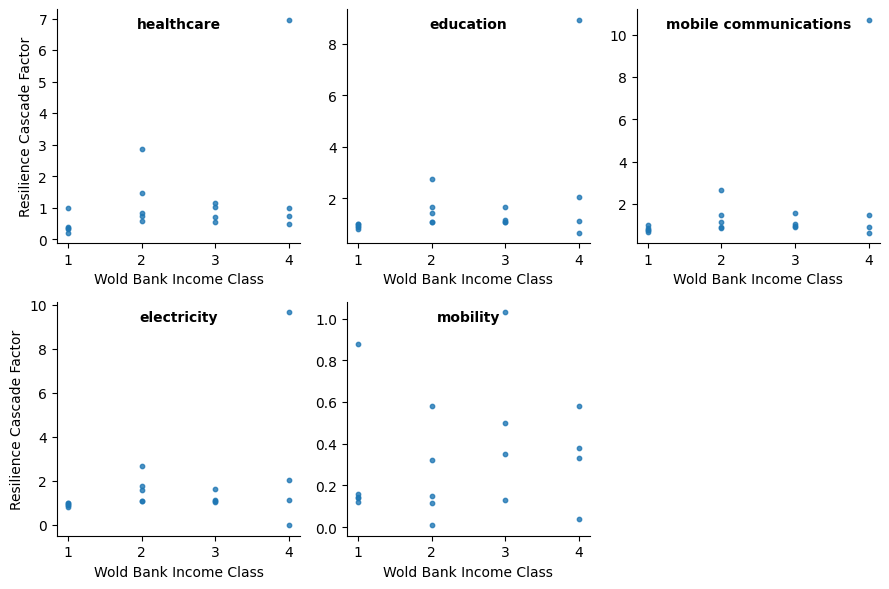

In [147]:
g = sns.lmplot(x='inc_class',y='resilience_casc_factor', col='service',
               data=df_density_casc, fit_reg=False, height=3, facet_kws=dict(sharex=False, sharey=False),
               col_wrap=3,  legend=False, palette="Set3", 
               scatter_kws={"s": 10}, ci=None)


for i, ax in enumerate(g.axes):
    if i%3==0:
        ax.set_ylabel('Resilience Cascade Factor')
    service = ' '.join(ax.get_title().split(' ')[2:])
    plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
    plt.rcParams['axes.titlepad'] = -14
    ax.set_xlabel(f'Wold Bank Income Class')
    ax.set_title(service, fontsize=10, weight='bold')
    ax.ticklabel_format(axis='x', style='sci', scilimits=[0,3], useOffset=None, useLocale=None, useMathText=None)
plt.savefig('/cluster/work/climate/evelynm/nw_outputs/comp_results/casc_vs_wbclass2.png', dpi=300)
    
""" 
    annot_data = df_density_casc[df_density_casc.service==service]
    for line in range(0,annot_data.shape[0]):
        ax.text(annot_data.inc_class.iloc[line]*1.01, 
                 annot_data.resilience_casc_factor.iloc[line]*1.01, 
                 annot_data.iso3.iloc[line], 
                 horizontalalignment='left', size=9, color='black', transform=ax.transData)
    """

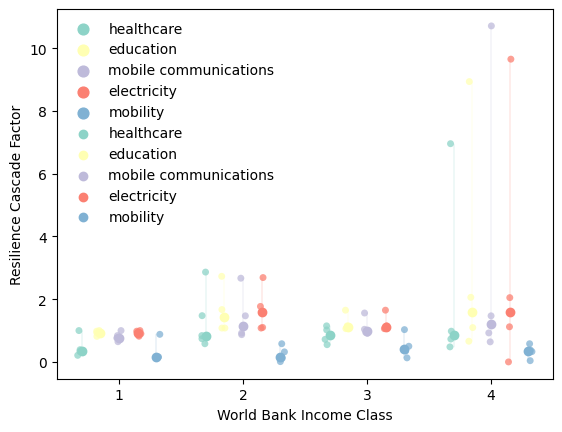

In [152]:

g = sns.stripplot(data=df_density_casc, x="inc_class", y="resilience_casc_factor", hue="service", palette='Set3',
                zorder=1, dodge=True, alpha=0.75)
sns.pointplot(
    data=df_density_casc, x="inc_class", y="resilience_casc_factor", hue="service", 
    estimator=lambda a: np.median(a), errorbar='pi',
    join=False, dodge=.8 - .8 / 4, palette="Set3", errwidth=0.2,
    markers="o", scale=0.8, legend=False)


g.axes.set_ylabel('Resilience Cascade Factor')
g.axes.set_xlabel('World Bank Income Class')

g.legend(frameon=False)
plt.savefig('/cluster/work/climate/evelynm/nw_outputs/comp_results/casc_vs_wbclass.png', dpi=300)

# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels


### Population Density vs. Cascade Factors 

In [74]:
pop_density_dict = af.pop_density_dict()
df_density_casc['pop_density'] = df_density_casc.apply(lambda row: pop_density_dict[row.iso3], axis=1)

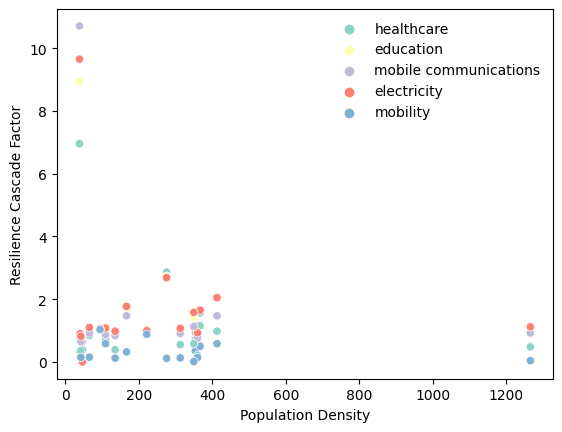

In [155]:
g = sns.scatterplot(data=df_density_casc, x="pop_density", y="resilience_casc_factor", hue="service",
                   palette='Set3')
g.legend(frameon=False)
g.axes.set_ylabel('Resilience Cascade Factor')
g.axes.set_xlabel('Population Density')
plt.savefig('/cluster/work/climate/evelynm/nw_outputs/comp_results/casc_vs_popdens.png', dpi=300)

" \n    annot_data = df_density_casc[df_density_casc.service==service]\n    for line in range(0,annot_data.shape[0]):\n        ax.text(annot_data.inc_class.iloc[line]*1.01, \n                 annot_data.resilience_casc_factor.iloc[line]*1.01, \n                 annot_data.iso3.iloc[line], \n                 horizontalalignment='left', size=9, color='black', transform=ax.transData)\n    "

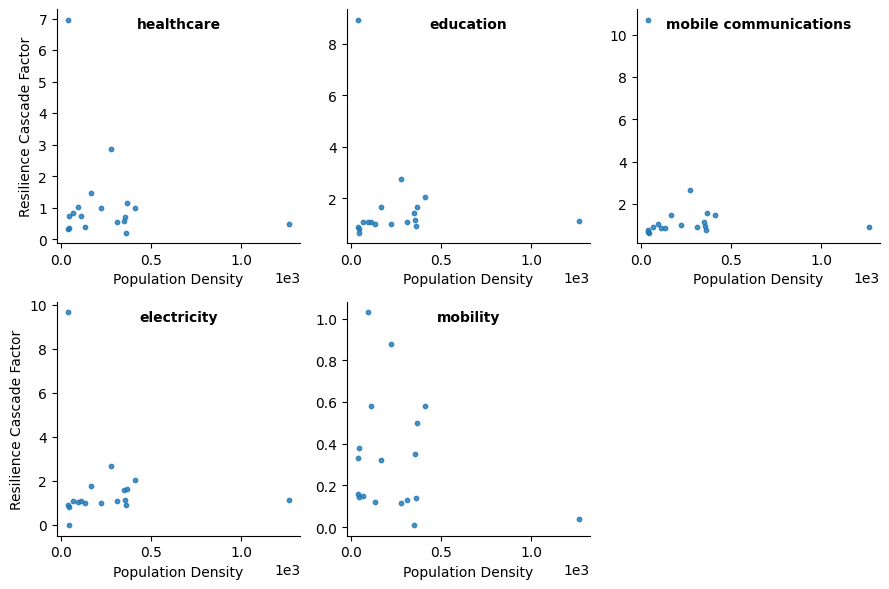

In [154]:
g = sns.lmplot(x='pop_density',y='resilience_casc_factor', col='service',
               data=df_density_casc, fit_reg=False, height=3, facet_kws=dict(sharex=False, sharey=False),
               col_wrap=3,  legend=False, palette="Set3", 
               scatter_kws={"s": 10}, ci=None)


for i, ax in enumerate(g.axes):
    if i%3==0:
        ax.set_ylabel('Resilience Cascade Factor')
    service = ' '.join(ax.get_title().split(' ')[2:])
    plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
    plt.rcParams['axes.titlepad'] = -14
    ax.set_xlabel(f'Population Density')
    ax.set_title(service, fontsize=10, weight='bold')
    ax.ticklabel_format(axis='x', style='sci', scilimits=[0,3], useOffset=None, useLocale=None, useMathText=None)
plt.savefig('/cluster/work/climate/evelynm/nw_outputs/comp_results/casc_vs_popdens2.png', dpi=300)

    
""" 
    annot_data = df_density_casc[df_density_casc.service==service]
    for line in range(0,annot_data.shape[0]):
        ax.text(annot_data.inc_class.iloc[line]*1.01, 
                 annot_data.resilience_casc_factor.iloc[line]*1.01, 
                 annot_data.iso3.iloc[line], 
                 horizontalalignment='left', size=9, color='black', transform=ax.transData)
    """

## Overview Plots

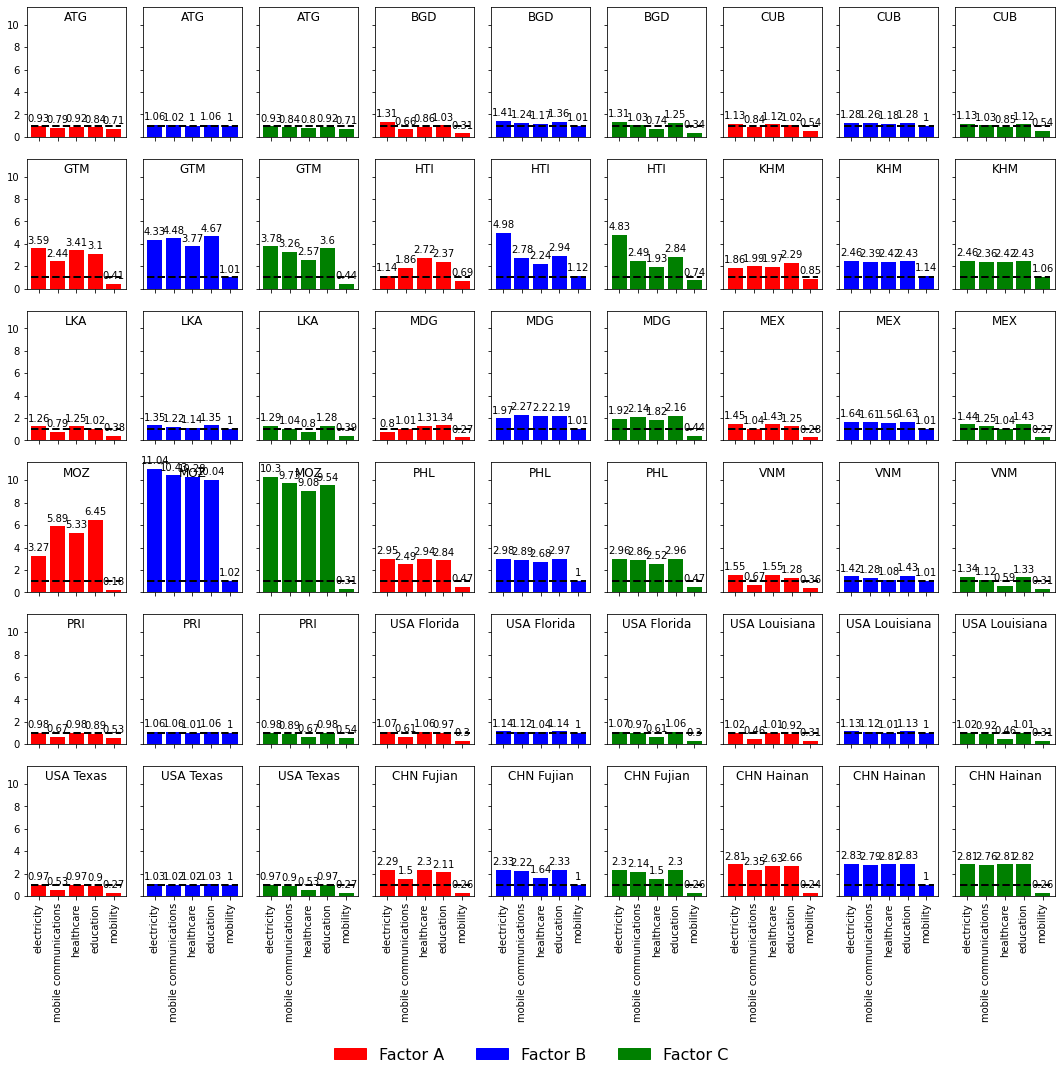

In [147]:
pf.plot_relative_impacts_bars(deepcopy(total_imps_relb), deepcopy(total_imps_rela), deepcopy(total_imps_relc), save_path='/cluster/work/climate/evelynm/nw_outputs/impact_factors_TC_allcntries_both')

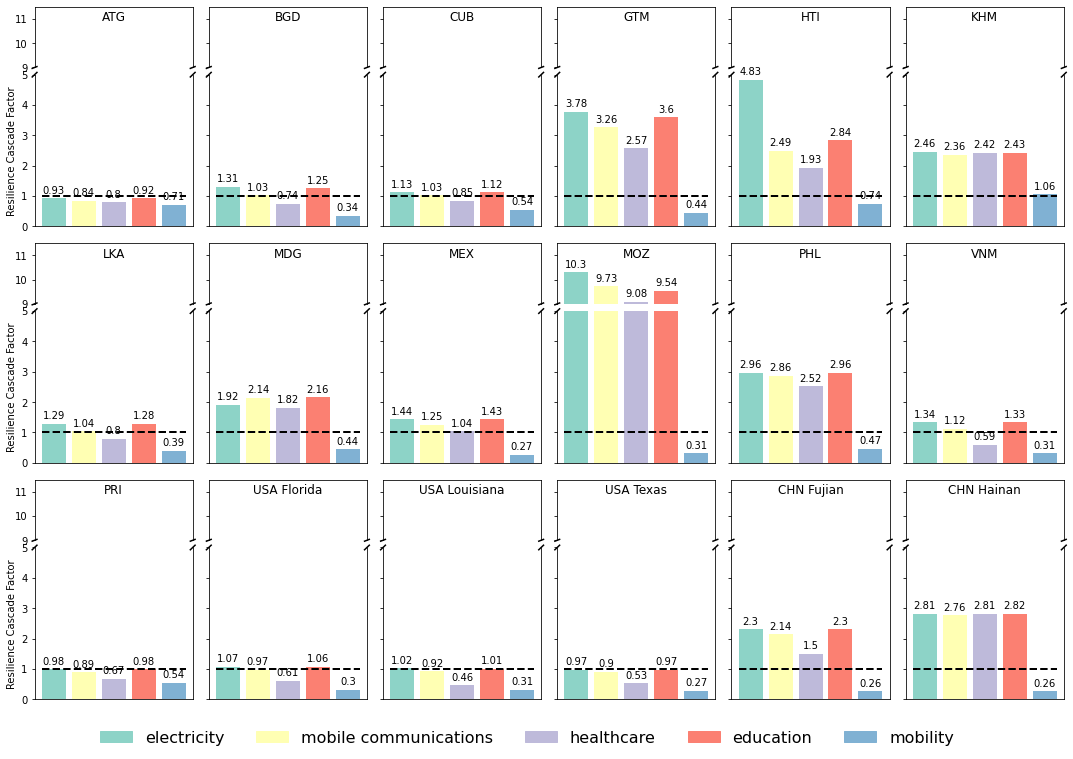

In [126]:
pf.plot_relative_impacts_bars_2(deepcopy(total_imps_relc), save_path='/cluster/work/climate/evelynm/nw_outputs/impact_factors_TC_allcntries_c')


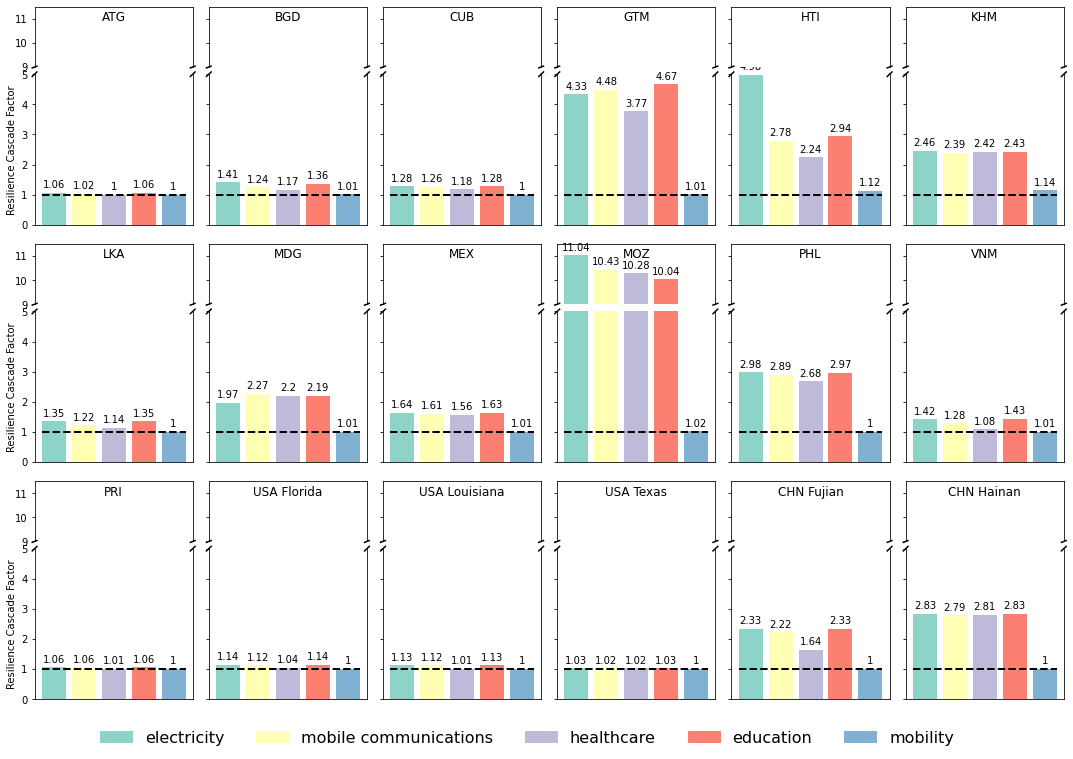

In [127]:
pf.plot_relative_impacts_bars_2(deepcopy(total_imps_relb), save_path='/cluster/work/climate/evelynm/nw_outputs/impact_factors_TC_allcntries_b')


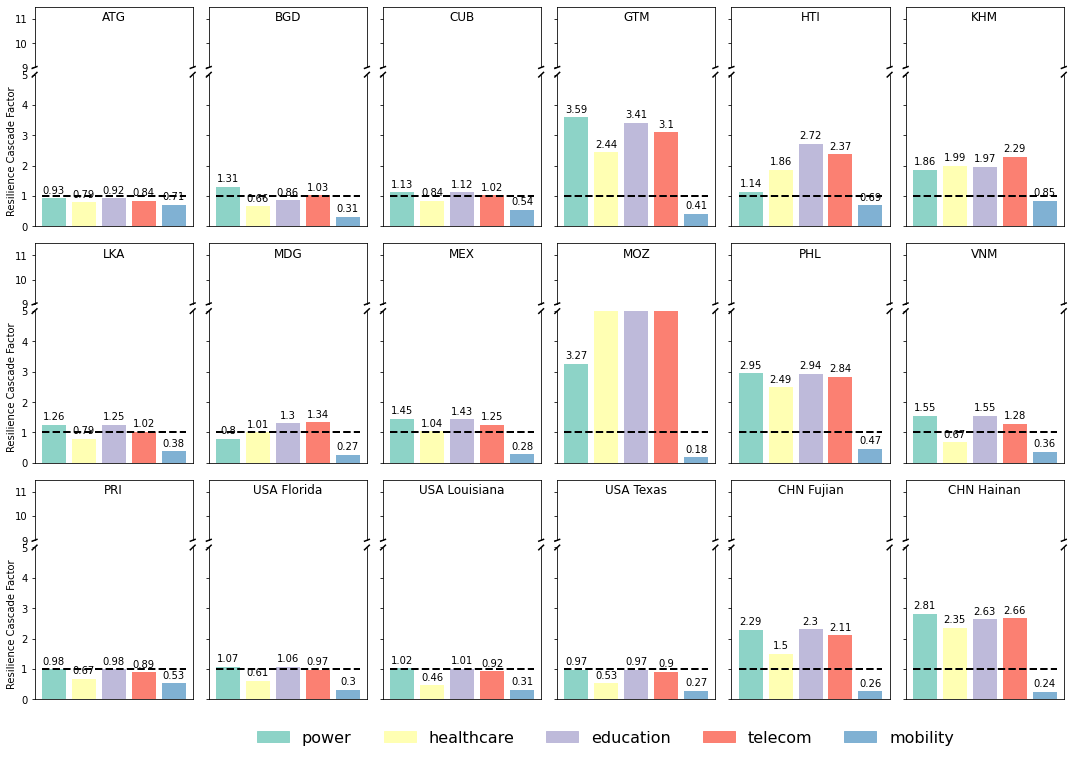

In [128]:
pf.plot_relative_impacts_bars_2(deepcopy(total_imps_rela), save_path='/cluster/work/climate/evelynm/nw_outputs/impact_factors_TC_allcntries_a')


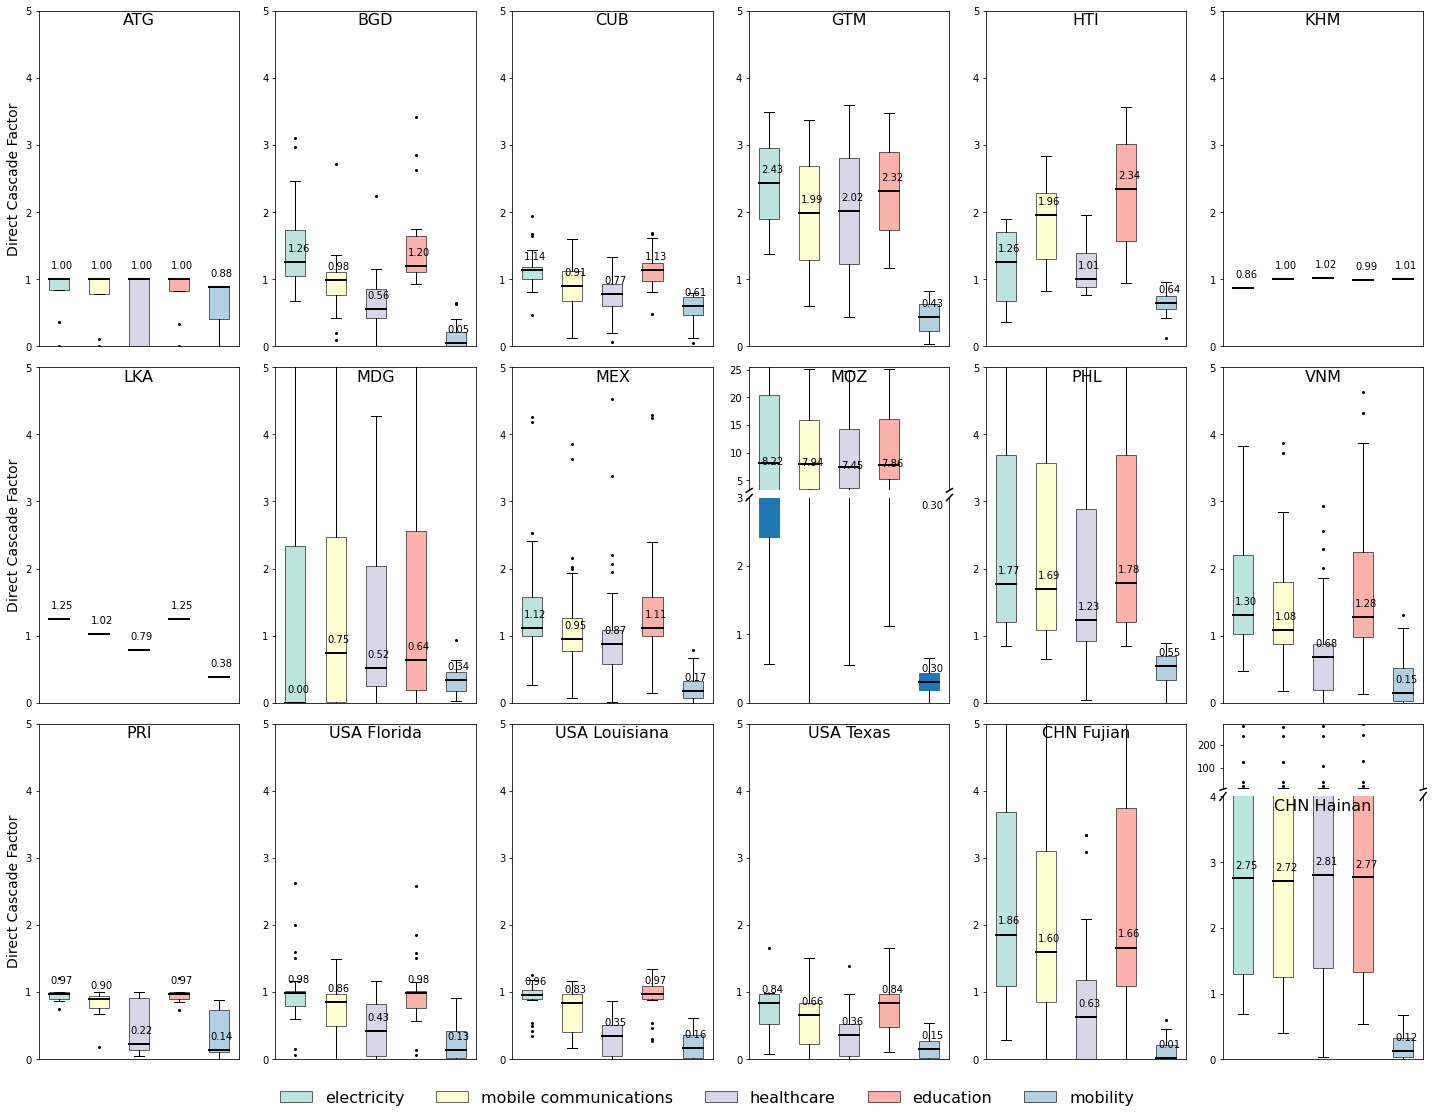

In [21]:
pf.plot_cascfactor_boxplots(perevent_factor_a, factor_type='direct',haz_type='TC', save_path='/cluster/work/climate/evelynm/nw_outputs/comp_results/') 

#

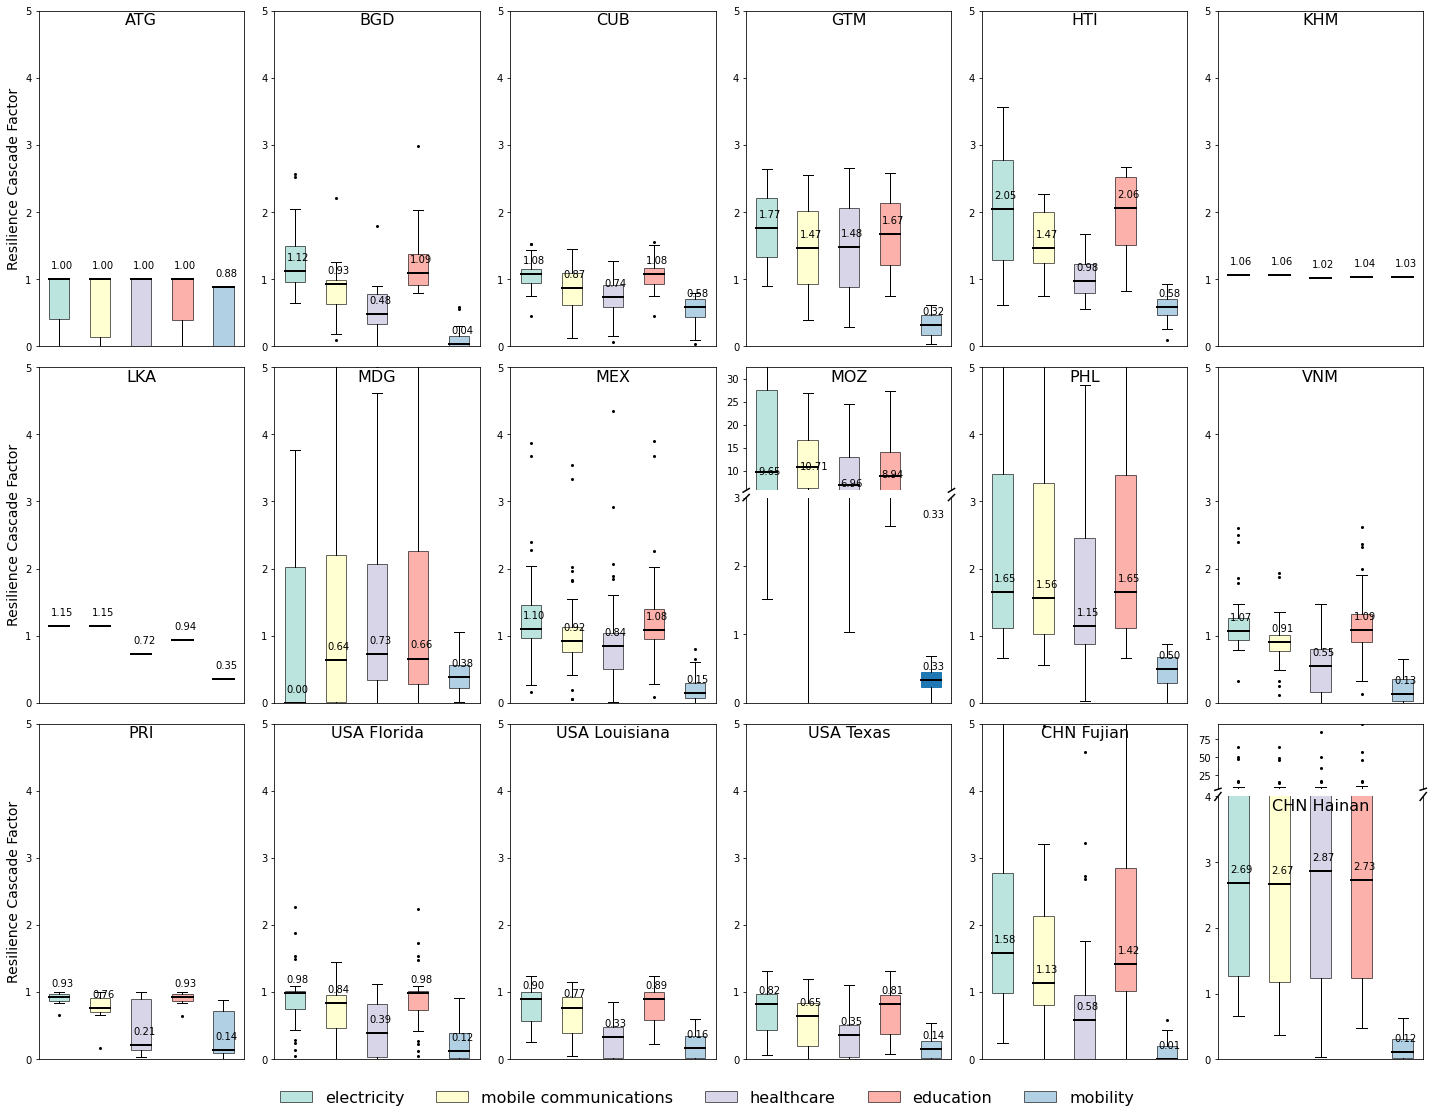

In [4]:
pf.plot_cascfactor_boxplots(perevent_factor_c, factor_type='resilience',haz_type='TC', save_path=None)#'/cluster/work/climate/evelynm/nw_outputs/comp_results/'

/cluster/project/climate/evelynm/climada_venv/lib64/python3.9/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


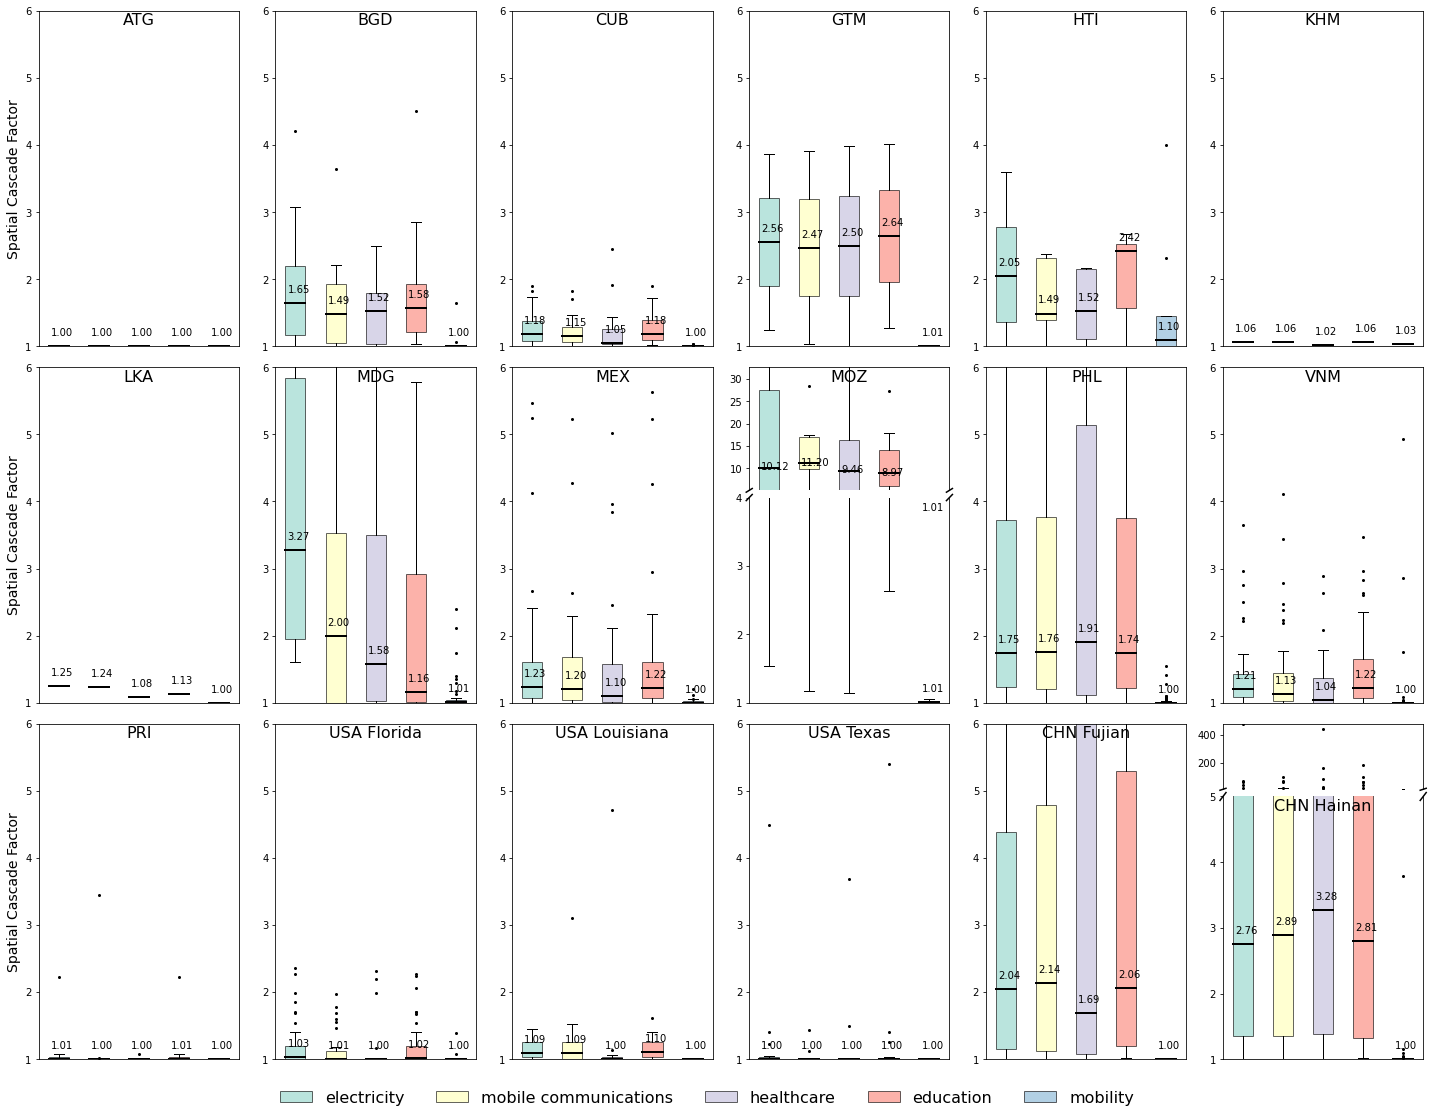

In [5]:
pf.plot_cascfactor_boxplots(perevent_factor_b, factor_type='spatial',haz_type='TC', save_path='/cluster/work/climate/evelynm/nw_outputs/comp_results/')

/cluster/project/climate/evelynm/climada_venv/lib64/python3.9/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


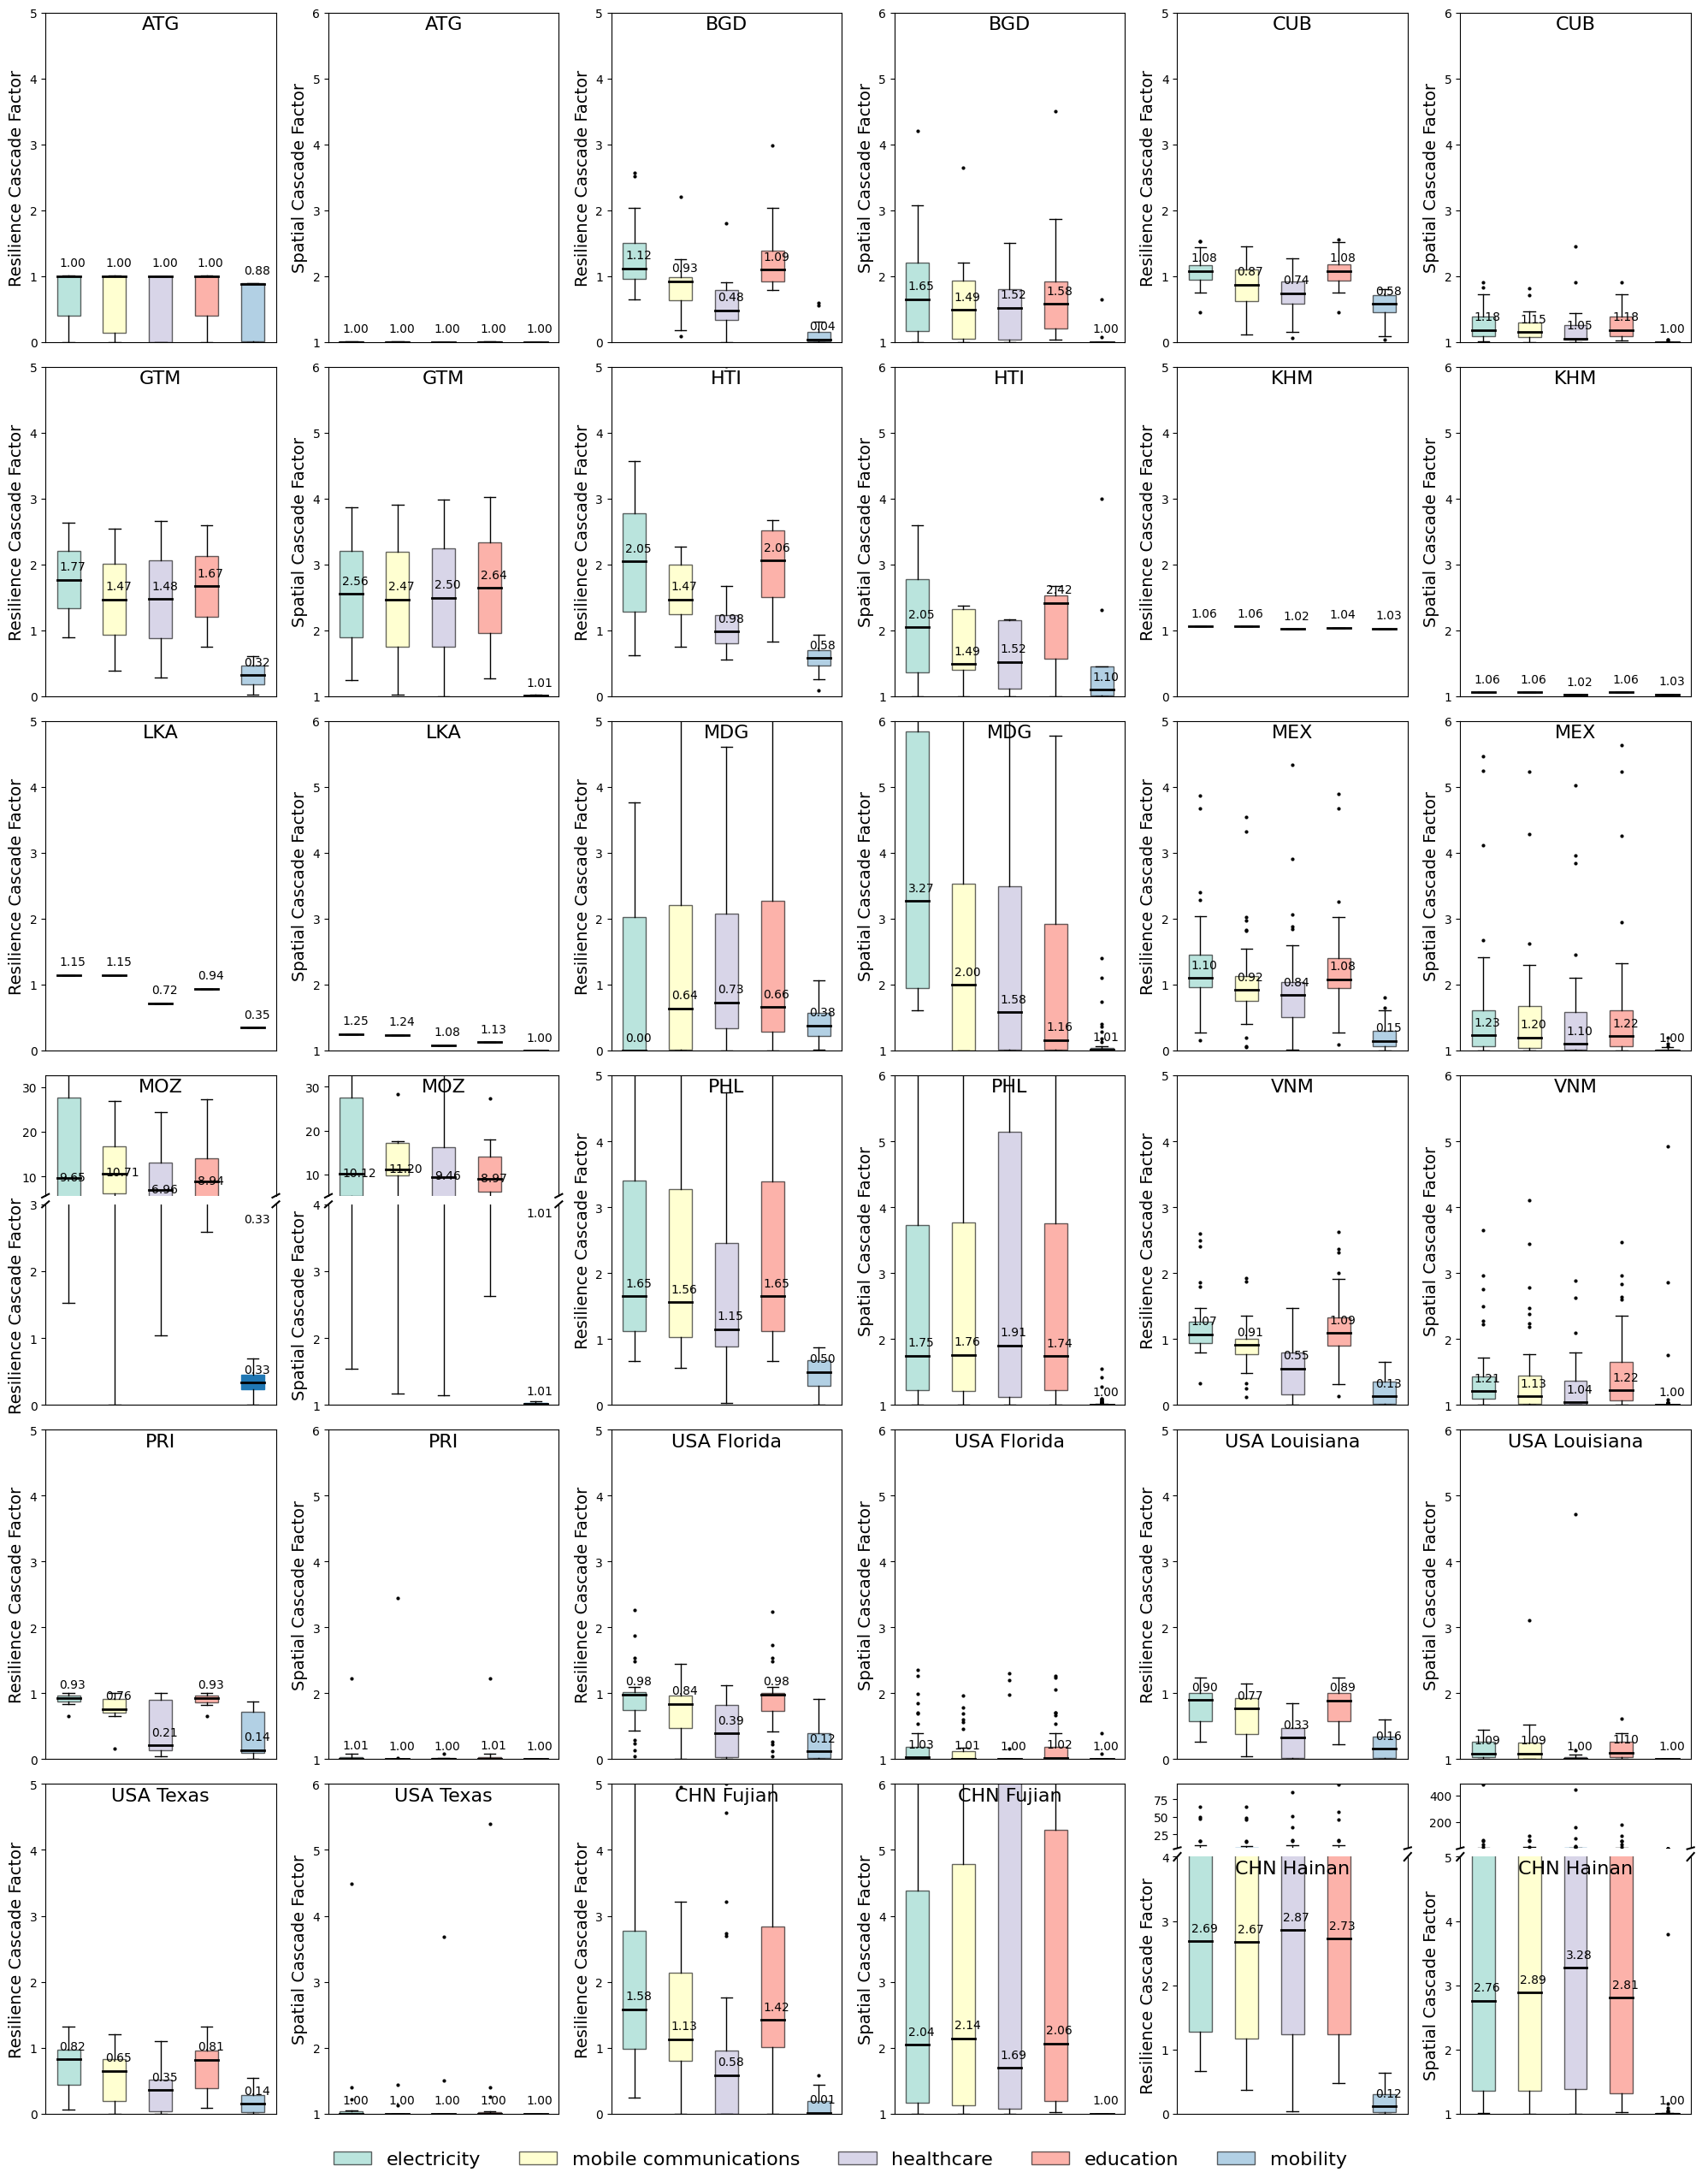

In [68]:
pf.plot_cascfactors_boxplots(perevent_factor_c, perevent_factor_b, 'TC', save_path='/cluster/work/climate/evelynm/nw_outputs/comp_results/')

In [145]:
def plot_cascfactor_boxplots(perevent_factor, factor_type, haz_type, save_path=None):
    """
    plot all cascade factors from a dataframe of many regions and many events (extension of 
    casc_factor_boxplots, but only for one metric at a time).
    """ 
    f, axes = plt.subplots(4,5, figsize=(20, 16),
                          sharex=True, sharey=False)
    
    axes = axes.flatten()
    my_cmap = plt.get_cmap("Set3") #
    label_dict = {'resilience' : 'Resilience Factor',
                 'spatial' : 'Spatial Cascade Factor',
                 'direct' : 'Direct Cascade Factor'}
    ylabel= label_dict[factor_type]
    ax1_ylim_default = 5 if factor_type in ['resilience', 'direct'] else 20 #6
    ax1_ystart_default = 0 if factor_type in ['resilience', 'direct'] else 1
    
    i=0
    for iso3, casc_df in perevent_factor.items():
        ax1 = axes.flatten()[i]

        fac_med = casc_df['median'][:-1]
        fac_max = np.nanmax(casc_df.values.flatten()[casc_df.values.flatten()!=np.inf])
        fac_75 = np.nanmax(np.percentile(casc_df.values, 75, axis=1))
        fac_50 = np.nanmax(np.percentile(casc_df.values, 50, axis=1))   
        
        labels = casc_df.index.values[:-1]

        bplot1 = casc_df.iloc[:-1,:].T.boxplot(ax=ax1, grid=False,
                                                    patch_artist=True, return_type='both',
                                                    medianprops = dict(linestyle='-', linewidth=2, color='k'),
                                                    whiskerprops=dict(linestyle='-', linewidth=1, color='k'),
                                             flierprops=dict(marker='o', markerfacecolor='k', markersize=2))
        ax1_ylim = ax1_ylim_default
        ax1_ystart = ax1_ystart_default
        ax1.set_xticks([])
        ax1.set_yticks(np.arange(ax1_ylim+1))
        ax1.set_ylim([ax1_ystart, ax1_ylim])
        
        # add colors
        colors = my_cmap.colors
        for patch, whisk, med, color in zip(bplot1[1]['boxes'],bplot1[1]['whiskers'],bplot1[1]['whiskers'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
            patch.set_edgecolor('k')
            patch.set_linewidth(1)
            
        if fac_50 < (ax1_ylim-1):
            ax1.set_title(f'{iso3}',y=1.0, pad=-14, fontsize=16)
        
        elif fac_50 > ax1_ylim: # secondary axis
            ax1_ylim = ax1_ylim-2 
            ax1.set_yticks(np.arange(ax1_ylim+1))
            ax1.spines['top'].set_visible(False)
            ax1.set_ylim([ax1_ystart, ax1_ylim])
            ax1.spines['top'].set_visible(False)
            divider = make_axes_locatable(ax1)
            
            ax1b = divider.new_vertical(size="60%", pad=0.1)
            f.add_axes(ax1b)
            ax1b.set_ylim([np.max([fac_50-5, ax1_ylim+0.1]), fac_75+5])
            bplot2 = casc_df.iloc[:-1,:].T.boxplot(ax=ax1b, grid=False,
                                          patch_artist=True, return_type='both',
                                          medianprops = dict(linestyle='-', linewidth=2, color='k'),
                                          whiskerprops=dict(linestyle='-', linewidth=1, color='k'),
                                          flierprops=dict(marker='o', markerfacecolor='k', markersize=2))

            ax1b.set_xticks([])
            ax1b.spines['bottom'].set_visible(False)
            ax1b.set_title(f'{iso3}',y=1.0, pad=-14, fontsize=16)

            d = .015  # how big to make the diagonal lines in axes coordinates
            # arguments to pass to plot, just so we don't keep repeating them
            kwargs = dict(transform=ax1b.transAxes, color='k', clip_on=False)
            ax1b.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
            ax1b.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
            kwargs.update(transform=ax1.transAxes)  # switch to the bottom axes
            ax1.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
            ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
            
            colors = my_cmap.colors
            for patch, whisk, med, color in zip(bplot2[1]['boxes'],bplot2[1]['whiskers'],bplot2[1]['whiskers'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.6)
                patch.set_edgecolor('k') # or try 'black'
                patch.set_linewidth(1)

        elif fac_75 > ax1_ylim: # secondary axis
            ax1_ylim = ax1_ylim-1 
            ax1.set_yticks(np.arange(ax1_ylim+1))
            ax1.spines['top'].set_visible(False)
            ax1.set_ylim([ax1_ystart, ax1_ylim])
            ax1.spines['top'].set_visible(False)
            divider = make_axes_locatable(ax1)
            
            ax1b = divider.new_vertical(size="25%", pad=0.1)
            ax1b.set_title(f'{iso3}',y=1.0, pad=-14, fontsize=16)
            f.add_axes(ax1b)
            ax1b.set_ylim([np.max([ax1_ylim+0.1, fac_75]), np.max([ax1_ylim+1, fac_max+1])])
            bplot3 = casc_df.iloc[:-1,:].T.boxplot(ax=ax1b, grid=False,
                                          patch_artist=True, return_type='both',
                                          medianprops = dict(linestyle='-', linewidth=2, color='k'),
                                          whiskerprops=dict(linestyle='-', linewidth=1, color='k'),
                                          flierprops=dict(marker='o', markerfacecolor='k', markersize=2), )

            ax1b.set_xticks([])
            ax1b.spines['bottom'].set_visible(False)

            d = .015  # how big to make the diagonal lines in axes coordinates
            # arguments to pass to plot, just so we don't keep repeating them
            kwargs = dict(transform=ax1b.transAxes, color='k', clip_on=False)
            ax1b.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
            ax1b.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
            kwargs.update(transform=ax1.transAxes)  # switch to the bottom axes
            ax1.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
            ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
            
            colors = my_cmap.colors
            for patch, whisk, med, color in zip(bplot3[1]['boxes'],bplot3[1]['whiskers'],bplot3[1]['whiskers'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.6)
                patch.set_edgecolor('k') # or try 'black'
                patch.set_linewidth(1)

        for ind in range(len(fac_med)):
            if fac_med[ind]< ax1_ylim:
                ax1.text(ind+0.8, fac_med[ind]+0.2, '%.2f' % fac_med[ind], 
                             verticalalignment='center', fontsize=12)
            else:
                ax1b.text(ind+0.8, fac_med[ind]+0.8, '%.2f' % fac_med[ind], 
                             verticalalignment='center', fontsize=12)
        
        if (i%5)==0:
            ax1.set_ylabel(ylabel, fontsize=18)
        
        i +=1
        
    legend_elements = [Patch(facecolor=my_cmap.colors[i], alpha=0.6, edgecolor='k',
                             label=list(labels)[i]) for i in range(len(labels))]
    f.legend(handles=legend_elements, frameon=False, fontsize=16,
             bbox_to_anchor=(0.8,0.25), ncol=len(labels))  
    
    for ax in axes[len(perevent_factor.keys()):]:
        f.delaxes(ax)
    
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(f'{save_path}'+f'cascfactor_boxplots_allregs_{factor_type}_{haz_type}.png', 
                        format='png', dpi=300,
            bbox_inches='tight', pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None)

    plt.show()

In [142]:
# only plot those with >3 events
perevent_factor_c = {key : perevent_factor_c[key] for key in perevent_factor_c.keys() if len(perevent_factor_c[key].columns)>4}

In [143]:
list(perevent_factor_c.items())[-1][-1]

2014190N08154  1989142N11114  1997298N06140  \
electricity                 1.210000       0.330000       1.150000   
mobile communications       0.990000       0.120000       1.010000   
healthcare                  1.090000       0.000000       0.330000   
education                   1.090000       0.320000       0.990000   
mobility                    0.000000       0.000000       0.020000   
population                  0.001182       0.022785       0.014496   

                       2006329N06150  2020296N09137  2013306N07162  \
electricity                 0.850000       0.940000       1.120000   
mobile communications       0.490000       0.850000       0.550000   
healthcare                  0.070000       0.750000       0.560000   
education                   0.840000       0.900000       1.190000   
mobility                    0.070000       0.600000       0.070000   
population                  0.020349       0.024804       0.005669   

                       2005262N13127  1989279N07151  1995294N05163  \
electricity                 1.090000       1.080000       0.930000   
mobile communications       0.760000       0.920000       0.830000   
healthcare                  0.020000       0.850000       0.800000   
education                   1.410000       1.110000       0.900000   
mobility                    0.020000       0.050000       0.650000   
population                  0.017143       0.029713       0.018065   

                       1993322N09137  ...  2009268N14128  2017304N11127  \
electricity                 1.230000  ...       1.030000       0.980000   
mobile communications       1.090000  ...       0.900000       0.910000   
healthcare                  1.020000  ...       0.700000       0.990000   
education                   1.270000  ...       0.970000       1.010000   
mobility                    0.380000  ...       0.360000       0.640000   
population                  0.042104  ...       0.024984       0.048833   

                       1991187N06139  1984302N00149  2003226N07156  \
electricity                 2.400000       0.920000       1.000000   
mobile communications       1.270000       0.850000       0.910000   
healthcare                  0.800000       0.850000       0.700000   
education                   2.360000       0.960000       0.940000   
mobility                    0.050000       0.280000       0.510000   
population                  0.006305       0.022295       0.001835   

                       2020258N11127  2004158N07142  1982246N16119  \
electricity                 0.840000       1.060000       1.060000   
mobile communications       0.330000       0.950000       0.980000   
healthcare                  0.090000       0.870000       0.790000   
education                   0.350000       1.100000       1.180000   
mobility                    0.010000       0.310000       0.060000   
population                  0.003911       0.028218       0.020275   

                       1989271N12142    median  
electricity                 0.910000  1.070000  
mobile communications       0.810000  0.910000  
healthcare                  0.700000  0.550000  
education                   0.680000  1.090000  
mobility                    0.180000  0.130000  
population                  0.010886  0.018065  

[6 rows x 50 columns]

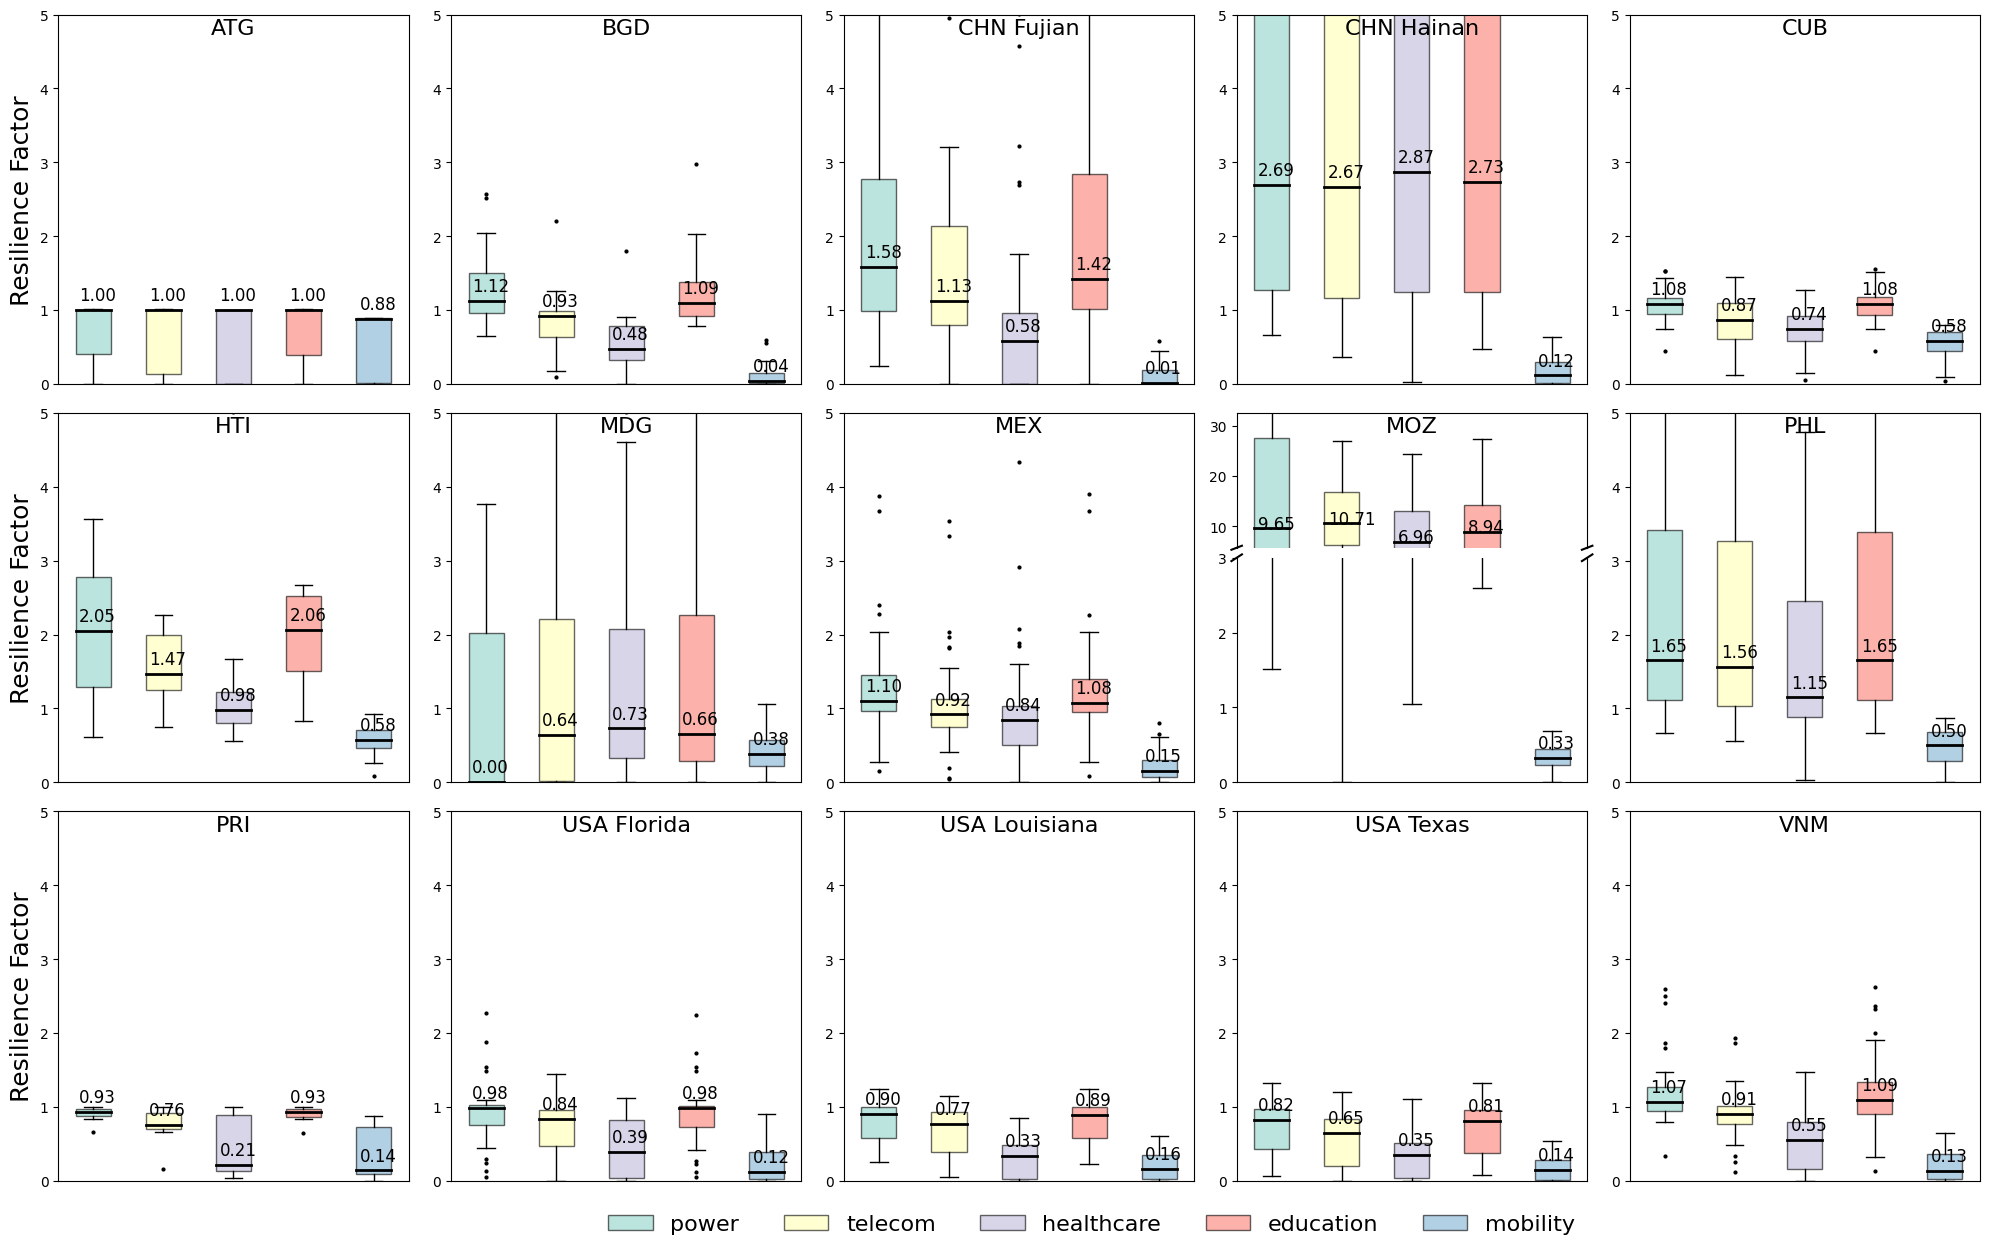

In [164]:
plot_cascfactor_boxplots(perevent_factor_c, factor_type='resilience',haz_type='TC', save_path='/cluster/work/climate/evelynm/nw_outputs/comp_results/')

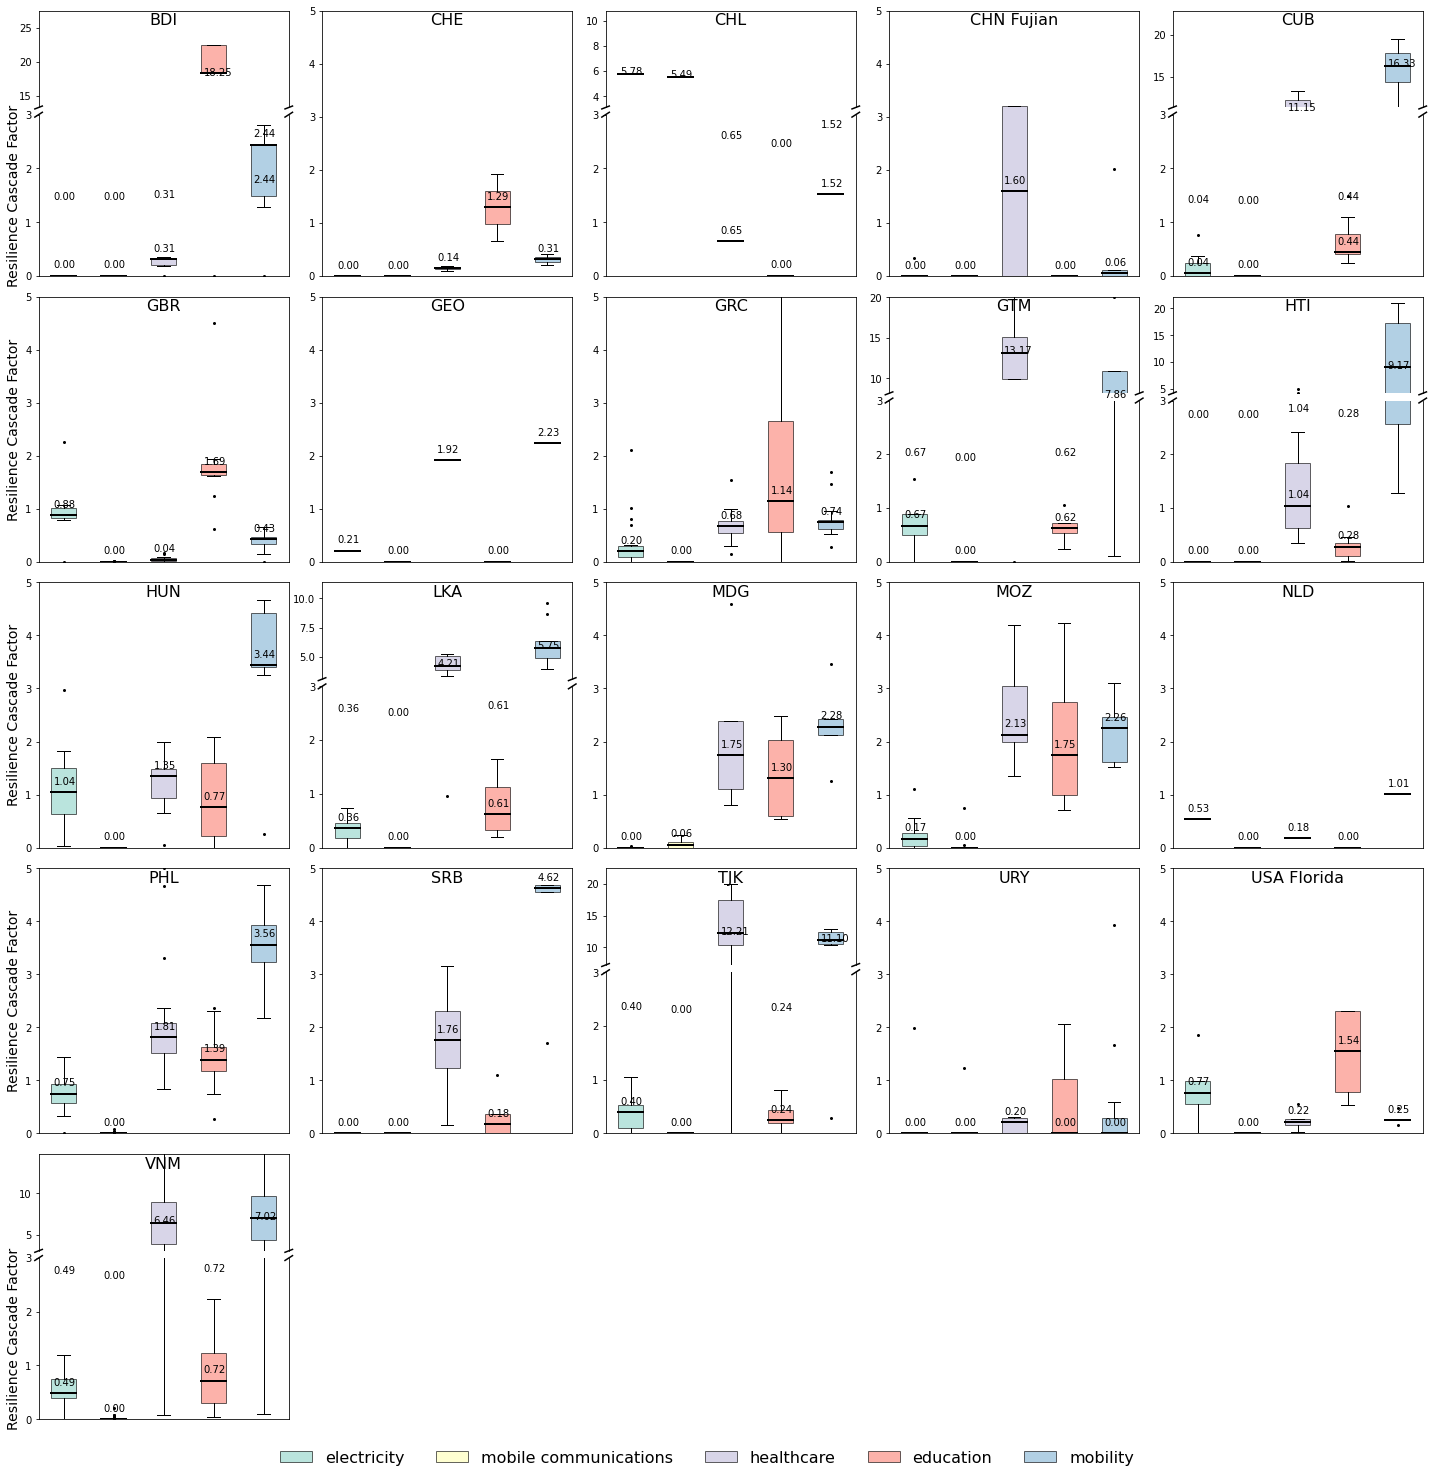

In [25]:
plot_cascfactor_boxplots(perevent_factor_c, factor_type='resilience',haz_type='FL', save_path='/cluster/work/climate/evelynm/nw_outputs/comp_results/')

In [27]:
perevent_factor_b = {key : perevent_factor_b[key] for key in sorted(perevent_factor_b.keys())}

In [29]:
perevent_factor_b

{'BDI':                        DFO_3980  DFO_4324  DFO_3981  DFO_4022  DFO_3875  \
 electricity                 NaN       NaN       NaN       NaN       NaN   
 mobile communications       NaN       NaN       NaN       NaN       NaN   
 healthcare              1.00000  1.000000   1.00000   1.00000  1.000000   
 education                   inf       inf       inf       inf       inf   
 mobility                3.91000  4.940000   3.91000   7.11000  7.110000   
 population              0.00018  0.000157   0.00018   0.00013  0.000157   
 
                        DFO_3863  DFO_3170    median  
 electricity                 NaN       NaN       NaN  
 mobile communications       NaN       NaN       NaN  
 healthcare              1.00000       NaN  1.000000  
 education                   inf       NaN       inf  
 mobility                3.91000       NaN  4.425000  
 population              0.00018  0.000151  0.000157  ,
 'CHE':                        DFO_2099  DFO_2140    median
 electricity 

/cluster/project/climate/evelynm/climada_venv/lib64/python3.9/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/cluster/project/climate/evelynm/climada_venv/lib64/python3.9/site-packages/matplotlib/cbook/__init__.py:1291: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/cluster/project/climate/evelynm/climada_venv/lib64/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/cluster/project/climate/evelynm/climada_venv/lib64/python3.9/site-packages/matplotlib/cbook/__init__.py:1306: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/cluster/project/climate/evelynm/climada_venv/lib64/python3.9/site-packages/matplotlib/cbook/__init__.py:1307: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],
/cluster/project/climate/evelynm/climada_venv

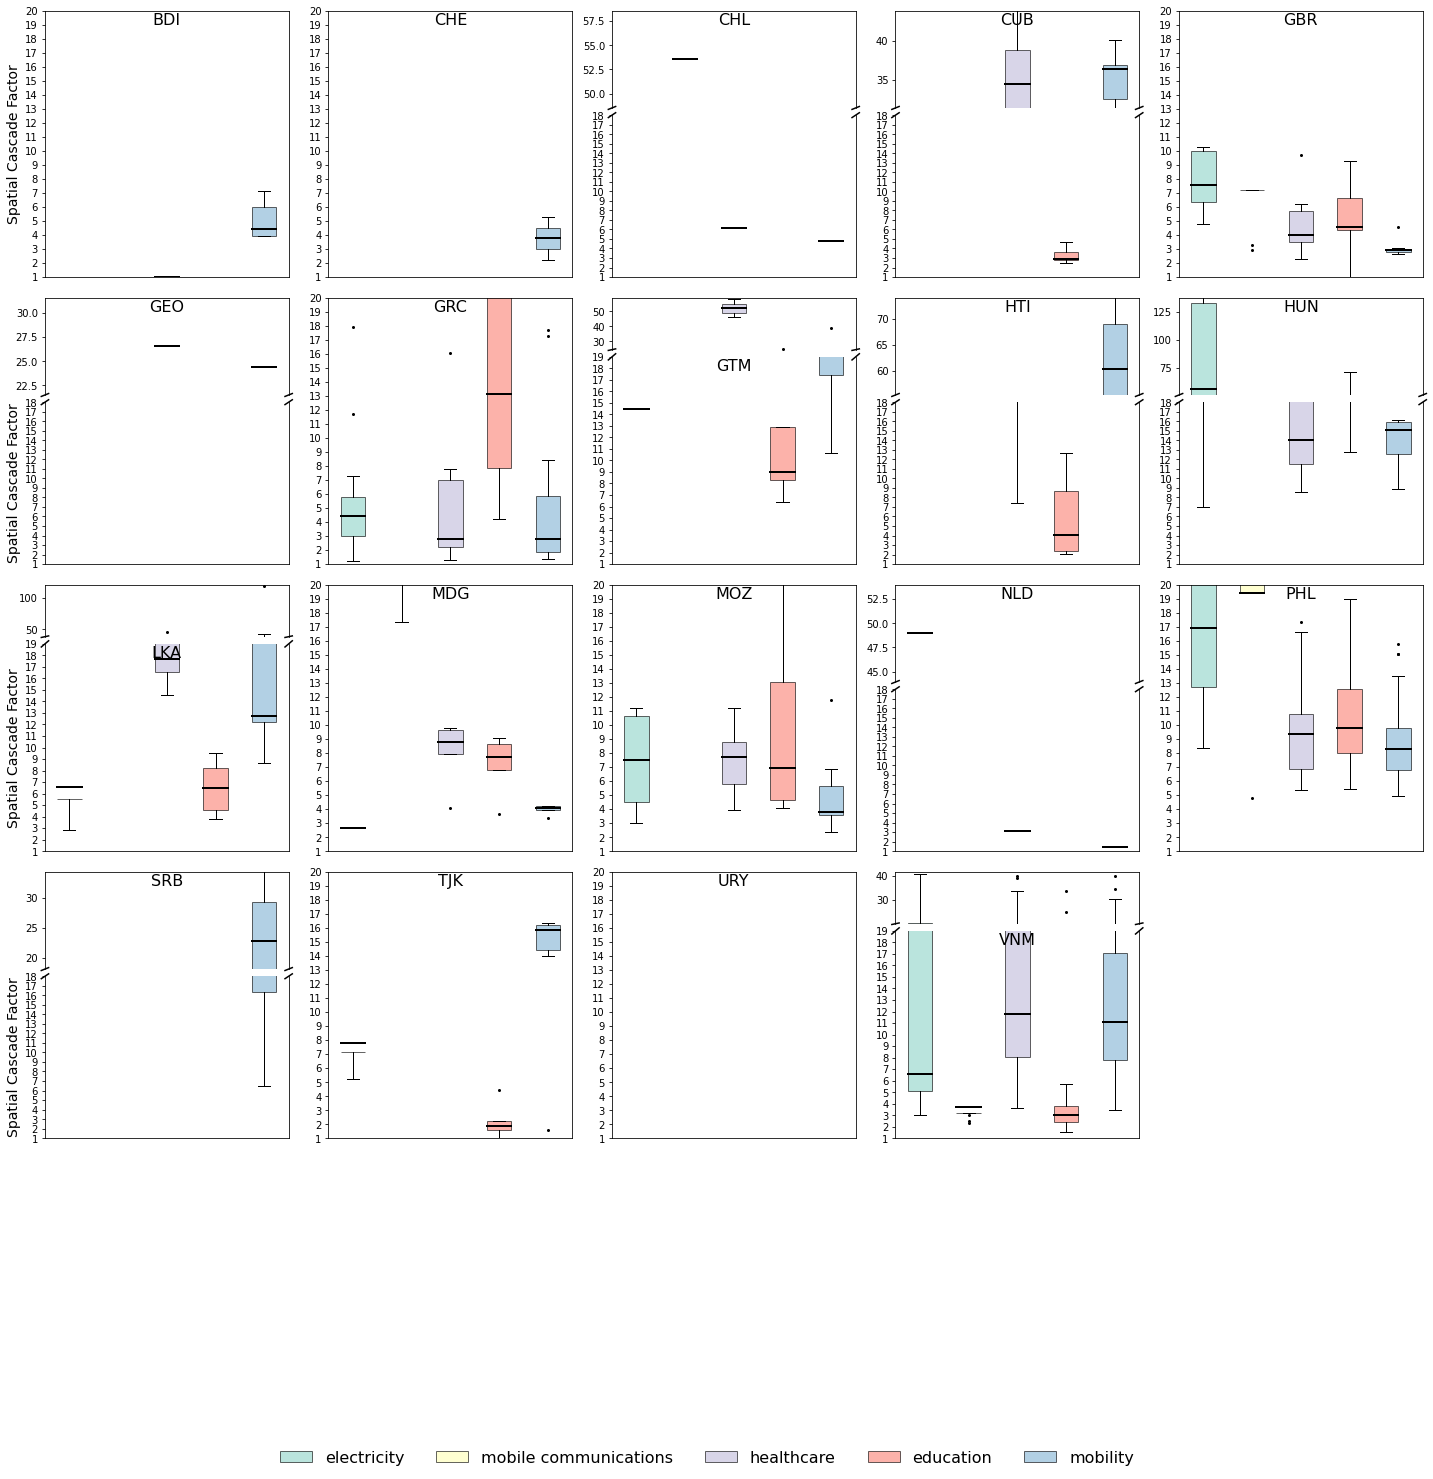

In [31]:
plot_cascfactor_boxplots(perevent_factor_b, factor_type='spatial',haz_type='FL', save_path='/cluster/work/climate/evelynm/nw_outputs/comp_results/')

In [29]:
dict(zip(total_imps_relb[list(total_imps_relb.keys())[0]].keys(), [[],[],[],[],[]]))

{'electricity': [],
 'mobile communications': [],
 'healthcare': [],
 'education': [],
 'mobility': []}

In [31]:
def scatter_cascade_ranking(imp_dict_relb_all, ref_dict, label, annotate=False, save_path=None):
    summary_dict = {}   
    for iso3, imp_dict in imp_dict_relb_all.items():
        imp_dict.pop('people')
        summary_dict[iso3] = np.array(list(imp_dict.values())).sum()/5
        
    fig, ax = plt.subplots()
    x = [ref_dict[iso3] for iso3 in summary_dict.keys()]
    y = [value for value in summary_dict.values()]
    z = [iso3 for iso3 in imp_dict_relb_all.keys()]
    
    ax.scatter(x,y)
    if annotate:    
        for i, txt in enumerate(z):
            ax.annotate(txt, (x[i]+0.2, y[i]+0.2))
    
    #plt.xticks(np.arange(5.5))
    plt.xlabel(label)
    plt.ylabel('average cascade factor')
    
    if save_path is not None:
        plt.savefig(f'{save_path}.png', 
                    format='png', dpi=72,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    plt.show()
                

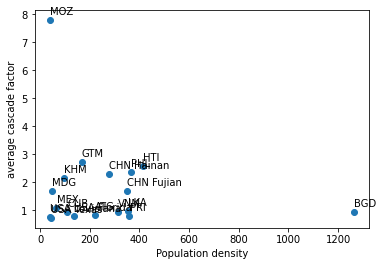

In [32]:
scatter_cascade_ranking(deepcopy(total_imps_relc), pop_density_dict(), annotate=True, label='Population density')

In [149]:
cascade_factors_df['pop_density'] = cascade_factors_df.apply(lambda row: pop_density_dict()[row.iso3], axis=1)

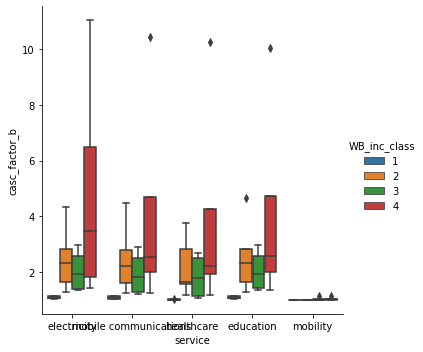

In [150]:
sns.catplot(data=cascade_factors_df, x="service", y="casc_factor_b", kind='box', hue="WB_inc_class")

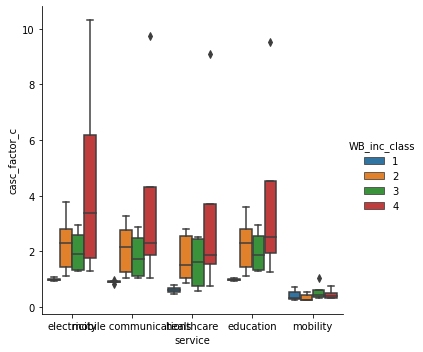

In [151]:
sns.catplot(data=cascade_factors_df, x="service", y="casc_factor_c", kind='box', hue="WB_inc_class")

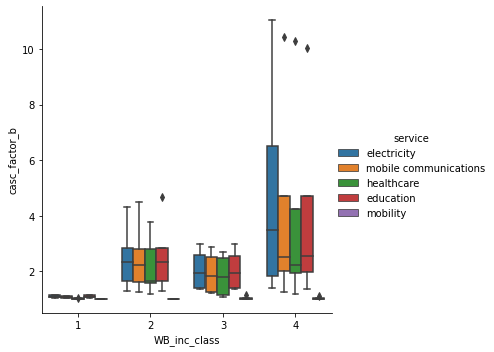

In [152]:
sns.catplot(data=cascade_factors_df, x="WB_inc_class", y="casc_factor_b", kind='box', hue="service")

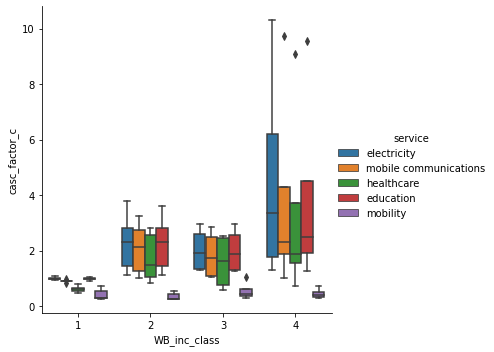

In [153]:
sns.catplot(data=cascade_factors_df, x="WB_inc_class", y="casc_factor_c", kind='box', hue="service")

<AxesSubplot: xlabel='pop_density', ylabel='casc_factor_b'>

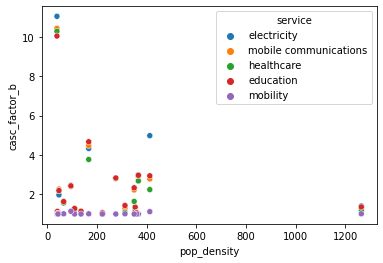

In [156]:
sns.scatterplot(data=cascade_factors_df, x="pop_density", y="casc_factor_b", hue="service")

<AxesSubplot: xlabel='pop_density', ylabel='casc_factor_c'>

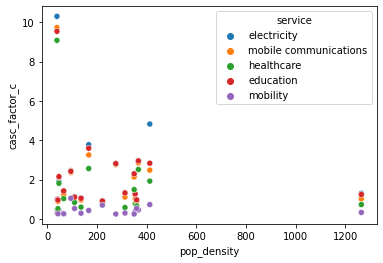

In [157]:
sns.scatterplot(data=cascade_factors_df, x="pop_density", y="casc_factor_c", hue="service")

In [10]:
import seaborn as sns
def scatter_cascade_ranking_perservice(imp_dict_relb_all, save_path=None):
    
    f, ax = plt.subplots(1,1, figsize=(10, 10),
                          sharex=True, sharey=True)
    
    summary_dict = dict(zip(total_imps_relb[list(total_imps_relb.keys())[0]].keys(), [[],[],[],[],[]]))  
    for service in summary_dict.keys():
        summary_dict[service] = [cntry_dict[service] for cntry_dict in imp_dict_relb_all.values()]
    summary_df = pd.DataFrame.from_dict(summary_dict)
    sns.catplot(summary_df)
    #plt.xticks(np.arange(5))
    #plt.xlabel(label)
    plt.ylabel('Average Cascade factor')
    if save_path is not None:
        plt.savefig(f'{save_path}.png', 
                    format='png', dpi=72,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    plt.show()

In [34]:
def scatter_cascade_ranking_perservice(imp_dict_relb_all, ref_dict, label, save_path=None):
    
    f, axes = plt.subplots(3,2, figsize=(15, 10),
                          sharex=True, sharey=True)
    axes = axes.flatten()
    
    summary_dict = dict(zip(total_imps_relb[list(total_imps_relb.keys())[0]].keys(), [[],[],[],[],[]]))  
    for service in summary_dict.keys():
        summary_dict[service] = [cntry_dict[service] for cntry_dict in imp_dict_relb_all.values()]
    for ax in axes:
        ax.scatter([ref_dict[iso3] for iso3 in summary_dict.keys()], summary_dict.values())
    #plt.xticks(np.arange(5))
    plt.xlabel(label)
    plt.ylabel('Average Cascade factor')
    if save_path is not None:
        plt.savefig(f'{save_path}.png', 
                    format='png', dpi=72,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    plt.show()

In [147]:
def scatter_cascade_density(df_density_casc, ci_type, service_type, annotate=False, save_path=None):
        
    fig, ax = plt.subplots()
    if ci_type=='education':
        x = df_density_casc[ci_type].iloc[:,1].values
        y = df_density_casc[service_type].iloc[:,0].values
    else:
        x = df_density_casc[ci_type].values 
        y = df_density_casc[service_type].values
    z = df_density_casc.index.tolist()

    ax.scatter(x,y)
    if annotate:    
        for i, txt in enumerate(z):
            ax.annotate(txt, (x[i]*1.05, y[i]*1.025))
    
    #plt.xticks(np.arange(5.5))
    plt.xlabel(f'infrastructure density {ci_type} (metres or units per cap.)')
    plt.ylabel(f'cascade factor {service_type}')
    
    if save_path is not None:
        plt.savefig(f'{save_path}.png', 
                    format='png', dpi=72,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    plt.show()